# Toxic Comment Classification
![](http://www.foolreversed.com/wp-content/uploads/2016/06/toxic.jpg)

Състезанието в kaggle [тук](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

Правилата са простички. Имаме dataset с коментари от Wikipedia, всеки 
един от които е label-нат с нула или повече от следните категории:

* <font color=#659EC7>***toxic***</font>
* <font color=#659EC7>***severe_toxic***</font>
* <font color=#659EC7>**_obscene_**</font>
* <font color=#659EC7>**_threat_**</font>
* <font color=#659EC7>**_insult_**</font>
* <font color=#659EC7>***identity_hate***</font>

Целта ни е да направим модел, който да предсказва кои са label-ите на даден коментар.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Нека заредим данните.

In [2]:
train_data = pd.read_csv("data\\train.csv.zip", index_col='id')
test_data = pd.read_csv("data\\test.csv.zip", index_col='id')

In [3]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (159571, 7)
Test data shape:  (153164, 1)


Имаме стабилно количество от данни. Дано обаче не се окаже, че нямаме достатъчно computational power да се справим с тях.

In [4]:
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


Няма как първото нещо, което ще направим, да не е Word Clouds :D.

След справка с интернет, първо ще ни трбява base64 encoding на снимките.

In [6]:
# грозотия
toxic64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAMAAADDpiTIAAAAA3NCSVQICAjb4U/gAAAACXBIWXMAANxnAADcZwE92HFDAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAAwBQTFRF////AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACyO34QAAAP90Uk5TAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDEyMzQ1Njc4OTo7PD0+P0BBQkNERUZHSElKS0xNTk9QUVJTVFVWV1hZWltcXV5fYGFiY2RlZmdoaWprbG1ub3BxcnN0dXZ3eHl6e3x9fn+AgYKDhIWGh4iJiouMjY6PkJGSk5SVlpeYmZqbnJ2en6ChoqOkpaanqKmqq6ytrq+wsbKztLW2t7i5uru8vb6/wMHCw8TFxsfIycrLzM3Oz9DR0tPU1dbX2Nna29zd3t/g4eLj5OXm5+jp6uvs7e7v8PHy8/T19vf4+fr7/P3+6wjZNQAALMJJREFUGBntwQegjfX/B/D3OXdfe2RmZyvKKi2ljBJKKCIJqZQGDZFUWqKIsiJlprRTslcIWdl7Xtu9l7vPef9//fr1b9znPPfzPOcZ33Pveb2APCOybIM2Dw148bWRH0yZ9eUPS9ds2nXoVHJmZlLC/m3rV8z/ataUsW+/MvDJh7q1a1gmAmG5RWTZBm0eGjrx2w3HfRTLOrLmizHPd2tWowDCQlV0nU4vf74hwcegJG1f8PHrPRvlQ1joiKrV4aU52zJpIf+euUPvruZFmNoia7R/cfbWDNokZd3kJ28pgTAlFb7tteVpdMCJBSPvr4QwlZS7d+xmH510cOoDFRGmAE+dPtMO0BUHPupeAWEuimzy7Ddn6ar9U+4vjzA3FOjwyVkqYd/kbuUQ5qhyj/6YTpWse64qwhxy1UsbqKBNL9ZCmN2iW4w9TGVte6UuwuwT32VOEhW3+42GCLPFtZOSGBIOjGjiQZi1yj6/kyHk6NvVEGaZmI7zshhqFnWKRpgV6o85w5B04s0qCAvSJU9uZujyz28fhTDzmn2RwRB3fFhFhJkS2WUDcwPfvHaRCDOq4NOHmGscfbkswowoNzyRuUr6+EoIk6o3LZO5TubUGgiTaLmAuZNv9hUIy0F09y3MvfxfN0KYjsiHjzKXm38DwgLwdNrNPGBZc4RpuXU984i1bTwI+5cGC5iHbGqOsL+r9qmfecu3NRD2p9LjMpnnZI4uirDfFX7tIvOks/2iEBYz4AzzrB2tkdfduot52vw6yMtKzWBel/XBJcirvI+cZxjPD4hGnnTVWob91552yHsKvJtFl/hTzx3bt239yoXffTZt0qTpc+ctWb1p1+HTF310zWclkcfcfZTOurB72ax3nrmvWa2iMQgkpnDpak27DHh3zsoD6XTW6S7ISyp/T6ecWzGh/71NqxeAMZ5L6t3e66WJ84/RKd+UQV4RPTCFDji7fPzjt5RGkIrd2Hf8ykQ64FwP5A1NttFmKcvHPdasFCxU4fbnpm9Kp81+LI/cL+KlLNrp1Jf9r46CLSJrP/DRftopqY8HuVzlVbTP7ikPVofNKnT7cA/ts7gycrVuSbRH5i/vtC8Jh5TtPGEnbXKxnxe5VuFZtMXZ6fcUhsNKdXp/F22xoiJyqRsO0gY7374xEu6o8+JG2uDcnciNol7z0WpZS/tXg6sq91/lp+XejUauU/UXWuz8rC5FoYAyjyzIpMXWVkIu0/MCLZX1XYcYKKNo96/TaKlzdyE3Kfo5LfXbgFJQTP6uy2ip0dHINRoepoXOjm0IJdUceZoW+qUycomuqbRM1ncdYqCsmM5LaJ3z7ZEbRIygZbYPKA3FVXv7FC3zXjRCXpEfaZUFrTwIAdGdFvppkXWVEeJq7aY10qfWRci47K3ztMbZmxDS2iTREmdfK4OQUvD5E7RExgMIXZ7Bflph96P5YB1vgVKX1buuRfv7H33m5ZETxo946emHOt9xU4PqZQt6YaG4vgdpidc9CFH5PqMVlrfzInhFG9076KOlm/eduMjALibs/nXZdzOH3d+kOIIX1X0HrTAnDiGp4iZa4JuGCIqn7A09hs1ad44GnV39yeBOV+ZHULx3r6cF1pRECLrpNIO39FqYFt/0kRFfbU1hUI4tmdC/bc1omNZyKYN3sA5CziOZDNqGljCp5F0j12TSMll7Pu5RGSZd+z2DltQSIWYog7azowdm1Og5ZTdtcOiTB6vAlBvXMVhZjyCUeMYwWId7RsKw6CYDvjpNGx3+pOdlMM7T9TCD9a4XISNqBoN06qlYGBTT6vVlqXTAkWm9qsKouEHJDNI3+REi4r9ncC68VADGxLablkgHHZ3e61IYU2pCFoOzvjhCQuEVDM7ccjAkvv2sZDrOv6RXERhy+Y8MztZSCAGlNjEo+26HEfk7zblIl6R/cXcsjGi5lUHZVQ7Kq7SHwUh/NQ5yBTrPTaGrEic380Iu4qETDMb+ylBcnWMMxsLqECvU7es0KuDYiPqQK/IRg3GkOpR2zVkGIaEzxGrPTqcytg+uDLEWBxmEhMuhsBYXaJ5vTCFIVZ/ho1p+7nsJhPKP8dO80/WhrI4ZNO+X+pAqMzWL6sl47xIIXb+T5p2/Bopqn0XT0p/2QqrBUaopaVA8ZGLfyKJpyU2hpNsyaNrWuhDrmEJlHesKofobaVpKSyioaSrN8o+KhZTnJT9V9pYHMlGD0mlWelso5+pkmnWsBeTepOJmREOo9haalXkHFFPvHM2aWwxy7am8xYUgFDeBZqVcD6XUPEmTkh+EAdWTqL51MZC6J5Emnb8CCql8lCatvgwG5PuNoWAUxKqso0nHK0MZl+6nOVlDI2HEeIaG1hCLfocm7SkJRZTYQXOONoEh5TIYGk6VgdwdZ2jOr4WghKKbaM6q0jDmXYaKn2DApctpztJYKKDAWpozIRrGFLvIkHENDIh41UdTvoyA6+KW0pSMPjBqKEPHLBjS8jxNmQy3eWbTlITrYNgJho7MS2FIzb005U24bAhNWVsWhlVlKHkdxhRfRlP6w1Ud/TRjSgyM68ZQcjoKxkRPphn+7nBR/RSakPkYzBjHkHIljBrgowkZN8A1ZY7ShJNNYcomhpQeMKxNMk04WR4uifuFJuysCFNifQwpo2Fc3UM04dd4uGMWTVh/CcwpzNCyHCaUWk0TZsMVQ2jC4oIwqTBDS5IHJsTOpAkD4YIOfhr3RSzMKswQkx9meMbQON8dcFz9FBo3OQKmFWaIiYA5b9C4xJpwWJkjNG44glCIoSUDZg2kcbsKw1Fxa2ncswiG5xxDSiJMe9xPw36MgJNm0LCsngjOfIaUBJj3gI+GvQ0H9aJhaXchSK8wpGxHEDpm0LCucEztFBqVfDOC1ZohZRKCcXsqjUptCIfEbaFRqTchaCUYUjojKDcl06hDReCMcTQqvRUssIahpDSCc/U5GjUHjribRmXdBSvcxRCyHcFqmEyjesABFc/RIF8XWMK7g6HjPQTt5jQalFwVtov8mQb5e8EiPRgyMi9D8Npl0aC1UbDb6zSqH6wSfYShYiKscL+fBr0Gm93ip0EDYZ1eDBFp5WCJJ2iQrylsVeI4DRoGC3nXMDSMgkVepkGHi8BGnh9o0DuwVAMfQ0FSSVjlPRo0BzYaQIMmwGIfMBT0hmU802hQD9imUQaN+cYLixU9RfX9BAtFfkNjkqvCJtHbacym/LDcg1RecgVYKXYpjVkbBXu8RGMSysN6np+puodhrSK7acxrsEWtdBqS2hh2uNJHtS3ywGI1E2mIryFs4FlJQ/ydYI8xVNqFSrBcKx8N2RAB6z1CY16ETQqfoMr6wgb9acxTsFzZRBoyA7bpToUt9cAOH9GQC+VhtS9pyKpY2Mazgsq6WAW2iFlFQ76CxdrTkAMlYKO6WVRVP9ik5CEacicsVegYjUiqA1uNoqJWeGGXKy/SiCMFYKXxNMJ3G+xVKIFKSqkK+3Tw04hRsND1fhoxDHbrSiU9BTsNpRG+BrBMzA4asTIStltGBa3ywk6eb2nE+ghY5WUacbY87Hd5JpWTWgP2uuQYjXgCFqmdQSPuhBNGUjnPwG7NfDQguRys8RONGAtHFDxGxayJgO1epxFfwhItaMSmWDijM9WSVgv2i1xNI+6ABbybaMCFGnDKYirleTihUiIN2B6B4HWnEQ/AMbUzqZBfIuCIe2lELwQt7jANmA4HDac60uvAIVNowLF4BOs5GrC7AByU/wiVMQhOybeTBryAIBVPpFx6fTiqE1WxIRKOuTKdconFEZxRNGAgHLaAasi4Ag56ggaMQlCqZFBuUxQcViODShgCJ3kWUy69MoLxKeV8DeG4N6iCjVFwVLVUys1AEBrTgJFwXr7DdF/mlXDYQMr568O8ZZTbnw8uuJvuexlOi9pMuQUwrS0NaAFXzKfbNkfDcY19lGsBkyK3U+5juKNaOt2VWR8uGE25jV6Y04tyJ4vBJa/RXcPghvyHKNcVpkTsoVxnuCX+IN30Wwxc0ZpyB6JgRifKfQ/33EkXZTWCS2ZTrhvM2ECx5Apw0Ty65024peRZim31wLgWlOsHN12WRrdsj4VrHqTc7TBuMcU2e+GqV+gS39Vwj2c5xZbBsMaUawl3xe2nO96GmxpR7hoYNZdi8+G2NnTFzji4ajbFvoBBNfyU8tWF676lC3zXwl2V0ynlrwFjJlNsCtxXOZXOewdue4dik2DIpRmUSikLBbxEx+2Oh9uKnqNUehkYMZJir0IFsXvpMP/1cN8Air0FA4omU+pEASjhdjpsNBQQc4BSiYUgN5hiD0MRX9FRe/NBBV0o9izE4k9RanskFFExhQ7yN4USPOspdSwGUn0p1gbKGEwHjYUibqZYT0htodQSqCNmNx2zPz9U8R2lNkGoMcUaQSEt6ZhmUEZdijWEzERK/QSlzKVRaQkJaTRuHBTyLaXGQyRfMqWaQSnlL1LgxPzxbzzX556WV9coFYv/iC1ds8ltnR99Yfik749S5GABKKQJpZLyQaIHpX6BYgZSV9a2mc+2LA0dJZo/M3O7jzloDqUspVR3SKyiVHsoJnonA/Ctfq9nwziIxF/dZ9yaDAY0CWppQakVEKhFqR1eqKY5taTP610SBhXp9lUqNR0uCMWsp1QN5GwEpXpAPXP4b0mz7ykIU/J3nJ3M7FpBNR0oNRw5ij5FoSPRUE+5C/y7ExNvi0EQYttMPcd/mgLleHdS6GQUcnI3pZ6Cip7l//N/fbMXQYtqMT2TfzlaGOrpQan2yMkPFDqTHyqK2s4/pE6oAYuUfyeZf2oNBUUdotA85KC8j0JDoaZm/N2poSVgoSIDE/hfH0NJ/SjkKwd9Qyh0sTgUNYvc1ScOFovptYPk8SJQUvwpCr0IXd6DFBoFVZWd384LG3jarmRbKOpFCh3wQk8LCvkqIA+qDVWVyaJQc+iZQaF5CFPKVxT6CDqiEynUHmFKuZ1CZyIRWEsKnYxCmFK8hyjUDIGNp9BwhClmCIXGICDvcQrVQJhiyvkoc8SDQJpQaAXClPMthRojkOEU6o4w5bSh0BsIZDdlEuMRppyIo5TZhQDqUGgcwhT0CoVqQ9tgCjVAmIIq+CgzCNo2UGYjwpQ0jzIboKkChfoiTEn3UKgitPSjTFoRhCmpQBplnoSWJZT5BmGK+ooyy6CheBZleiBMUd0o4yuB7B6gTFZxhCmqcAZleiC7LyizBLlEVOEyVes1uebyisVikFvMo8wnyMZzljL9EOpK3vrQm3PWn+dfMs5s+WxYt8aFEeoepMxhZHM5hSoghEU3enzGPgaUMLdvLYSy4lmUqYJ/e5QyGxCyinX/KoU5SpjZqzxC1gLK9MC/zabMYISmko8tyqKQf+mDBRGaHqbMx/i3Y5Spg1BUfUIaDUmddXskQlApH0UO4V8uo8xuhKAmX/pp3LH++RF6llGmMv6pB2XeQqjxtltJk04PLoxQ8zhlHsA/fUSZaxBaYnvvZBASX78EoaUSZabin/ZR5LgHoSRyQAKDlPREBELKfoocxD9cSpkJCCU1f6EFNl6DUPIhZSrh7zpT5l6EDm//VFrCP7EoQkcXynTH331AmTIIGVWW0zKnOiBklKbMR/i73yiyG6HC88gFWmlsDELFdoocwN8U91PkQ4SIcj/RYhsuQ4gYS5mK+MudlOmG0NA9kZZL7IjQ0J4ynfGXdyhTAaHA8w5t8Y4XoaCYnyJv4i8rKHIAoSBqBm0yKxqh4FeKzMNfzlPkY4SA/PNpmwUFEAJGUOQo/l85yjwI9ZVYRxttKAn13U6ZYvhTK8pcBuVV2k1b7a0M5RXIpEhT/GkARY5CeSX30Wb7SkF5aynyOP40lSIzobr862m7jYWgug8oMgl/2kCRPlBc5A90wJIYKK43RdbifyJSKVILiptCR8yNgNoaUeSiF3+oRpHUCKjtFTrkfagtLosi1fCHuyiyAWp7gI7pBrX9RpG78YchFPkYSqt+kY65UBNKm0aRofjDHIoMgMqiN9BBW+Khsv4U+QJ/2E6RVlDZcDpqMlTWjCJ78V8xWRQpB4Xd6qezukJhxSjiz4/f1aPIeSis+DE67FwJKOwQRRrjd/dRZCUU9jkd9xEU9jVFOuJ3b1BkHNR1M53nvw7qGkqRp/G7zyjSF8rybqALNkdCWXdSZBR+t4oiTaGs++mKJ6GsahT5Ar87SJHiUFXcEboi6RKoKsZPiXX4D086JY5DWYPoktehrKOUOIn/uIQiP0FVJZPpksTCUNVKisQCqEeR96Gq4XTNYKhqOkWqAriNIoOgqPizdM3p/FDUMIrcDKAnRXpAUb3oov5QVC+KdAcwhCItoahNdNGxSKjpVooMBjCeIldATTfQVa2hpqoUmQjgG4oUh5o+pas+hZpi/JT4AcAGSqR7oKSymXRVWmGo6SgltgFIoMQBqOkZuqw31LSSEslApI8Sq6CmZXTZSqhpOkWKoBxFPoOSimTRbVWgpGEUqYbGFHkPSrqXrnsUSnqUIlfhToo8DyVNo+s+h5Luo8gN6EOR+6GiiNN03RkvVHQHRW7HkxS5FSq6lgq4Ciq6kSKdMJAitaGioVRAf6ioHkV64hWKlIGKvqQCvoeKKlHkCQynSBGoaC8VcB4qKkaRQRhDkVgoKL+fKigFBUVS5E1MooTfAwU1phJuhI5CxWLgiouUGIvplEiBih6kEnpDx2tk5rnD239Z9PWMCSNffuaRbnc1b3JF5RLxsNtxSkzFXEqcgYrepRJGQMcz1OZLOrZrw7LvP508+rWBjz/QodX1V1YtXcAL6+ygxFx8T4kjUNFCKuFb6OhNIy6e2Ltp5Y+fTx375uAne917x00Na5YrHAVT1lJiPhZTYjdUtJdK2A0dHRm0tNMHtq5e8OW0ca92bVQIUj9R4mespsRmqOgUlXAROprTWsdn3uKBxGeU2IKNlFgDFWVQDREIrDEtd2BIeeTsI0rsx05KLIGCYqmIQgisOm2QPjACOZlEiVM4SIl5UFAJKqIsAitJW6ythRyMp0QiTlJiLhR0GRVRA4HF0B5pT0PfB5RIRjIlpkNBV1ERDaEjlTZ5FbrGUOIiMikxCQpqSkXcBB3HaZch0DOKEinwUWI8FNSMirgeOhJomxegYwwlLiCVEpOgoGupiOrQkU77dEBgH1LiFBIpMQUGFKx1Y1OL3AAdV1IRRRFYPG10KB4BTafEYRynxCzI1H31h98SaaF4BFaaasj0ILCytNPLCGguJXZjDyW+hcDlr+yk1SojME8alXAcOurQTqkVEcg8SmzBJkosQY5qLaQNmkDHLiphM3RcR1tNRSCLKbEWKymxDjnIPzyDdmgPHT9RCQug4w7aKjEaAaymxDLMp8R26Gt/hPZ4FDomUgkzoaMb7dUCAWyixHx8QYnD0NWfdnkFOgZRCaOgox/t9QEC2EmJr/AJJc5Bz8u0zSTo6EolDIKOl2ivYx5oO0SJ2RhHiUwE5nmX9vkWOq6nEnpDxyjarDy0naLEVIygSDQCGkUbrYOO8lTCHdDxMW3WBNqSKTEeQylSFIG0op2OQkdEJhXgLwYd39JmHaEtixLv4hmKlEcARY7STpke6NhPBWyEnj202VPQFEWRN/AoRWohgE9or0ug41MqYCR0FKbdRkBTQYq8hPsp0hDa7qTNroCOblRAa+i4mXYbDU1VKPIc7qbITdC2lTbrAh2X+Oi6rILQ0Z92ewuarqdIP7SiSBtoupZ2+wB6fqbr1kDPTNrtZWjqRJGeuJ4ivaHpY9ptC/QMouteh55dtNtAaHqSIq1xFUVehZYiqbSbvzB01KPrboWOgn7a7UloGk6Rq3AZRaZCy+O0323Qc4QuS4+Hjqa0XUdomk6RkoijyGJo+Zz2ew16xtNlS6HnKdquHjQtpkSmFzhFiT3Qsp32WwY9beiygdAznbbLB007KHEYwAZKpHmQXXQm7ZcaDR3xqXRVWgno2UG7HYW2JEqsAfAVRUoiu8vphCbQ8w1dNQl6Cvhpt8XQlJ8iXwAYQ5EGyK4TnfAM9DSlq2pDzx203XhoqkaRsQCepchdyO5hOuFr6FpBF/0AXdNou/7Q1JQiAwF0pkg/ZHcfnXDaAz2t6KIW0BObRNu1gabOFOkO4HqKjEB2bemIutC1nq7ZCl130n41oKk/RZoDqEiRT5HdTXTE29B1F13zIHTNpO2yoqHpPYrUARDlo8TPyK4BHZEQCT2erXTJiVjoibtA2+2FtkUUKYr/OEqJo8iuAp3RBrq60CVDoOtu2m8etJ2gRCp+t5oSvlhkd5qO+BK6IvbQFRdKQNcc2m80NBWnyF78bg5F6iO7eXRERgno6klXPAZd+VJov77Q1JQiy/G7kRR5ENkNpTOegq6o7XTBCi903UMHNIOmRykyE797kiKjkV1rOmML9DXIpONSq0PfXNovMz80vU+RIfjd3RRZiuxK0CENoW8wHfcc9BVMpf3WQNsyirTH7xpR5Dw0HKAz3oe+iJ/psHWR0Pc8HTAc2s5QpAZ+V8BPkYrI7lM641ws9F12gY7KqAt98SfpgDugqRRF0iLwX3sp0hbZDaBD7kEOetNRLyMHT9IBviLQdAtFNuEPcynyIrK7kQ5Zjpx8QwdtjYa+mGN0wEZo60eR6fjDEIrMRXb5fXTI7chByZN0TGZj5OAROmE0tE2gyED8oR1F9kLDFjpksxc5aEen+LsjB1EH6YS7oW0VRdriDxUp4i+I7CbTKfcjJ2/SIf2RkwfpiBLQ5E2kSBX8z3mKXIfs+tApB2OQkzF0xFvIScRuOmEHtNWlyEUv/mcZRR5FdlfRMU8hJ57JdMAU5KgLHTEe2vpSZB3+9B5FJiK7qFQ65XQh5MQ7k7b7OhI58W6jI7pA22yKTMWfelJkOzT8TMcMQ44iv6DNlschR53ojHLQdowiA/CnhpQpjexG0TEXSyNH0fNoq02FkaNCR+iI/dBWhTK34U9xWRTpjOy60DnjkbO4xbTR3tLI2QQ6Yyq0dadMefy/bRSZiOwq0DmZ1ZGz/Ktom6UlkLOb/HRGJ2j7kCJJ+MtMiuyFhl/pnG8hED+VNhkdiZzF76EzLsZD2y6KLMdfnqNMeWT3Ih3UBxIPptAGqfdDYgQdMhvaSlHmdfylFWW6I7sr6KCUmpC4Yictd6gBJBpl0SF3QVsHytyGv5SmzMfQsIcO2hgDiQIzabElJSARtYUOSYqFttEU8RXC3+ylyGFoeJtOegcyD6fRSqMiITKETpmGAH6lyEb83STKVEV219JJ/paQuWovLZPUDTJ10umUO6CtkI8i7+HvulCmN7LzJtBJCSUgU+jDLFoia1wJyESsoVPORUPbHZTpiL8rS5lZ0DCejvoOUrW+pAW+rw2psXTMFAQwkTKl8Q+7KHICGlrSWY9BrMlyBmlzc4g9Rue0hDZvAkX24J/GU6Y2sotOpKNSL4dc6y0MwvFeERBrlUXHnI6EtiaUmYx/upcyz0PDDDprawHIee8/QJNSXs0PucuT6JwJCOAtyjyAfypFmfXQ0IEOWxwLA2Ke2EYTfn2qJAwoeYAOaoYAdlLmMvzLdspUQnb50+iwryNhyBWv7aUhR96qA0NiV9NBJyKgrQZljuPf3qdMf2j4hk6b5oFBDUccplDy1Fu8MMYzi04aiwCeo8yn+LeOlFkNDT3ouLEwzHPdmATmKOPH+/LBsJfpqBsQwM+UeQz/VoIy/nLI7pIsOm4YTIho9PCEdWkMIH3d+IcaxMCE++iovV5oK+WnTD1ks5UyT0DDEjqvP0yKqvvAe4s2HTzv5/+kJ2xb+e0Hva6KhkmdMuioJxBAb8qc8yKbMZRZDg196YKeCI63cMW6N954xaX5EKSHfHRUUkEE8B1lZiK79pTxl0Z2hS7Qeb6OUMLzdNi7CCB/GmU6Ibvifso8Cg3v0wUZraGA4XSYrzICuJsy6QWhYR1lFkNDLbohqx/cFjGJTvsSgXxJmR+g5XnKZJWAhoV0xYQouCr6MzquKQIokUGZPtBSlUK9oaEd3bGkGFyU7yc67lcE8jRl/GWgaRNlFkJDxAG6Y28tuKboajrvfgSylTJroG0wZfxVoOFZuiTxNrik3g46LyEGATSi0PPQVpNCb0JDsVS6xPc03OB5Kp0uGIJAPqBQLQTwG2VORkPDZLpmcjQcV+pHuiGtJAKIO0+ZXQhkKIXugYYr6Z7ll8JhrU/SFVMQSGcKvYVALqfQYmhZQfckPe6Fg2LH0CX1EMgCCl2LgHZSqDo03EM3/VIPjrl8K12yGIFU8FPmhBcBDaPQCGiIOkY3Zb2dD854PI1uaYtAhlBoIgK7kkJnYqHhRbrrwG1wQn26Zo8XAXj2U6g1dOyl0H3QUCqdLptdCg74nG7pgkBuplByLHS8SaHl0DKdbjv/kAe2q5xGd6z3IJC5FPoQehpSqjY0XE339YD93qQ7bkYg1XwUuha6DlBoNLT8QLftj4H9Cp6gG75HQOMptAP63qTQuXhoqOujyzrCCb3pAl8dBFIylULPQl9VP4WegJaP6a4VcETEJjrvQwT0KoUySyMHCyl0JBoayqfRTf6GcEYzOi6lLALJf5ZCXyMnHSnVG1qG002fwClf0WnDENATlGqHnESdoNC+SGgocpbuuXgpnFI1g846WRCBRB6k0Iko5OgNSnWFlv50z1A4ZySd1RcBdaHU28hZFT+FtnmhIeYg3XI0H5xT+BSdtCsKAW2kVC0IzKfU3dDSlW65H056hE5qj4CaU2o1JNpTagO0eDfSHes8cFLEb3TOKgS2gFK9IRF1nFK3QUtzuuN6OKsFnXMtAqpPqYsFIfIapVZB0090wxw47Ts65QsENo9SH0Omko9SN0HLlX46L60ynFYjk87IrI6AbqJYUwj9QKkF0DSNznsTzhtNZ7yLwNZSapsHQndSrAm0VEyj004WhPOKnqUT9sQjoA4UewBSkcco9bMHWkbQaQ/BDY/TAf4bEFDkLkodjYbYKxS7F1qKJtBZWyLghsgdtN8oBNaHYgMgVyaNUgfjoKUdnXUr3HE7bbc7HgHlO06pxIIw4AOKvQBN0+ikb+GWH2kz33UIbBDF3oIRFTMplVwKWooco3Mya8AttbNor3cQWPFESqWXgSFTKfYhNN1O54yGe96nrXbFIbB3KTYZxtTwUcpXD5qm0Clni8I9xc/TRr5rEVjFdEr5a8KgORRbBE2FDtMhT8BNT9NGI6HjE4p9DaOupFw7aGpBZ+yKgpuid9M2O+MQ2LV+il0Hw76j2O4oaBpPR7SBu9rSLr4mCCxqK8VWwbgmlHsSmgocoAMWwm0LaZO3oWMg5e6ECYspdq4YNN3sp+18deG2uj7aYkcsAquSSrGdXphwC+U+gbYxtN1EuG8C7eC7BjrmU64XTFlDudugKd9e2iypJNxXMok2GA4dXSh3IAamtKHc4YLQdIOf9noeKniW1tsWi8CKnKBcV5jj2Uy5cdD2Dm11IBYqiNlHqyXWgI6JlNvkhUn3Us5/EzTF7aSdOkEN7WkxX2vouN5PuZYwy7uZcnvioal2Eu2zEqpYSmu9AB3R2yi3CObdQgNGQltbP+3ibwRVXOWjlT6FnkGU8zdAEL6hnO9qaHuBdpkGdUymhTbGQ0e1VMrNRjCqZ1JuWwy0zaY9UspBHaWTaZlTFaEjai3lMi5DUEbTgFehLX4DbfEyVPICrZLZFHpeowFjEJyiZymXWQ/ayp+gDY7mg0piD9Iij0JPUx/lkksgSE/QgA3R0HZdOq3XHWq5h9aYBD1FD9OAIQhW1C4a8C4C6EXLrfdAMStphZXR0PMZDUjIj6C1oRF3IoD3aLUboJpGfgbvSCno6UkjHoEFFtKA85WgLXIhrfU51PMJg5baEHqqX6ABuyJhgbo+GvBLNLQV20srpVeGespeZLC6Qk/0ehrRHpaYRCPeQwB1kmmht6CiIQzSCOgaTiO+hzVKJdOIuxFAOz8tc7IQVBR/mEH5MQJ6bvHTgIsVYZGBNCKxCgIYTMv0gZruYzB2FYGe4kdpRH9YJXY/jdgQgwAm0yJbI6Amzxqad6Qi9ET8RCN+jYRlmtOQ9xGA9yNaozlUdQ1NO1UDut6lEb6GsNBkGtIJAXg/phW+g7pm0qTEq6CrBw0ZBSsVPkYjkqoiAO80Bi+zJtRVPoWmpFwHXU3SacThArBUOxqyvQgCiJjBoL0Hlb1CMzJaQle5BBrSDhabTUMWRSGAiFkM0rliUFm+YzTO1wG64tbTkC9gtRKnacgUBBL5KYPzJNTWnYb5e0DfLBqSVBaW60JjBiKQyM8YjF1RUJtnHY16DPoG0pjHYINvaYi/EwKJmssgtIXqrqcx/oegr42fhqz1wgaXJtKQ1GsQSNSXNG0R1DeHRmR1g77aSTQksx5s0ZvGnKyEQKK/pkm+elBfpTTKZXaCvuJ7aMzrsIdnEY3ZVhiBRH9LcyYhFAyiWHpb6CvwC41ZFwWbVL5IYxZGIZCY72lGcimEAu8iCqW0hL6YRTTmQjXY5kka9CECivmSJgxEaCh9kiIXboK+iC9p0IOwj3clDRqEgLxv0bADsQgRLfwUON8E+jwf0aA5sFP5MzToKQT2QDoNugch4w3mbFcN5OAdGnSoCGzV2k+D+iKw60/RkFUIHZFjmZMfCiMHg2mQ7wbYbDgN8vdGYJV/owH+xgglD2dS13AvcvAojXoVdotcRYP83RFYwXmUG4nQcvMZBpbYBTnp4qdBqyNhu3JnaJCvCwKLGEWpTTEIMVW2MADfxBLISetMGpRUGQ5o7adBWR2g46FMiqTWRsiJuG87tSy7Ejm6IYVGdYUj3qJRme2go9lZSvRFKPJ23Mx/8a/piJzdcoFGTYczIlfRqPTboaPaTuZsDEKUp824XzP5J9+yfuUgcEcajdpXEA4pd4ZGpTWHjiILmZNBCGXx1z01bfr4t1/qf39JiHTKoFGZ18Axt/tpVMot0BE5jrqyeiJPecBHwx6Bg96iYemdoKf3eQZ2vg3ylL5+GvYBnBS5kob5HoOeklMZgG9iCeQpz9G4JVFwVLnTNO416LpuM7UsvxJ5y6s0bl9xOOyGdBr3YQT0RLabdZH/lPxpW+QtnndpXPLlcFxXmvBNHPTFd5qb4Of/nPmoTSzyGO9EGudvBxcMpQkriyJHsVVv6dHvnhurF0TeE/cpTXgBrphOE34rh7CASq+lCbPgjpgVNOFwLYQFcNURmrA+Di4pvocmnL0WYZraX6QJCZfCNdXP0oTU7gjTMMhPE9KugYuaptOMsVEI+5fY6TSlO1x1P01ZWRph/1BqNU15Ay57haYcvw5hf1PvEE2ZALd5ZtKUjL4I+3/tLtCUT71wXcxKmvNxHML+K+IVP035IRoKKL6D5myoiLD/KLeC5qyMhxLK7KE5Z5ojDO3O0pyNhaGI8vtpju95D/K4mDE0aXdJKKPSYZq0qDzytOobadKRClBI1WM06XxX5GHdL9CkUzWhlBonaNZnxZBHFZhGs5IaQDF1TtOs47chT6q/m2alNoVy6p2laePyIc+JfDadZmW2gYIaJtK03dcgj6n/K03LvAdKuiaZpmW9GoU8JP7tLJqW1gaKuuEizVtfG3nGrfto3oVmUFazVJqXMbwA8oRiUxmEc1dDYbcmMwhH70Ue0Pkkg3CiLpTW4CSDsaQ2crkK3zMYh6pDcVX3MRiZIwsiF4vod4HB2F0Byiu1kUE5fh9yrVZbGZQtpRACCi5icJZdgVyp7k8MztqiCAkxcxicrFGFkOuUneJjcJYUQIjwjmGQTj0dh1wl/ysXGaTv4hA6BjFYRx+OQq4R0TuBwZoehVDyYBaDtb97BHKH235jsPyDEGLapDBoOzp5EPquWsCgXbwLIefaswzexjsQ4m78gcE7VA8hqNZeWmD1LQhdnjY/0wI/l0RIKjKPVljW1ouQFNl1K63wSQxClHeYn1bY3TcfQk5c3wO0gv85hLA7k2iJc2+WQ0gp/MJJWiK5LUJajR20RuaMhggZZd5MojUOXIEQV/BLWmXFXV6EgIg7vsqkRVaUQMjzDPLRKvueKArFVRl2lJaZEo3coNU5WiZ9brsoKCu280I/LZPSC7lElc200On3GkJJV4w+SwttqYVcI98sWmr78+WgmAK919JSH8QiN3k6k5byLbw/P5RR+L7PL9JS59ojl6m/nRa7MK1jQSigdJ/5GbTYygrIdeJG+Wm1jIVPXAZXVRmwyk+r+YZFIje65TBtsGP4jZFwR72hm2mDYzcjlyoyg7Y4O6NzETisWNt399EW31+C3KvTWdoja9mrrQrDIaU7jd3ipz0ynvYgNyv7I23j3zKua2XYrGK3Sbton+0NkMt5+qbQTsc/e7JxFGzhrdlr2iHaKX1oDHK/6mtps5SlI3peWwQWurRl/6nrU2izFbWQJ0S+lEkHJCwa2/fm0ghSsaZ9x604Twec7+NBXlF/LZ1ybtWH/TtcVyUeBhWp3fyBF97/6Tid8nkZ5CHe3qfprMTti6a//fS9TasX9CIQT1zRytd3eurtmUv3pNBZR9oijyk2wUeXpJ9P2L/911WLvvt8+qQxYz6c8cUPS9du2XP0bCrd4htTAHlPw18Y9l9brkGe5H3oDMOY+kIU8qpiE/zM676pirys0S/M09Y1RR7nfegM86z9nT0IKzbBxzzpbP8YhP2u5hw/85z0EUUR9qd63zBv8c+shLC/u3oB85ClDRH2b01XMI/Y3gZhWlqtYx6wp1cEwgK4cwtzuQ2dIhAWmLfzLuZii1sgLAcRHX9m7uSf2xhhElfPzmSukzG5BsKkyr91jrlK8shLEWZE/r67mWucGlwUYUZ52yxmrrClbzzCTKn3UTpDXPLExggzr9SQfQxhq3rkQ1hwPNdPSmRIOjWiFsKsEHfPvCyGGN8Pd0cjzDKl+29mCDk4pDzCLFbvnRMMCYkzWngRZoPI1p+mUXHHx7eMRphtCrSfcoLK2j28iRdhNvNe/eomKmjD4DoIc0i5h79PpUKylvSrgDBHxbeZeIxKOPvFA8UR5gJP/SFLLtJVx2Y/erkHYe6JavjEnKN0xb6PelyGMBVU7DJ2o48O8v/2QedLEaaSgre+9FMSHXB+xTt3FkeYiiLq3jfsi51ZtEnqhqkDWpVDmOKi63QYMntzGi2UtX3OkLuqRSAsdERUbfv8x7+c9DMo6QdXffbGffViEBaioi5t2LbP0Anfrj+WRTFfwoZvxg/peVu9SzwIyy0iSl91e6/nX35r9ISPP/16/vJftuw+fCo5MzP55MGdG1cv/n7u9Eljhr8y8Mk+dzYuF4k84/8AgSzQBMqj4hcAAAAASUVORK5CYII='
threat64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAMAAADDpiTIAAAAA3NCSVQICAjb4U/gAAAACXBIWXMAAA3XAAAN1wFCKJt4AAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAAwBQTFRF////AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACyO34QAAAP90Uk5TAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDEyMzQ1Njc4OTo7PD0+P0BBQkNERUZHSElKS0xNTk9QUVJTVFVWV1hZWltcXV5fYGFiY2RlZmdoaWprbG1ub3BxcnN0dXZ3eHl6e3x9fn+AgYKDhIWGh4iJiouMjY6PkJGSk5SVlpeYmZqbnJ2en6ChoqOkpaanqKmqq6ytrq+wsbKztLW2t7i5uru8vb6/wMHCw8TFxsfIycrLzM3Oz9DR0tPU1dbX2Nna29zd3t/g4eLj5OXm5+jp6uvs7e7v8PHy8/T19vf4+fr7/P3+6wjZNQAALihJREFUGBntwQegjeUfB/DvOXfam2vvTUZmVFJSSFQaGhQN/gipCJGRTVFRlAZKkVRICBVCRtk7e2+uu875/iPkXvee8/7e8z7v+5yTzwfKZKvS+Nm+H3y/+nD8nt++HtOjVYNy6XDDf0XZ7ks9TOnCd21jcEPIC7tt+DamwbusRzncEMpKf3SMvm0fkA03hKiYsYn078TL0QgtUW7cAGR84xyN2f2UG8EvvPbDHfqN+3rJttNM/OuXKUM63F81F/67ItofpnF/3IPgluupqad4vW1Darrwn3THVsrML4ygVbnXMg/Tsnf07WH4z2mfSKnDdRCUCozZRz+OfFAP/ynh79GE+KcRfHIMv0Aj5lXBf0f2n2jOiDAElwy9TtMg72eF8B9RdjvNmpMFQSSywyEKxA3Niv+Ce0/TvE3FETQe3kmh410iEfJuiWcgduVEcAgfTRNWFUCIK3SYgVkcgWCQYwFNOVADIS3DGgZqPIJAhR006cJjCGGu6QxcJ2iv2VmaN8CFkNWPFkhqAL25ensZiOkZEKIepiVOloLOXJ8yQGvyIiQVj6U11odDY30YsJXRCEVTaZV20FcLLwM3GSGoupdWOZQRuqp6nlZ4FaFnIa3TB5rKu4+W8DRGqGlEC53NAy1FL6dFTpdFaHGvo5XehZam0DLbsiGkPE1LJZaEhp6jhX5EKInaS2t9Bf1kPEQrPYAQ0pQWS8oO7fSjpTaGIXR8RKs9Bd3kO09rPY2Q4T5Cq02HbibQYrujECpupeXORUMvFT202osIFcNpvSbQyxxa7khGhIjttN4EaOUuKvA6QkN5KnDYDZ3MpgJnsiMk9KQKdaCRLPFUoTVCwrdUoSs00pJKfIWQ8DtVGA6NTKcSpyMQCvZThcnQR7rzVKM+QoA7iSoshD6aU5ERCAExVGIz9PEZFdmMEFCFSpyGNiJOUZUSCH6NqUYG6OJOKvMigl9bqlECumhPZeYi+PWmGrdCF4OozC4Ev+5UoxZ0MYnKxCL4taIahaGLxVQnI4Le3VQjCrrYSXWKIehVoBLHoAtXAtWphaCXg0qsgy7yUqGmCH7xVOFH6KIGFXoWwe8vqvAxdNGMCvVE8FtGFQZBFw2o0NsIftOoQgfoohIVehfBrwNVqABdxFCh7gh+BanAdmgj3Et1HkcIWEXrjYA+jlGd2xACetN6t0IfG6lOUYSAm2i5o2HQxyIq441EKNhJq30EjUylMgcREkbRavdDI2OozAqEhNtpsfPpoJG2VGYaQoJ7La01GjrJR2X6IDQ0pKVO54JWVlOVmxAi5tFKPaGXflRkO0JFVS+tcyA99FKTigxFyJhM6zwLzbiPUI1aCBlF4mmVjWHQzcdUYp8LoWMkrdIU2mlBJcYghOQ4QGvMhX6yJFKFOxBKal6gFbZnh4YmUYEjYQgpT9ACZ8pBR8USaL2uCDFDGTBPE+jpHVpuZyRCjHsWA/UqNJXnHK32CEJO5o0MzCRoawAtttyF0FPiBAOxIhraynKc1roV/rjz1Wh0e6VCYQgiFXbSvLlZobFutNQM+BR919A1ibzkzA89qyFo5FhIs0aFQWfR+2ihxNLwIUff40xm1TPpECTC36Mp8c9Ac409tM4opC3d0HO8ztEnECzaJVLucB1orzstszgCaaq+mamaXQhBot4xSq0phCDwOS2yMyfS9Ewi03DmQQSJIjMoEjc8PYJBulW0xJnySJN7N9M2PBxBos4SGub9rDCCRMFDtICnMdJ2N31ZHINg0XwzjZlbGcGjTjwD1w0+fEmfDtRFsAh//iD9W90AQaUtAzYRPuSMp2+JXRA0Mry4KIm+nJvewoUg0ymJgfk+Ej50oV9fZkTwyNFqxnmm7tD4JtEIQg1PMRCD3fBlPf3bVBbBJF3Tjw4yBc/mobe4EaTKbKNpsS3hU00acfZhBJnoonUe6jjo47nLv/ug7/NNq+UPRzDLvoAm7b0Zvo2nMaPCcYNzwsfSlCV54FuGMzTol7y4wUEd4in3YST86ELDDt2OGxxUdIqXMpsegD/ZjtO4xG64wUnVFlJgzzNh8GskRaZnwg1OaryeBh3rGg3/isdTZkt53OCksLb7acDZfplhxDRKnXsMNzgq3YOTT9Mn74rXc8OQB2nCmAjc4KzIRh8eYxrOTHs6DwzKd4xmLM2PG5wWVv+drfFMacvIOyNgmGsuzTlcHzdowJWnWvNOw75YsmXZzPEDOz1av0JOiHSiWUndXQgdUWH4T6p2geZ9kwVBL3Pd/703Y8m200zav/LbcR2K47+l8CEGYttNCGJFm/X5eqeXyW19+550+M/IuoGBOf8kglG66m3H/HyKaTjZJwv+GyJ/YsDei0RQyXtP9883JtG3k70z4z/APYkWWF4QwSGi4hPD5h2hMSf6lUSoi/yKljh6F3SX/Y7OE9fEU2b5i3kQyjL8SIt4erqgK3epFgO+20Nzkua2yoRQlW0ZrfNdVugnY+1245adY2BipzaNRCgquI5W2lEZOil0X69p27y0xvH3b3Mh1Nx3nNaKbQ0tRFV9+q1FJ2ixPUNquRBCIkbQeu9HwWmlu/2cSEUOTWiaHiGi6HKqsLIwHBR22/AtVCv227YxCH6up09SjWMN4ZhHdtIO3t9eqwBD8t/d9Z13x7zd/4HC0EuVpVTG87oLjqj7G+2z86364fCt1qj9vOrol7dCG9ne9VCl2dlhv5Jf02YnpzyaHWkJe3oHU1jZMgI6cLc5SsV2VYXdXkqgA7x/vP1ATqTivo1Mxc6H4Dj3Y5uo3oU2sJV7DB3jXf9Oi9xIJv0EpuGXanCUq8UG2uPDaNgn/Uw6bNO4NlUicVnRjUyT95P8cIzrgT9pm9VFYZfcy6mDhDUfdayTEciznb6cez09nHH/GtrpRCPYo9AO6sO75Yt19GPvEy7Yr8kq2szbzw0bhC9l0Fl+C2x2zwo6YG4OqDeYwWhqEdiowTI6Y3d1qNbQy6B04c1MsEn9X+mYuOehVsxhBqtDbd2wwe2L6KiP00Eh9wIGsbX1oVrdBXTa2uJQ53kGt29KQqXaP1IDJ++DKtmOMcgljMwKVarPoR68A91QYwyD37EO4VDh5u+oj/m5oELFJIaCjffCcpW/oVb21oQCCxkifigPS1Wc7qVm4tvDci0YMpLeywnLlPvSSw19lh7WSr+b1jq6l8459VIkLFFmiod6+rMkLNWPVut9ng7a3hyBK/mZh9o63QwWKnKBVlv8CB21qAoCU/zjJGptSBgs8zWtV3MgHeX5KC/MK/JhInX3U25Y5C4qMM01k8462zMdzCn0fgKDwL5bYInwDVTAUyLTBjps92MwocB78QwOCZ1ghc5UYiyKH6fTltWCUL4xcQwen2dAwHKfohIXcuHOJDrNO7kQBGLeusCgsqE0AjWBivQDOtG0dV5aI7Z/RhiUe3gsg82ZBxGYah4qcjwD8CHNWdgQP9IqB552w4CcQ84xGA0PRwBcy6hMRyByCeU802sAaEbrrL4d/mR/8yyD1OIYmPcU1dkVBuTZS6H4CaVxUdgeWmh6cfiStf8ZBq8DdWFWpoNU6FEAN8dS4sywfLisA60UPywL0pKlzykGtcQuMGkoVVqFvz1KgckxuMr9Cy11pF0YUpOp1wkGvXFumFEqgUrdib8NolGb6+NaJc7TWuvvxnUy9jjOUPBFBEyYTbXm4m/u72hIQq9IJNeOVptVBsmkf+UoQ8RMN8SaULVK+FvmjTRgb21cpw+tljgmB65K1/UwQ8cbkIrcRtUm4aISJ+jX3JxIxWBa7kTnCFwS/eJBhhJvEwh1p3KJhXBRgyT60ceNVL2eRMttbQogqsN+hphjWSCS7yzN2UvjRuGSzvStJ9JSaxutt6Bau70MPW9CZBJN2rOQhp3Nhksm0pdxSFuGdzy8wZDY/BCoQ9Na07jXcEnUMqbt2zD4ctN8/kckMDCDYJx7NU1rtI6GHYrCJTH7mJbf0sOP+7YwOMQxIGcePM1A7IBxz9O83k/RuGfxj2oXmLodOeFXROcT1N/ST+MYmDIl1zEQ1WBUtqM0b2bEXhq2xY1/tGTqHoQR2UcnUm/LG73JQD2O9JMYgH4wagwDsB/daFwzXDaEqfnDBWPKfE+N/d44/XQGbBSA9vE07TsYVCGJgYjJfIqGLcVl7llMxQMw7O511NTqpsi/ioH7GX+ruZdm/QWDfmJAmmAIjauDyzJv4nXWumBc2AtHqKE/mrtw835a4Kwbf8s5j2ZlgiEtGJi+yBdPw2biipInmVIziGQZGk/NrHvIBTx0npYoi4vcA700JwZGpNvNwHwPfETDvGVwRcMkJrfeBaFi06iTjY+4APT00hpP4h/3naQpMTDiDQboIFDOS8Mm4KquTG4U5G5bRV1sbukGEDWJVnkLlxVbQzNiYECRCwxUfuA7GhYXg6s+YTKPwgRX6/3UwdYnw/C33EtpmV9xRbqJlPNmgAHTGbD7gdto3CBcFfUbr1UUpmToF0un7Wgdhosq/EXrnAvDVc/FUWoPDLiTgesP4DcadjITrsq7n/86DLMKTvbSSbvahOOSxmdopfL4V7W/KDQP/oVvYODmAHiQxnXFv6pf4FXfwryaS+mY3c9G4B9dPLTUU7hG9jmUGQX/XqQFjgBwb6NheyLwryd4VU8E4tHddMTeFyLxj4gPaLHRuJa7r4cSt8OvXCdphUIAXqBxT+Iaw3jFcwhI9Gtnabv9/4vCZdl+otWWILl1FNjvhl/jaYkHAEQfoWF/4hruObysKwIU86GHtjrQKRpXlNpKy50Pw7VupcRI+HWzh5Z4E3/rTePuwTWybOY/XkfAKi+kfQ51SYer7jxBBSrgWtMoUQ7+uJbSGnPxtxznadhPuFbpU7xkKCzQbBvtcaRbevzr+USq0BrXKJxEgR/h15O0yHFcNJrG3Yxr3ePhRe/BCpEvnaR6x17NgH+FvUU1xuAaQynRCP5kOkCrFMXfiibRsKlIphsv+hTWyPluEtU6/lpGXCPzbCqyDP9Kf4ICW1zwZwgt0wIXfUHDkooimc/4t29glXJzqNDJ3plxrSLrqUpsOK56gRId4E+peFpmMC6qSuPeQTLRy0luhnXu2UBFTvXNgmTqHKE6N+EK10YKnMoIf2bROvNxyQIadj4Hksl3gExKB+uE/+8oFTjTPxuSezKOCj2NKxpSYgT8aUwLnXThooY0rg+SqxlHVoOVso6Ip8XOvpkdybnepFLv4orZFPAUhR+R22ilErjkDxp2NB2Se4p8GtYqMYNWOjckJ1JIP51q/YbLSnkpMAP+dKelHsElT9C49khhBEfBanesoVXOD8+FlPKvomIXwvGPdyhxO/zId5aWGoZLwvfQsO1uJBf2wwJYzt3mIK1wYVQeXKfafipXCZdkOUuBtfBnEq21EP/oSuNaIIWsS6BAxoEXGKi40XlxvYdiqV4bXNKVEk/Djzq02GkXLsl0koatQEplMkGFwp8zIPHv5Ecqenlpg/dwkXsnBY5EwTf3KlqtNP4xiMbVg11qL6dpCWMLIhVRk2iLFbioGSX6wY/naLmW+EdMHA2bBdu4Ht9DUxI+KIzU5F5Ke8RF4G8LKZCQF75lPUrLjcRlE2iYtwLsk673OYolflgUqSr3F+1SBUAlSkyCH6NpvZ9xWRkvDfsYdsr3sZciSR8XRxqep23aAviIEtXhW4UkWu+sG5fNpGEJBWCrmxfTOM9nJZGm22mbcUCuCxRYAj9+ogplcVldGjcMNntwB43xTCkDH/LQNiuBXpR4GL49RCWexBVLadiZLLBZ1Mun6Z93ajn4dpJ2iY+I2E+BPeHwKd1fVOJtXNGcxr0K2+Ual0TfvNMqwJ9ltE3VlpR4Fb71pRpLcIV7Cw3bHwn7VfiRvsyoBP8m0jbPLadAbHb4VDiWapwPwxXP0bhn4ITGm5mWb6vAiFdpm9WUeB++TaMqFXBF9CEattEFJ4R3Os7UzKoGY5pRU+XgU32KxNO41riqJ427D87I1n0XU4j/uiaMKkM9/QifwtdTYs37NO4dXJXtHA37GU5xN57l4VVJ857JCuMiEqmlxvCpEyW8tZ+nccvwr7doXC04J3f9/42Zt3npjHF92+SBzGbqaKsLvuQ6SYkJqE3jLoTjqsKJNGw6gtI31FFH+PQBJY7lQEYvjauEf02hYZ6SCEaDqaFTGeHLzR5KPAtgB41rg39VoXHjEIxaU0Mj4YtrCSWWuQDMoHHv4RrzaNiFetkQfGpTP56i8OVJSiRVwd/eoHErcI0GlDi8eFznhoVdCCLZqJ8Z8CXjAUqMxkUP0ri4CFxjDcXOr57yeouKUQgOh6mdevBlCCUOZsFFJSlQFddoSZM8278f1qZOduhuMXXzB3wpEU+Jx3GJ+zyNew7XCN/NgBxZ/H6Xe4q4oK33qZtn4MskSizEZctp3Pu4VmdaIHbN568/fFM0NNSFmjkSDR9KJ1EgoRwuG0/jVuFaGU/QKp4ds4a3rZsDWrmXmukPXz6lxBBc0ZHGJUThWgNpsaM/f9D13qJu6KEY9ZKQFz5En6PAngy44nYKVMe18sRRhdi1X/R5pFI6OM19gVqZDF8aU6I5rspOgReQzAdUx7Nz9ohn6+aEg/6kVqrDlw8oMBvX2EvjJiCZ0l6qduyX8S81KuaGE76kTpbCp99p3IXiuMYsGrcWyc2gPS78MfWVm92wWT/q5BH4dIzGHSiEawyicYnRSOYW2uj4V/fBVi2pkb3h8CUjJbbnx78eo0BNJPcrbbW6uQv2uZka6Q6fClBkS15cVZ4C/0Ny99NmK4rCNhmpj9gc8CkXZTbmxhXh8TRuIpJzbabNTjSGbfZSGx/At8wUWpcTV6yhceuQQlvazdsTdplHbZSHb2FxFFqbHZd9QuOS0iO5qIO0XXvYZAx1MQ/+rKTU71nxj24UuAUp9KDtkprCHv+jLprAn/cp9ltmXHI3BTohhaxnabvz5WCLO6mJbS7405pySzLiohgKfIqURtJ+C2GLAtRER/iVJZZyi9PjoiM0bgNSKpRI+z0GW5ylFk5ngn+f04QF6fC3+TTOkxEpTaL99qeHHX6nFkbBgDtoxtwoACMpcCtSqkQHPAY7TKIOPMVgxLc04/tIoDUFuuA6c2m/72CHXtTBNzCkRDzN+CYCVSkwGde5k/ZLyAEbPEQd3AFjetKUr8Kjk2jcZlxvNe33BGxQgRr4Awa5ptGUz8M20jhvZlynAe03ADaI8tB5z8CoDGtpyqdfUqAervc5bTcVdthBxx2NhmF5t9CU0xTohuvFnKLdVsMOs+i4ARDIv4PKfYFUtKPd9sAOI+i0hHyQKLSLqh1143ruqbTZBtjhWTptMmSK7qFqdZGKsM9or2Www610Wg0IldhPxYYhNe4Paau5sEMuOmwZxEofpFq7wpAa17Ak2uh92OIEnfUo5ModoVpPIHU3/UT7PAJbLKWj9oXDhJuOUalNbqSh+Q7axJsLtviIjuoBU6qcoFIPIy1hdQf9QTushT1eoZNic8Cc6qeo0qYo+FCg9fDvt3uoVjfYoymd9AHMqn2GKg2CP1EVW7w+ZfV5KnIkA+xRik6qANPqnqNCSTVgiKtww87jFh2m5V6BTcIT6Jz5CEC9WCq0IQoC2Wo/M/TbbUm0zIGMsMsmOuc+BKLBBSr0DsSiyj/Ua9KqcwxcUj3YZgYds82NgNwbT4W6wRxXobs7jV14kIHoDvsMomM6IUD3JVAd7yMIRNZarYfM3JJIM752wT6t6JTTmRCoBxKpTtxtCFhkuQd6frbyLEU+CoeNatIpbyFwDydRnZN1YZECd3V8d8EBGtMXtspKh3iKwwKPe6hO3GOwUuYarQbN2JxIn3Y2hc0O0hkzYYnWXqrj7QXLRZRp3uOTFWeYqvO9omG3RXRGfVjjWS8VmhgBNfLd+b8x8/cxmVVd88B+4+iIP2GV9lRpbTUolKn6k29+vWzD3tN7F4zrWhaO6ExHtIFlOlOlpJEZENKeoxOORsM6L1Opv+5BKJtFJwyElXpSrdl3uxCqsiXQAQn5Yam+VGxjuwwITU/TCR/CYm9StZPDaoQjBM2hA07kgtWGUb2zP/S4JQKhJXsCHdAO1nubtji/8N0OdxVAyHiGDljphgLv0T5nV37W88FykQh+P9B+nupQwTWeNkva+u2Qp2tnQxDLkUj7dYUa7o/piEOLxnVuWNiFYNSWtvO2gyruyXTO+dVTXn+4YjSCy1zaLekpqBP2JR3m2TFreNu6OREkcibSZgkPQqXwr6mFo7+Mf6lRMTd09yztthZqRXxHfVyYAc3No91+hmJRc6iP2DBoLWcS7fY9VIueT32Uhtaeo+2mQLn0i6iNh6C1+bTdOKiX4Vfqoh90liuJthsKG2RaRk3MgM5eoP16wQ5ZVlIP26GzBbRfJ9gi2xpqwZsB+sqdRPu1hj1y/Ekt1IS+2jFApzdR7AHYJPdG6qAL9LWQAdj68fMV3Y9T7C7YJWYLNbAE2srjoTnnFw26LycuakexGrBN/u10nrcgdNWeJpyZ0vHmcFzxKsXKwD4Fd9F5XaCrRTRhBK41kGL5YKMie+i4ZdBUjIcm1MS1xlAsI+xUfB+d5i0EPXWgCX8hmU8o5XHBVqUO0mldoafFNGEYkplBqVOwWbnDdNhv0FJeD02ogWQWUGoP7FbxGB1WGDrqSBN2IbmVlFoP21U+QWd1g45+oQlDkdwWSi2F/aqdomUSN6yn1ApoKJ+XJlRDcgcp9QMcUOsMLXDoxxGtqkShJsWKQD+daMJOpHCeUl/CCXXPMRAXVk3selduXPYXpV6Gfn6lCUOQXBjFJsAR9c7TtF/LhuFawym1Etop4KUJNyO5bBQbCWfcdYFm/YDkalCsKHTTmSbsQAqFKdYXDrknjiYtRQq7KPUKdLOUJgxGChUp1hVOaZJAc9YjhaGU+h2aKeilCVWRQh2KtYVjmifSlD1IoTrFikEvXWjCdqR0L8UehnPuPk4zTiGlnZTqDr0sowmDkNIjFLsHDir2B03wIKUhlFoNrRTy0oQqSOlZit0CJ6WfQhMyIoWbKVYCOulKE7bhOl0pVgHOun8JxfIhpR2U6gGd/EYTBuI6fSlWCE6r842XMmWQ0mBKrYFGCtOMyrjOSIplhfMmUKYGUqpKsZLQRzeasBXXm0CxMDhvOGXuxHW2U6on9LGCJgzA9b6k1Dlo4HXKNMd1BlFqLbRRhGZUwvV+oNQBaKAzZVrhOlUoVgq6eJkmbEEqllJqMzTwDGU64nrbKNULulhJE/ojFesptQIaeIgyPXG9gZT6E5ooSjMqIhV7KDUfGribMkNwvcoUKwM9vEITNiM1pyj1NTRQizJjkYqtlOoNPfxOE/ohFS4PpT6GBspRZjJSMYBS66CFYjSjAlKRkWKjoYEClPkOqbiJYmWhg+40YSNSk49iA6CBzJRZjNRsoVQf6GA1TXgDqSlDsVegAbeXImuQmv6UWg8NlKAZ5ZGaGhR7ATo4S5EdSE1FipWD83rQhA1I1V0Uawkd7KfIUaRqE6X6wnlraEJfpOoBijWBDjZRJB6p6kepjXBcSZpRDqlqTbHboIPllIlCaipQrAKc9hpNWI/UdaJYZehgHmVyIVUbKfUGnLaWJryO1PWiWDHoYDpliiFVb1BqExxWimaUReqGUiwndDCRMpWRqvIUqwhn9aIJ65CGcRSLhA7epsxtSN0GSvWHs/6kCb2RhimUioMW+lOmCVLXh1Kb4ajSNKMM0vA9pY5ACy9TpiVSV45iN8FJvWnCn0jLz5TaDi08T5kXkIb1lBoAJ62jCb2QlrWUWg0tPEaZV5CG1ym1FQ4qSzNKIS07KbUYWmhMmQFIQxmKVYZz+tCEP5CmY5T6Dlq4lTKjkZZ1lBoI56ynCT2RpgRKTYYWKlHmY6SlN6W2wTHlaEZJpCWaYmOhhaKU+RppKU2xKnBKX5qwBmnKTbEh0EJOysxHmv6g1CA4ZSNNeA1pKkGxntBCJGVWIE29KLUdDilPM0ogTVUp1hF6iKPIZqSpFMWqwhlv0ITVSFs9irWCHo5Q5ADStpZSg+GMTTShO9LWlGLNoYftFDmHtL1GqR1wREWaURxpe4Jid0IPqynjRppKUqwanNCfJqyCD+0pVh16WESZLEjbGkoNhRM204RX4UN3ipWGHr6lTEGkrQeldsEBN9GMYvDhTYrlhR4mUaY80laCYtVhvwE04Xf48g7FMkAP71GmNnxYTalhsN9WmvAKfPmUUknQxGDKNIQP3Sn1F2xXiWYUhS/fUOokNPEaZVrAh2IUqwG7DaQJK+HTT5TaDU10oEwb+PI7pYbDbttowsvw6XdKrYMmnqJMF/jyKqV2u2CvKjSjCHzaSqkl0EQzyvSBL0UpVgv2GkQTlsO3Q5SaA03Up8wI+LSSUiNhr+00oRt8i6XUVGiiGmXGw6eXKbXHBTtVpRmF4VM4xcZDE6UpMxU+FaFYbdhpME34Db5lp9gIaCIvZebAtxWUGgU77aAJL8G3IhTrA01koMwS+NaNUntdsE81muAtBN9uolgX6CKJIuvgW2GK1YF9htCEZfCjLsXaQBcnKbIbfiyn1Fuwz06a0AV+NKJYC+hiN0VOwI+XKLXPBbtUpwnegvDjEYo1hC7WUSQJfhTyUqou7DKMJiyFP89SrDZ0sYQy6eHHMkqNhl3+ogmd4c9LFCsPXcyhTAz86Eqp/W7YowZN8BaAP29QrCB0MZUypeBHQS+lboU9htOEJfBrFMWyQBfjKVMN/iyl1BjYwrWbJrwIvz6klNcNXYygTH3405lSB9yww800wZsffn1FqbPQRh/KNIM/BbyUuh126EwTfoV/cym1H9roQpmn4NcSSr0DO3xFEzrBv2WU2gRttKFMB/j1IqUOuWGDA5Tz5oN/Gyi1HNpoQZnX4Fd+L6XqQb2iNOFnGLCXUvOgjYaUGQz/fqXUe1CvEU3oCANOU2o6tHELZd6Df50odTgMyj1IOU9e+OfyUmoitFGBMpPgXz4vpe6Aco9TbjEMyESxt6GNQpT5Fgb8TKmxUK4N5f4HA/JTrD+0kZUyi2BAR0rthXL/o5gnBgaUpdgr0EYYZVbDgLweShWEai9QbBGMqEmxsdDHOYpsgxGLKfUoVHuUYh1gxK0U2wp9HKDIYRjxP0qNhmr3UKwljKhJuQLQxmaKXIARMR4KrYRqtSjWHkZUoVwraGMFZSJgxCIKnYNqZSj2GowoT7lPoI35lMkBI9pTKicUi6HYUBiRjXJ7oY2vKVMURuTxUOhmKJaOYh/AkL2UKwVdfEyZSjBkIYUehGrxlPoShsyiXDvoYiZlboUh7SjUFaodptSPMGQQ5b6CJsJOUeZuGJI7iTKjodoWSq2AIU0od8wFPdSgUH0Ys4AyM6HackpthSGZEilXGXroTqHbYMwLlPkDqs2l1GEYs4xyL0EP8yhUG8aUo8wpqDaVUvEwZgDlZkELUbEUKghjMlAoKxT7gGLpYEh9yp2NgA7qUegkjDpKmUpQbCjF8sKQ6AuUqwMd9KPQYhi1kjL3Q7HXKFYWxsynXG/oYAmF3oJR0yjTCYq1p1htGPMa5RZBAxkTKdQcRg2nzEgo1pJi98KYmpSLSwfnNaKQJxuM6kiZ6VCsEcUegzFhpynXAM4bQaHfYdh9lPkditWhWDsY9C3lBsF5ayg0BIbdRJljUKw8xbrDoBcptwKOy+GlUEMYlplCGaFWfooNhkEVKZeUBU57iELx6WHcScqUh1oZKDYOBrkOU+5+OG0shX6GwBrKNIJiiZT6AkZ9Qbm34bStFOoDgRmUaQ/FjlLqBxj1LOXWw2EFKFUXAm9RZggU206p32BUcZqQB85qRaFzERDoTJmpUOx3Sm2GYX9R7jE46xMKzYFEc8r8BsXmU+oQDPuQchPgrH0UehkSVShzCIpNo1QcDHuccjvhqFKUqgqJ7BSKhloTKBYFo/LShKJwUjsKHXdD5AxlSkOt4RTLA8M2Uq4NnPQVhaZDZh1l7oZavSlWGoaNodwUOMh1jELtIfMdZZ6DWh0pVhOGNafcITioCqXKQOYdygyEWk9SrCEMy+ahXHk45yUK7YdQN8pMhlr3UewRGLeSch3hnNkU+hRCLSjzK9S6lWLPw7ghlPsGjok4S6HWEKpOmX1QqyLFXoVxd1PuZBicUodSBSGUmzKeSChVkGKDYFz6eMpVh1N6U2gbxGIpUxxKZabYexBYTLnucMoiCo2D2CbK1IdSLg+lpkCgD+V+hEPSxVPoYYjNocwzUOsEpWZDoC7lYiPhjAYU8uaE2DjKvAG1dlJqKQQizlHudjhjMIXWQq47ZT6BWqsptREScyjXD85YQaGRkHuMMoug1k+UOgCJbpT7FY7I6qFQY8jVpsxfUGsGpWIhUZVyCRnhhPsplJgJcvkokxgGpSZSLBIC7uOUuxdOGE2hpTDBFUeZwlBqFMVyQ2I65YbDCRso1B9mbKPMbVCqD8VKQqI95VbDATGUugNmzKPMU1DqRYpVh0RpynlzwH4tKXQhCmaMp0xvKNWKYg0gso9yD8J+Eyg0H6b0osyHUKoZxVpA5FPKvQf77aJQD5jyBGXmQ6l6FHsWIq0ptwW2K0qpGjDlVspsh1KVKfYyRArShPywW1sKnQqDKQUpE++GSkUoNhAyWyn3FOw2hUIzYU5YImXyQ6WsFHsXMuMo9zHsdohCL8KknZS5BSq5vZSaDJkWlNsLm1WgVAWYtJAyLaHUaUrNgkxOL+VKwl6dKHQYZk2kTA8otZtSv0JoLeVegL1mUuhzmNWXMu9DqT8otR5CIyn3JWwVdopCbWFWa8r8AKUWU2ofhBpT7qgLdqpBqWIw6w7KbIZSMyl1DkKZEilXCXbqTqFdMK0oZWKh1CcUC4fQUsp1hZ3mUehDmBbhoUxuqPQ2xXJCqD/lvoeNomIp1BLm7aFMDajUj2IlIHQH5c6Ewz71KBUD836hTAuo1JVi1SAUFUu5W2Cf/hTagAB8RpmXodIzFLsLUvMp1wv2WUKh0QjAAMq8A5UeoNiDkOpBuYWwTaZECjVDANpS5nuoVJ9ibSBVg3Jx6WCXRhTyZEUAGlBmHVSqSrGXIBV2inJ3wS4jKLQCgShJmbNQqTjF+kNsJuXehF3WUmgwAhHlpUx2KJSDYmMg9iLllsMmOb0UaoCAHKBMVSgUTrHPIFaBcklZYI8WFIpPh4Aso0xzqHSWUt9B7jDlmsIeYym0CIH5nDJdoNJeSv0Cuc8p9xbssZVCvRGYQZR5Cyqto9Q6yLWl3DrYoiCl6iAwL1DmG6j0K6X2QK4YTcgNO7Si0NkIBOYeyqyBSt9T6gxM2EW5R2GHTyg0GwEqS5mTUGkSxcIg9yHlxsMO+yj0EgKUnkKZodA7FMsOuZaU2wEblKZUZQTqCGVugkIDKFYMcjE0oQjUa0ehYy4EagVl7oNC3ShWFSZsoNwzUG8ahb5CwL6iTEco9CzF6sOE0ZSbDOVcxyjUDgEbRpnhUKgFxR6ACc0odxDKVaFUKQSsA2WmQaEGFHsGJmT1UK4cVHuJQnsRuCaUWQmFqlOsC8xYSbkOUG02hT5B4CpS5igUKkmxN2DGYMrNgGIRZyn0FAKXiUIZoE4uir0NM+6m3Ek31KpDqQKwwAnKlIM6kRT7BGakj6dcNaj1OoW2wAqrKXMvFIql1EyYsohyr0KtRRQaCyvMoEw7KHSAUothyuuUmwul0sdT6CFYYRRlBkOhjZT6A6bUodz5SKjUgELeHLBCZ8p8AYWWUmo3TIk4S7nboNJgCq2BJZpRZhkUmk2p0zBnNuXegEorKTQclqhCmYNQaAqlvG6Y8hLlfoFCWT0UagRLZKOMNwrqjKVYVphShXIJGaBOMwolZoQ1TlOmFNQZRLEiMMV1jHL3QJ3RFPoVFvmTMg2gzqsUqwxzplFuGNTZQKF+sMi3lHkW6jxPsXowpx3lVkGZGErdDouMocwAqPMIxZrBnNKU82SHKi0pFBsJi7xEmUlQpyHFWsOkfZR7AKpMoNCPsMpDlPkF6tSiWGeY9Anl3oUquyjUHVapRpm9UKcMxfrCpFaU2wxFilGqOqySizKeCCgTQ7FRMKkATcgHNdpS6GQYLHOeMsWgTDTFJsKsrZR7Emp8TqFvYJ2NlLkD6sRRagbMGku5iVDjEIU6wjqzKdMa6hyi1EKY1YJye6BEBUqVh3XGUqYv1NlCqTUwK6eXciWgQicKHYSFXqXMRKiznFK7YNoayj0PFWZSaDIs9ChlFkKduZQ6CdNGUG4qFAg7RaE2sFAtyuyEOlMp5XHBrEaUO+KC9WpQqggslJcyiWFQ5n2KZYFZGRMpdxOs14NCO2ElVxxlCkKZIRQrBNOWUK4LrDePQuNhqa2UuRXK9KDYTTCtP+W+g+WiYin0KCz1I2WegDLtKXYbTKtHuTPhsFo9SuWBpcZTpheUaUmxpjAtKpZytWG1/hRaB2v1pMx4KNOIYk/BvHmU6wmrLaXQ27DWE5SZB2VuoVgnmNedcj/BYpkSKdQU1qpLma1QphzFXod5NSgXFw1rNaZQUhZYqyBl4lxQJR/FRsK8sFOUuxPWGkGh5bCYO4EyeaFKBop9hADMpNxAWGsthd6E1XZSpjaUSaDU1whAJ8r9Akvl9FLoLljtJ8o8CmWOUmoBAlCecidgqbspFJcOVvuIMt2hzDZKrUIgDlEuD6z0IoUWwnJ9KDMWyqyk1A4EYgrl7oCVxlKoFyzXijJzoMw8Sh1HINpSrj2stIhCtWG5epRZAWWmUeosAlGUckNhpf2UORMOyxWhzBooM4FShxGQnRR7A1Y6QJnvYb3wJIqshzLDKbUTAZlAsZdhpa2U6QoFdlNkC5R5mVLrEJDHKPYCrLSaMpWgwM8U2QFlmlDqNwQkhmKPw0o/U+SoCwp8SpGfoUxRSn2DwKyn1F2w0jSKfAkVulLkXSjjOk+hlxGY0RRKygQrdabI81ChFkVegDqrKFQTgbmfQithqcoUKQkVIuMoUQfqjKXM+XAEJuM5yoyApdwnKPAn1FhCgbhMUKc2ZeYjUJ9QpimsNYMCL0GNNynwOVTaRJHnEaj6FDmREdZqSuMS80CNIkk07k6o9DIlDkUjUK7dlOgPi7k20bDvocpXNGy7CyrFJFKgBwLXnwKxuWC1NjSsCVSpTcNehVrv0LgzWRG47Edo3BhYLuogDZoFdZbSoO3poFbmfTRsAKzwJA07XxjWe5TGxBaBOpXiaMydUK0ZjVodCUssoFFtoMKHNKQHVOpMQyZCvRk05lxpWKNUHI35Akpk2EwDlkdAJdccGrAvO9TLs52GtIFVWntpxK4sUKPyefq1IQfUyrOHfh0pAzsU2UcDJsA6XWjA6epQ5ZaT9GNnPqhWeDv9OFEJ9ih7lH6NcsFC/ejX0apQp9Ih+rS/ONTLu4E+nakJu9x8jH70hLVG0o99ZaFSyV304Yc8sEPOFfRhdRnYJ/9C+pLwPKz26Gn6srkI1Mr8dhLTEN/VBXuEvxrLNHiHR8JO7tcSmaZfy8F6RX9jmhIGRkO5qiuZqp+rwD7F5zNVmxvAbrVWMHUnn3NBhfA+p5i6n8vBDu5WvzAlz/RasNf9sz1MafF9Ljjg9u+9vM6BwTFQJVO3fbzeL4+7YJfib+zivxKXDiwJ+xXss5P/8m78oDqcUv69LbxWwtdNwqBSRKvZZ3itnW8Uh61chRt2Hrfgp2+nfDCgYQY4JdedXT9ZMOebqZ/1vzcbnBXTYszi3zfsPLT/p3c71M8O9cJqvPLt8vV/HT27YfrAJ6u6YNT/AeNSHBMijxn6AAAAAElFTkSuQmCC'
insult64 = b'iVBORw0KGgoAAAANSUhEUgAAA50AAAUACAAAAADhb2kxAACAAElEQVR42u29B5wUxbb4f6p7ZpecM6IEESSYUMSsYEJRMecE5qteMSfMOftMmL3mjII555xRVIKCgEjO7M5MV53XPQuyu0zX9Mz0TFVNn+/n93/v/t9ld7urzrer6lQCJAhCT0D1AxAE4QPZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2SnNgjuIoTqxyD0gezUApFKrdbSSTlkKJGG7NSBtI5/jrvhtrf/rPb+f0lPwoPs1ICk+OuWE3fq1RCgea9tjjj/yWr3/6L6mQgNIDvVI3DWMAYuVvp/QpMzp6h+JEILyE7VCFx6PNSjwXYvr1T9XIR6yE7FuHKeCDFWR07LAtj8R+reRh6yUy0ClxwPNqvfeFoVsPH3q7JFRGQhO5UixPzjmLWWnJ6f0PPs6ZhQ/YCESshOpaTwVvDBVXbITOSqn5BQCNmpEsFxZ5DoWXHKEurdRhiyUyUcP2oD/jDLcvWk5jOykJ0K4fjTQACpnjByJTqqn5NQBNmpDo4/bgEsm567fI3Vqp+UUAPZqQyOEwaABVlgsN531HpGFLJTFW7LuWmWlnOVnk2vSql+WEIJZKci3DHn5tnVrNGzweWzhKDkUPQgO9Ug8KcBQVrONBY0fAApdxs9yE5FfD8w+5jzX+Ks5UkfkZ6Rg+xUQ2p3sAPLmV6ZsO7btDAhapCdKhD4uxUL2q+t0dOG9V4nPSMG2akCjldCLBc5081n17do10q0IDtLj+D4aJvAKaFaenYe8xfpGSXIztLj4KOtc1Vz1eBzk28wQX5GBrKz5HB8rGXuLWdazzjtyY4UZGfpeTRPOdPNZ+v9ptLUSlQgO0uMwCfylzPNTlPpwNuIQHaWFgdfLFBOBjv+itS9jQRkZ2lJ4s45rBHKiAX9R7+zgrq3EYDsLClc/Nm6oJazRk9oeM5KTq1n2UN2lhIhlo0sWE5XTxtiZ1fR4LPsITtLyorTQpAzjX1eNY09yx2ys5SkziosI1SnAT2H9mSXO2RnCeF/NrfDspNZsRM/TjlkaDlDdpYOBx+BeFhNp5ccajAG6cihcobsLBkcJ27KCpxNqYMNTXZ6mQafZQzZWSo4/r5VeKPOmt4tQPsXVb8XUTzIzhLB8bdBoaq5ys+2zwlaOFSukJ2lgeOv24bccq7Ss92Zr8+hhUPlCdlZIn7bptAVfL69WxjyG+lZlpCdpUCIX7bO6ZSvXPSM2bDtr6RnOUJ2loIkHlaclrPGTwu2+Z30LEPIzhIgxKI2rAiDzlpsTZ3bMoTsLD7CwTuLkRGq3XzCdr+5f4dyt+UF2Vl8BD7bsbhyeguHtvsGaWqlzCA7iw9/pn2R3Uzrud7BDyymXWVlBdlZfKZ3L2JK6F/c1jl2+grSs5wgO4vPC8WaTKmnJwN22grVL0uECNlZZASuPLA0dnqCWqNW0tizfCA7i4vAqrMrip0SqmUnO205bSorG8jOoiLEknNiRZ7qrKundeoyTNDUZ3lAdhaVFD5oF3mqs56ewI77nWZWygSys6hw3LeEaq6i2bZjVb83EQpkZzHh+P06pbeTQccXaV1fOUB2FpWpQ0ovp7cyod1zSMv6zIfsLCJi0pCSDjprt57PUurWfMjO4uHgISWb6VxLz/bPU+fWeMjOoiHEnCahHV+bu57tnlZdAEShkJ1Fw8G7VDWdaT3bPL5EdREQhUF2FgsHxynI19bxs+t7NPg0GrKzSDj4cmelcgKLQ893ad2QyZCdxYHjuE5q8rW1sGC9d2ndkMGQnUVB4MudSrGpM1vzCc2HTaTcrbGQncWA4ysdlbecq9iWzgMzFrKzCDjiXW3kBNjyJ9LTUMjOIpDEQ/SR04ItSE9DITvDh/O53bWR07tIcJtJpKeRkJ3hIxLnqFuFkAELtqHUkJGQneGTuiTEG67DgMF21HqaCNkZOqnRpT0OIRCDfiY9zYPsDBmx/JK4pZ2cFgyaQHoaB9kZLilxl4ZyeqmhgdR6GgfZGS4p3Ea/bq0HTawYCNkZKhy/baHaQx8YbP4L6WkWZGeYCPxrN9UWSticxp5mQXaGiCvnHqoNlMBgKxp7GgXZGR4cZ+yu8DSE7Fiw5QTVhUTkANkZGlz8pbec6cztj7Tf0xzIzrAQ+M8+eqZr6+h5AKZUlxQRFLIzJATO2ku1e9lhVvO5dAGvMZCdYTFrP+1bTvCGnjc7dBKYKZCdIVF1kOZjztW0G08H9ZkC2RkOfEI8ZkDT6XEcJlWXFhEMsjMUBN4Imm0b84MNw4Tq4iKCQXaGAcd3u5gw6kxzGLWdpkB2hkESh2pwPmYwYmNoTsUUyM4Q4OLvVoa0nAyOXEhTKqZAdhaOcJLnGSIn2PA2pWyNgewsHOFc1UC1dYHtrJxHl2IbA9lZOPyqCtXSBYXBhpQTMgeys1BE6toKY/K1tM7WKMjOAnHwjgodDxLKTBzuox2e5kB2Fkgy1ZeZMpkCzGo5S3WBEcEhOwvDwS9jxsjpdmz3p4StQZCdBSFw1lBjBp2enY+pLjEiB8jOwpi9j2rjcoBBp6nStxE1CxWWL/L+J6eZF9WQnQWx9CCDWk6ApvdIO7ZpHVf+9ULfZjf/tvzf/wOhDLKzEPjnFbY5drIW98p8EwmcNO7eUfv38RrZdvue9/C7VZigYapKyM4CEHglxFQ7F1xOuEpI1gm5/80Xm6V3wcUslv7fzc79G2n+RSVkZ/5wfH89gzq2rOVcwSUvM2mf1t6cS83kbfp/2+sOf5v0VAjZmTccP+pukJwW7CtZxOfKuV2mn+o8nrZqq4PszBeOX/UwSE4Gfb/yH3Wm5WSZfgo2+RZTlB1SA9mZLyk83SA5ATb6WvY2v++Yefu4OwId8B0lbxVBduaJ4Es3N2eREIPOH0pGkHzyDr4nClrQ64I/afSpBLIzTwS/1ph9Y66d7HCJYCncVnLwittBGDKF9FQB2ZkvtzZUrVwuWA/5H4nA8VPpWbyMwc5/kJ4KIDvzQSC/uYFRo85D5/mPHZO4ddZ32Wkq6Vl6yM48EDx1S0NzNnW6jd+h8/3ldHBcZbbfYFHrqQKyM3eE4Dc1ZObIabPd5/ur5eCL7QP8DtJTAWRnHiRuamhStzYG42RivdAxyMtYsBOlhkoN2ZkzAr9pZZKcFnSZI/xf5qUOwV6G0diz5JCdOSPwNkOuG1tFwzv8FxM4vE3wL80O1HqWFrIzVwTO3s6Yaxk8mtzu/zIpvDv4LhsGQ6bSqr5SQnbmiMB5BxuUEQKwL+f++8ZSVZ1yeBcbhkynVX0lhOzMDSH+Nus4BLbOQu7bHU3i1Tm9iwV9L5pHvduSQXbmRhIvU+1bTlhwsP++MSEW9czt17kuH72QWs9SQXbmhOC4pWrhcrOpx+eyqc7r8/idx5CepYLszAkHX2um2rhciMPdso7ozAG599IZjFhEepYGsjMXOH7eT7VwOZkUa/Snv5xi2i75/E7b69zS2LMUkJ05wPGzPkalhGwY4X+nkcCd8poZYhYcPV+QniWA7AwOxy97GzXTCXDgHN+3EeJTiOf1SxmDo2jsWQrIzsBw/Kq3US0nwD5zZPvGBhbwqTlqAelZfMjOwCTxCLPkZK1/9h8fcnyzADkZTayUArIzKJwv7W6WnDDY/yZdB19dp5C3sSg1VALIzqA4/Lr8hmmq5LQaPCL87BT4yrqF/Xbb7dxSaqjIkJ0B4XhXU9XC5aQPa3Bjwt+e17sUmN9iDI5cIKhzW1TIzqDc1dikUSeDyusl6ixvF0by+QhKDRUXsjMQwhljlJyue/tX+74Nx3vynEypx5GUGioqZGcQHPFYE4NO+Urbeb+/N6lE21DexoJjaFFfMSE7g5BEszZcu838hpN8vUniteG8jZcamk+Z2+JBdgbAEb+1MKrlZND9Xd+MjeCLOob0NsyCQ2lRX/EgO7MjcOGhqn3LUc513/Vv0lJ4eZifmsMpNVQ0yM6sCFx8jGrfcpSz6/v+cgqc2zfUP3ckjT2LBdmZDVfOo40adDLo+JZMzpnDQv1zFmVuiwbZmQWOC44B26RRp83Olsq5V7jfGmbDEQtEMpcyJQJCdspxx5xHglGTKcyKv+5/uDSfMSzsw3iZBYes8L/hjMgfslOKwPlHqdYtZ4Yv9H2fBO5blEUV611ZnUOpEgEhO6U4+JBJ7WaaPWf5DgM5/lKkW0djl6dyKlgiCGSnFIFHGHW0tHfbyQzZZMrBRfqzLHYxpYZCh+yU83EXo5bXQsx6X3bJ9ddti/R3WcyeSauGwobslLJwO7PktFiPask5X2Jk0V4nxmjVUOiQnTLER8yoyRRglbdIZlPEN02L97FhcOg8TpnbUCE7pZwV/IYuHbDhkGr56xT1asOD56murzKD7PRFCHywhVkdWxuelbyPc32Dor6O+7tHpyg3FCJkpx/CEQ8ZJqcFG07zfZ8U3tiwyPlnO155eTWdZhIeZKcfAh9obpacDLq86r9KKLWkedEnh5gVH53kpGdYkJ1+OA8Y1nIy6Pyaf78ygaNL8DoMKi5cSXqGBdnpxx+djdqZ4sn5umz1+8JupXkO67yE6qorG8hOP54qbn4zbBi0f1WWkZmzX6mexNOTWs9QIDt9WLSXWXbGYLTMiWX7laqbziz7girSMxTIzow4eK5hyxBiFZ9KVuqIN8I5IjPQo1j2OTT2DAWyMxOCL+9g1up3C/ZZ4v8+3Blkla4nwJh9NukZBmRnJhwcb1a/FmAX/5lO5Ph+6ZrONJQaCgWyMxMJ3M2s2RTY/k//oR7Hj3uW+nWsc0nPwiE7M8Dx88aqdcvNBfsj2b6xz0t+KzBj1nnVlBoqFLIzA0k8RLVvOWGxPkn/fWOOOLD0HQFmW+dW0Y6yAiE7M2CYncy2b5Y0nfxTFQfZMxajzG2hkJ0Z4PhlE9XK5eKBfVGVvwYCT1a06Mk+u5rsLAiyMxNmZYWs86Snyd6u7G5D62w6qa8gyM5MOPiYMTMqjG0tO4ud/5+6i0cZLeorDLIzE1z8xoyxEy70X/zOU7c3VresglnWOVW03zN/yM6MpHhHQw6AZ9D5C187U/hAE5VddGbFzllBqaG8ITszksLtzOjaMugwlvvJKcSKzdWOnxnYZ1HrmTdkZ0Y4PmHEwQgM2o6VLRJ6qYHqJ6TUUAGQnX481QL09zMOT8jSLuJUDV7BOp9SQ3lCdvrA8akdG4Nla30+gmVtsFi2HmdGX/V2plNDpGdekJ1+OIg3d3KjK65xesiG+6XvMD6uwbN7+z1XpGhRXx6Qnb6kePKXJ87ayNvZrEGMZ4x7ttlc2RskT9UiteWlhgS1nnlAdspxFo0b0kZ1ePtzq/Rmoblt1Hdsa7C2+ov0zB2yMzuz3thRdXT70HeBdLbijhLvufaHweZ/k545Q3ZmQzgcvzh8s9Zga3fSkH05+q6wFVzc21Sf01ds2IxSQzkTTTtFMpFDlkI4iAtfr3RjTIcky78wdsYy//NrHXGvVjO2cTh7BafUUG5E0U6e8rYq53KjAHd/4L2bj2zr3V6rOsxXE2P/XSFbiHBvEW8DzAfLvpAucciRyNmZHqg5l+z53er/HPzHqmbc0lWbFQrMajBb1lUc00yXJ/2X2IW03zM3ImcnT8x69ax27qd81we/X5HC4GOh9D+s/uhw70JPDeI+BhfLnvZ+/eR0B58XJ4OVNVFDtOzkOOtYb4UBY+njAppuNZYj5jYCXXDznt0be02X2uBn0PRnyXsubajhGgrG7AuSSNdjBydKdrrDzdn7A4vH01P0Vsz9353+89wsdFI5jEDdfzrjpSPag+oGtNXT/l+VFF7CdJlLqQ2z4hfxXL6GUSdCdrpR8fNwqL1wlnn/eeg37jg0FThfIVLex/+r+07szeIKb61v9Ix/n1w4i5tqk7yqA2OxYc86pGdQomOnqH5w9071GzzvBIT2g2+t9uYHg/8mxxWDv9WOqWs+2baYlFzVebqGg87VNL2X5j2DEiE7r6v0jfVO578zH3PIEKVTuPPfuVpVhFvwsf/4TYiZHVU9WJBHb3F/4GKOOpGxk19TIW1QOu/73opc/ETvH5/Qo4F31nPpI3yg/yIhd9R5tkL7ssKgxX2CjksIRETs5FXXVcgsSq/S2+u1ZZjKIaUoHFz6QI/0T5c0vm0YONE/vAX+3FOfFXwZYKzlfZzWJQQhGnamxIMNskQssysATp/pjtpySFq4Y7+v7zxmM4BYCTeZMRgkmUxB8eMA1f5lfYEW96bH7kQWImIn7hwgT2Jbdq/DXvZcDvyLvSYsNWv8rlDKCZYtfpHNSiT6Kzr6PTiunmNoYiUAkbCT4y/tg0ZO5abv5vS7013MlROu6Vqy2O4wSRLZHF/WZtuYP97YU3VQmEAU7BQ4e59cYmfzHzCnFURp3jywp3erYNFHfAyOR8nVmCnsofFsSq23aH5vjjm4KBIBOwX+s38uEWvDRjd9uTK9byw4rswLPj57Ayh2Cpexiln+GRXBTbligrHmYyg1lI3yt1PgnOG5Raw7bKsc/ox38WUOf4Z7Uxyz7jioI1ix4vnBLPYfyWSKg4+0NKDlTL8JNL+HU2pITtnbKcRfrpy5hazlLdHb+QkUyVyiR3iCpsYPjHu7QIvkCIOT/Hdcux+ih1upti6HV2l2N12/K6fs7UziOXkMxLwVuK1umJ3rH/OibeFXd+9brIi24cgq2d9/rKUJg87VZQzN7lEdHZpT7nYKzvvlGzzQdOgHibz6XpNP7t+EFSFDxKz3ZamUfxoaJGdazzGq40Nvyt1OB8c2yjd6LLcB3fKqN6Y7mNu2CsEFpiacBqHvArXgQMlcrIOXablvzB/Gmo3htKjPnzK3U+CHvQrRwY12q+vty3JbQVSzzWzOlQd6J1XbYW4za/Gy/+J3zpc10n0ZQn1cPe+m1JA/ZW4nfrBBYZ09K2ZBk8EXfY+Y26Eb3gg0Nf2FfZqGOMXCmj3s34gLseQUMyZT6rwSNL0rt6mrSFHmdq7YovCI9eRqd8AfmOPsXDofufznR05J95BDIAaPSHZci8WnaL323bdwm96lOkj0paztFPgNhLE83fsVFYf9U/Mrc/n73r8WB3QNpXPLWHfJmTwO3q7Ys7zLtillbv0oazt5ahSENexj1q7/95l3p5DI8eQNgfM+HgSFZ4gq4AXJt0Es2sqofG3tgq2cozpQdKWc7UyJB5uGF7Fu97RB3yu/W+L95pxa0FQKPz19x3W9u8wK6GVb0HeZ/9/g+LihcnpXMF5GB/VlppztTGKo7YntdZLb7XzCza9W55bC9dIey368eTMbCtnbtfGPsm/CrwNDGt2WHsa6VqVUx4qelLGdDv7SPNz2hFnpxq/5hbNy3MOSvkDk7w9uHAp5N59dJ8hSQhMHGdt0evtq36fGMyPla6c73ts//EhiXmKUtR36Tq5Pk84QzRzQOt8/fJpkSieB2xksp/vo2/9Bu8kyUbZ2ClxwaBEjqustE1fmvgkU8ffnm+f191rN8F9T4+DHGp78nhOn5DidHBHK1k5ccEgRT/BwZbAO+h296+tzyxA5+PDhmzTMdYxowUmSLddJHGK2nKziNqSRZwbK1E4hZh+a676x3AIqbsMmZ41zvI2dOW0zc39i3lVeojKXh7MaLfKPXgffaKLar4KwYXQVdWwzUaZ2JvHMosoJNWeUNNzhrl+dHDu4Dsfqh7t4awQDP1/cGi1Jm4jUPiaPOt2CbJugUxIyUp52Cqe6a/Ej1vPTbr/tqN9zTGm4/3remM2aBf87Vmy+ZB0CvmXWzpT6bwet/0cp28yUp50OvlTCG4i2fWFOHnv8f3s2fZ9C9sWxDJrcK/tF/CjzVr/XIga3qA4XbSlLOzl+nueW6zzwjlFofXFVjovkhePgY4dv2b1hegmR3NAmd0t/0xfan18rLT7W/k/q1vpQjnZy/KJ0crpYFSx27grkydz2gHq9uenPHZY+aVeiJ2t8t6zjx8V+lsKbCgsvPLiM5jr9KEc78cs+JW5OLBYb9fMKxNz8dNLrAb8df/3I5v5LcC2Q3mrA8ZfQFvqrgFndaSWCL+Vnp8DPSy2n1/ZZ7bf9z2erNo3l8LBpnVPntfZrPhlbX3ZzBMdJ2xndsQU4i1JCvpSfnUncQ1W8Wts/m9s1oB5pn/9549jMvzIOY1F2ROaUHcyeTYE9p1PT6UvZ2cnFnJDXvgcPNfej0PK8hTndo12Da+g/h2/WZu09oBasz2WTKa6cRmPFZtJ1R/6Um53C4Vepa02suBUfese3uR4StvogXG+JfJ1FRBb0+UrWsszd3uxuLYOjZJfCRJ6ysxPvaqE03ly3Ohz9aY7XPHgPnuT4yS1HdAewK+I1yrE49P1C+kOPG3DfmISYvf88ajkllJudzl2q15x6K9zb7Psj5npKWLr9rJr+wIBK95d4M6Du7+n5pazfJ1ZsYOyWaw9mww+q40Vvys3OKe3VZ0m89nOLh3/MfU9UWueqJV/du1v69/QYu1L+r581u+mEikukFxkLISJ+FHV52SnwCW1m/5pufOWMVM5TLKv46ZhNdn1a/k84vtRB/ZeoEOIXS8ac0dZyFWVlJ8eFQzVZc8pibp+z0XHPTXc72zkPQXnNdjHp2gYHX+tstJyMXVrl2/l3S6Dq+/dffenNTyeJCO9fKSc7uVh0tD6HBDAr7j7L1m8vdE1K5RpgPFmdkE/SO6nBhsvZIelbLO5nae5Fbbx/Fl//mQivVigjO7lYcJReActsC9oOPP7hFIqc/cz6suMaavWuOZdN5Z2+5yEIfG9Evwq3/+Elrzs9h2EXnjGUj50CFx+tOuQyE+tx5Z/hv+5BRk91xuFa3x6rwFfWhVVLG5n7fXtWdWgpo3zs1FZOj8ohH3mxGN4QyrnE6HStBW18D4DnOL7eiHrDTyK6oKhs7BQLR+rbmFg29DzrqZ+TmONNoP781VqfEXbuMOgy3u9D5eD4LnXltGHDj6KpZ7nYyfGMYh8kVBDeh6PtIS8uyH0RUSaEeNTsqc51XvKbMnFw3Dqw1mrjXh9EMjdULnY6S1rpLOeqQ77sgWd8kUcGdy04Dmd6zBzlBWvwup9sHF/usnYfyNXz4yjOgJaJnQ4+r80yBP+g9KKuz5PLCn5bgTOb6P0tkpcDbOl3uLTAV7pkGqBY0Rx7loedHL/bSK/JFN/AdDu4I34tsBlw8E79v0WSMljvYx/T1k4Irfmh3hHUsyzsFPj9JqpjLjBeNue4H5OF5IdSeJ7BHds4vOHTS3XEW138PrIMNvw4cnqWg50C/xqob7527TizKwCuWoSYzFdQjuPMbTtt2KHa572TuLd/D4hBn4+jlhoqBzuRP63J6tqgxKwG2577GabvVcnrhavWzX4Orp5YsMtUn4495zM7M9lP9ola61kOdgp+nGF2pluI1ns/90eeezE4nmxo48lg58l+7ywS50l7QK6en0Qrc1sOduJDzY1ICdULU++ah+1uXpnfK79nqJ2w0xTf9i95SYX8ZyOXuTXeTsHxf83MkzON2zttMOKdufmsUFjUz7TugocFQyRyXl6RrR5ZxPQ03U4h3JbT1DFYzRRor+sm5X5PrxjXOf9b7pW9Lew02e9NxYpLK7IvToxYash4O5MPtTC05awh5vZQ1794KiZzu15W4LjuYNiLW9Y2f/jJmRL/Vxlk5XC0UkOG2ynw67aGxejaAef6OeSTXBfIC/zjmUMrjeo1MHjQV6wU3yRYPUYqNWS4nYg3GTTT6Ru2DBr2uzr3FX6JS03q2zLYcrHfKUscPw96lqIVoVVDptu5YEgZ2FlDo5vm5boDNHVDZ4Pe3rrDb8go8K89A/+aCKWGDLdTnGnyNsc62DFo+XTK6+MFF9TBFXccvnFzEz5QDOJnL/VpOnOSM0qL+sy2k89pavBejfrEWZvDxvyJ3hK/oAWQ8s7Her573fsddIRZsXOX+8o5fVhO80Pu2DMa27GNttPBp83ehFw/hN3/r9eojxfk0MEVnp9vd1+1f1RfWPzslT7JHCH+yPXWOMtrPSOQGjLZTo4/b2JCpy6HGPbeplnfg17IpRjcFmn+g1s0U/3sUmw4LumnUxJPzLkWI5IaMthOgRO3MH02xYd2V/1aneMS3MlP76r6qSUw+wPf1bV8eac8fmEkUkPm2inwz63KVE7vrQa/uDCXDq4jcNZ5WzQHS8txuAWHOf6nfD2az5LhSOhpsJ3i3vLq1tYOPW8F0eBHF7vDyqAJIuH+Q/5yP9BxARGDdm/73Tjs4Jsb5PlLy39Rn7l2cucwVq52uthxgON+WJrDRb0iKfC3Bw5uFNNt9wqDjs9y32UIb3XP89emVw2Vd+tprJ0CHzd7gW326GOs3VYnvpvDNWbeP6y6lYFe0ysM2j/nO+jEN7vl3QOyyn7e01Q7BT7TqrzlXB2CAx+dIwJniLx/tnR0U9UPXRsGHZ7xl/OdbgXUIoPe5a2noXY6+GLrSMjpvWSTU2Zj8D1m7gB0wbkbNdWmdGJws5+cXLzVtaDnLPeT+gy1M4mDyzYlVD8C45a1061f5jAATXEUr/bXZP0QszpN9XlwLr7sUeBHhHmrhso3NWSmnVxMb61D6JUGL/nV+pC3gh+hIJIcP+/vrR9S/wWz4TLfphNHFfyJtaDXh+Xbehppp+DLT4yOnF4MukHcfI/PvGPrgpYQzrxvQEP10ysMtpniu4Jv4cDC96dasEH5rrk10k6sOkN11JUaL4z7jPm2OqdSmvjIXorLicG2E30zWs41lSH8CQvWL9vUkJF2ps6OmpyraNTvgj8SuSzxW3R8e69nrKq4GGw90f84hGsbhNK0M+hZrp1bE+3kfzbTcr1asfEuuof4kU9ODXrRveAOzhm1Pqjq4NrW1r+g7xqh2xuF9NVI61mWqSED7XTwf2W1byyXOEzneTYaJwJPsCQRJ92yX1OIqzjjxIZX/FvO6m6hLfUq22UJ5tnJ8fcB5byELwteA9p68FUzMBksHEXKHYDe3wkUTEBZ1g7L/Ne+fxDiRU3pY6jLcL+ncXZynLKN8kykWry33+OjwF05b/35gtf3V/FBe8J/kdDsYWHWoqvnp2XYeppmJ8dJ2ygIMw3pcYuXwA28BnfxBd0b1KR+SwY7danPwwj8e3jIf6ssVw0ZZifHydtHvOWsgcWg0SG3fzrH26sTRFC3ARVvDoLS5YcY2Kcv9e1t/n1A2A9SlkeBGWYnTt4uKiv4suE1g40G3TqxpuuanVQKf79ur+Ylyg8xyz51qd+DiZn7h38LTDku6jPKTiEmbm/i5T7FgdleUXQ/+JGVwTJE3v7sqkfWgVJsMGOWddpS/8mUkVCEKbH0JQ7llRoyys4kHkJy1ia9zqDhGVMCLlDw/Jw9/qBYCbq31mnL/A8Smtu4KB+I8rtA0CQ7BV/c2qiLQ0pFo22ez+GQsGWju6Sni4takqcs91/Ahw8W6RvLym3NrUF2ul/+eygjlAFv9nfDl+elj/4KUIwCxXuHd0j/YNEe6fglvslkjh9uWKy/zGD9slrUZ5CdDr7QuWjhZDaW2xjuPCF99nQAQVMpxAnXH7yRDfHiZNhYy6W+F6o5+EF+p3wF+8uwwQdllBoyx05Xzg7Fq1bTcf3secyjSbdpSmb3UzjuP0xNP79BcVYQxeAqbwVhRjh+0LuYWXcLNiij1tMYOwWObU/9Wglu2cQ3uubbqmADUO42MIlfxgxMbx0N+UFYy4TjW4sf9SrulJhVTp1bU+wU+GI7klNKOmHWdOMREzCYoN6/mXRw6CeEMWj1qP9pCB/2LPZ8NYOeZZMaMsROzl8iOQOy+UNTvH5lwHPkF967bqi+MGjzqG8t4ue9il+LDNYvFz3NsNMR73YgOQPhJXCbjnhvLgY6hsi7wuzlTqEWbYuH/XeN4ZGlqMXySQ0ZYieOJDmDYsUZsG1Ovu93TAXYpC1SOD5MPSse9v0qcD6/Z0mWYZZNasgIO4WY15/kDE565yTb+u1gW1gcHN85ND3ZRuibNOb8mhLtmi8XPY2wExPn0AK+3PBSRA02HL0gSOlyfCWsdLgNb/j3KcUtTUr1+lZ5pIaMsDNxEe1LyQvrwLeC3DMo8NVwOrcMNncHl35/5M7GpRueMOhRBnoaYCfHK2wtjjU3Di9D1O2+au90eLmgAl/pEMIKZlfOH/xX8C3rFP7cquxZepqfGjLAztTKjja1nflhx6H5AXf87pWiNFIdHF14u2axTSZI/sJrpT2rrRxO6tPfTgffAt1upDQI77vW4xRvhkXWfgo+uWvBf4rBTb46cDF3WInPakunhsze76m9nRz/2I5mUwog7USTDfd/TBqoKTyh4D8Eff4Rvqd8zT2o5P0fy/hjqHW3U+C0IaWu1fKkxQUTqmXlPKN9wX/icr+UkMB5hyl4ZQY9zNZTdztxzm7UcoaBl/TZ9mP/9UMJPK6wqzSZddwCn6YzLaeKWjT9Egfd7eQvWzTVGQ6xGPT9xHeHGRdfFJJ7YxY7fqHPKI/j3MMUnThjeGpIczs5nhHikeERxy3Jfq+h3waWVKp3/pMqzLJOWOzTSrlyHlqKk8YyYnlrbo1tPfW205uHo45teDBotvnFf2fW0zsXpoApjxOW+F3TiXMOKe0p13UwOjWktZ0c3wh3/wThcvBcH49WtMtfomMWoWTMqRIG3T8Mup1ON3S20xHvhrc8m1gFg4N89HSOzXtief1lwnfD9aOKz1FMjz3NnPjU2c4kHkxyho8Fh/joeUWeXVsLrsGETyVyflQpF/BlgsH6d00zsnersZ0c5/cgOcOH2XDQnIxdvaehIp9faLH2K1O+lfhRF+WfWPfrsNVEE/XU2E6x8gJK1xYDZsHhGdu6z6Ayn1/HWjzoN2vB8fP+yuV09YzBlj8bqKe+dgp8v2TbASNHo98z3UD0Vj5tJ4OW9/uf8vVlPw3kTD/lwF/N01NnO6+g68aKxrmZFt3dkce4k0Hz+/yq0G05++ghp8eWvxmnp7Z2Cvxzc7KzaAxauXaSlZ+VT8626V1+FwFy/HkjfeRksNNk0/TU1U6Os0K9upyoS+Pxaw8V+Va5fw5Z4zt9r/fleLlO31cLtp+sOqxzRFM7Of61B8lZPBgcWT9rK/ArK+emMwa3c+5/GsJgra6Ms2GH34Icg6YPetopcNZQkrOIMOj4U71UTgpzX6rOWEchWYZzl2ZpPQt28L3gRUu0tFPgzD1U12TZ82Y9O5PYPecPYhye8F2EI8Q9TXX7wlrwmVFDTy3txL/30q1eyw0bbq9b5ILPtXNtOi3os8yvCh18pLlW/do0zKzrd3W0kyeH0gX0RcaGkXWnVBwcl3sKp/9Xvt3apNNfp5TQv/T+yKD9nhraKfCz/FaUEcGxYNOFdUo9hdfmbFOXb/yvnxffVOgop+XpaUxmSD87Of64RYlPb4sitv1RnWJP4n9zHk0c55tjEbhQ7b4xXyzo9bExnVv97EziyVp2icqMGJxZpw1JYM5H/7T8wz/MFx6j+gX9YLCBMXpqZ6dwkltSSqj4WDCI147RBO6aU7EzBif4bhvDlSfoW4cG6amdnRx/bqW6/qIAs5ql6tq5WW4/zo6c678O4ZtKW1s7XT1NSQ1pZ6dYSVcalYQKSNaKUJHCrrn8tA3HLPDNrnC8trS3MuRIOjVkQuupm50cX2mquvKiQT07cUmnHH6YweHzJXJ+30fv1IEFZsx76mYn4lX6jljKCcbaObXik+PvbXL58UPmSeT8ZhPd69AyY+yplZ0C+cyXN9O9ZssDG3YWdez8uFngn2VwwByJnN8ZUIUMen6hv5462SkEv7XwyzyIQMTh+tqCOfhcg6A/yqyGc7lfZJshp6fnCb4XAWuDVnZW3d4Y4loPWMoGZjX5uXbZO/hA0O1jzIpfKNnq8a0hm+atfou1XzSkkZ0OvlTCq8sjjgWDFtcu/BTeGrjoYxdW+W9M+WYzM+QEqLgmESAqlaKRnQJPJDlLhQ37rqhd+Cm8PPBPHu3fI0zhbqbIyaDjD7o3nhrZiX9ocn5bFLBhRB3HUnh2sB9kEH9XkhH6M2bM7iIGr5OdgVmh6brpssSGM+sUfhJPCviTDW/x7RAKR1xpStPprTS+VXM5NbKTfx/XePVXuRGDy+qUfhKPDfRzrOGNKd+zeQQ+ZFDO3YaRqmM+G9rYyfFGrVd/lRluw1Gn+JN4RLAfuy7lf5BQ6sGWqt8rBxh0/1R11GdBFzs5ftzNnE6R+djweJ1BVwoPDDDoZ9DOkZzyNcGsy1YZ9HX0XpCgiZ0cP1vfqJo1HQvG17HTwT2zlz9j7V6SJVLuMOzAmbpLjTVEDzsFfrwByVlS2Ft1PBM4JHsFuP1aWR0u2sUsO222Kae2Mzvio14kZ2mp/LBuK+hsl7UGLOg2yX9LJy7+T4VZdRiDd1UHfhb0sPPvjWnMWVIYtPyytp0Clw7M/n3s+aFvupaLJScx/U7IlGHB5ktUB34WtLBTvJr3lehEXjDo/GNdO+dsnPWHur/vu6tDiMUnWoZ1f2w4S+9+rS52nkh2lhYGG02vUwM4vU+WH7HhPcmWq6WnqH6lPHhSdeBnQ72dQojbmxj22TUeBgdV16kE/K2H/Ccs2E6y42rJycbVIGMdJ9BKviwIx/m/RsZVrfFYt9VpCAX+sK703zPYbpJvyynwLMu4dV4Mjuaay6ncTrflvJX2jZWepq/Xs/Nj6cElljXgd/9K5HOaxIzL6rHWX2p/OIJqOzF5K7WcCmj/ZT07H5HqxeAO/zMmHfyfeYswGexHZyNk5adWJKcC1v293nRnluOhh8/xn0zBXzY3rg4ZDPhe+6ZTtZ0C79V5fQmzbNsyLfACscE/de2cvYVsxpl1mCvZ0zlhoOq3yRkLNjVATsV2Cpw3RGc7y5d+VXV1+6mZpPmz4GzfSxkETtjawJZzi+8MkFOtnQIXHKZv08Ss2BaHXXjREVs1MGsNTCA2rxecb0o+ksxquth/iPbjIAPXeZkhp1I7hZid871XpcNVctRstwrFnNFxfT8h+bJLvVP1bmC+eR1mNbrZPyWUNGzpe5qOH9M9KtlI4dWqq0lGbNRKd1Tl+pm4uPwu+z2wblc1eaivYwwa3sD9T0P4EWLmfbqGGtFyKrVTcNxedTX5w6D3H6uHZokLy26h4ci6befyrf27pw2u9Q9ljqNNXIR5m/6TKWlU2inebq26mvxhMPDv1Q/Kqy6M69sFz4tRde1c0svPTlZ5dcp37TvHpzqaVjCMsZH+00N6oc5OgdMGqK4pWSXCkKX/PipfeWFleY09L63beixo7ZP5suDqpOMXyg4+0dY4OW3r2IW6r69djcK2kz+pc7KPwfA1TYYQVReXVWqI3VrXznk+62QZdEml/AedT7QzTU435I5bJB11ilQykdDkRBOFdjrH6Jzts+CIWl9Y4aWGymhiJfZM3aTln5Ax8cWg3TOS7OZT5snJYMQiU1pOpXbe21TnurXglLpxmbjIwPSHH20n1m4/BH6W0U7GWj8hCeUF3XXu/PhwrPxuI4G/jdio+TqD7xc6OKzITsHF/Xpv6rTgpLrrxEXVhTGtnzg4DHYWtb88Al/IaGcMrvSPUY6vmbb2nQE7doE0IcTx6+28HTnQ+P9QAz3V2OnGxphmencULTi8bvUIXnVBmXRuLThH1E7Zcrw9k2gWrPuL/ylfYvlBTOORSQaYxY5ZKGRjTgdfbujN3zKbNTr7b/WH3aqx0xFjmmneDjHYu96Ai4uVZZIasuGBOr12judknLXs9rbkUoalZzQwqyzcb8lxC6UJoSS+0MKqKQj31Q5FR3XrqcROofmYs6Z6Bi9Z67HLJDUUg3fqRKmDh2dK0K3zhv8pX7j4v2Y1nF6NjpQnhFL4QuN/R9LMjt2o/OwENW3n/drL6a1G+GftBy+P1FAcJtc7CH6vte2MwWv+DQ3HJ80riGOzXXb9XN2DABrepkSOWiiwk4vHm2svp/uA6/+c4eGrykHPGKuu02tP4XZrZV8ttqlkuZvAI/Wvwnocu0Aip8DUtCfXqfPvGTS5Q/F63NLbmcRHWpnQPWT2cSvXrkQn1c+AZ8/yZqw91rtat399O1kFfMAl+drvu5tlJ4tJE0LuoOWC5mv9jN2sWm3ntuR2Cp4y48oUC9rPWvvxk2IMM2+Sr/6bbYz12s716n8vbdijWlKLvw82og7XvA7bV5YQEmLZRRaL13+lGJy/Qqmepbdz+aVmbDlitv1jhudPprqZFZhrY8PQunYmsU29XDSDvWb4V6H4dQfDyiAO42Wd1BTekXEum8XOVdp6ltpOge81U11VgWv0mQwDFY4vG7ctox4xOLVuqCaxSf1ltnv85T9IS+Khhi0SsmCdf2SSJXC4X1mdX1ViQ2pTejtvUV1VQYlnXikj8KXOZusZg0frvlgSK+rkuhjsPF2SrxXzW6h+hdxg0HyMdOE7n7edb2GNTqpbNFRqOzk/zJTvrg37ZAxRgS8arSeD1pPrvlESWW07bTbkT385hYN3mJDVq/3Cze6WxaSDL/tu32VW/MJqZXqW2E6OXxqT7GN2g78yrpVxcKzJelqw/fK6L5TE2gv5WBx+lgzSHHy+i+pXyAlXzjFcsuwnhWNbxHyXVrh6jl6ual6ltHYK/GmAOXEdg3MyT/k5RreeNhxX763q2MksdpxkpTjHFzqqfoOcYKz5PVyS2kni2KbSs3yh4irf80KLTEnt5PjdpgZFNYNtfaqF40vmpoZicP1aAVpnEfxxS2WV+IJZb86g6b1CyFrOZ7NeFdJN1WEKJbXTS/YZVLMMuvh9NE1ODTF4da16qW3nMUv8Y1HgWNPkbD5GFpKcv9g4+285cF4pNVlDKe3kfNk62UtCI1hj3zN13DDtZEp6q95LQbPv6r1MbTvjRy7035jCzWs5m90ta/cEvmdnT3ExOGx+CT1ZQwntFCm83axFqiw+wTc9YmxqKH0UaF3W2GmxvZdwyT2dL3Qy6p1dOe/h0iOCUjfaAb6xNhwqVGSGSmknPqLxCZkZK9d6RXYvnpmpIQsOr99dX2NnZey0eofE14Y/Z1jLyZrfzR35prFDghxuxSrgNxUL4ktp5yMtVVdXzhw5X9bNe8mslmQV9qP1A221ncwC+xFJI/FHN6M6815CiGc5qGRU40DbVG3YeaoCPUto59x1jarbNPHHJEfSGZoa6vJT/ZGYa2cNlRctlQXzo0ad+54tIZSWM2j9MRg8vfR6lsxOga+bdkiUx4XyM/1NTA1tsby+nSnsu3Hf/oP2PunBFUKSrl05XOcjTuvjjTnlx+/x1H9z+bju/EfJ9SyVnRyXHWjYIVHpGh6ekveMDEwNHSHdVe3734iVFzY06lWb3SNkCSHhJM/K5WtjwdBppZ72LJGdApedHDeqbtMw2HyBtEYcfME0PdllYm07qz0SSf9PkeBV55t1l0zru0WWhNCZuXXUbdi11HqWxk4hFp5sUs2uodn90oS8gamhxl/l0UFzu7XnGSWnzS7jXN7tOQPs3F7Igt2mlna3Z2nsdPAR44ZnaRj0mil/NWFW55bB7nktGq0y65JEFrMmo1zOM3PPGDDYRzLfVARK1HbiUQZFcO36YPZbWb+WLxmUGrLh17zm1T/LuhhVK2zYSdZDENw5Pa86YzfzUt78WRI7OX5r6nEfMbgi+9uZ03rabO98LpYVeCUzqe20YKPPZOv3nGQeLWf6F7MHS3mnfWnazl+3Vl1f+dfzDjOyNZ4GpYZiMDGPgRPHKZua0z3wKq3/57L3yTkh9C/M6vpFCedVSmCnEBO2MiR4M9W0fXLW1sYxJTUUsw7LT85dTToNgUF/qUJO7gmhWr97wxLqWQI7k3iASR/e+tXBWizKmqgzpXNrwVe51x/HP3c24eVWw6Df5zKB0gmhvN/HyqJ+qBTfTiEWtjSobjNUx2PZhxrCiO3YNozIZzLlj51VP3guWNDnS3lGKL+E0GrclvnrUulZdDu9Q6L0j1sp/b7NXhvpiRXNewgMmr2f83S6wDlDTaq/LG2bcBaeUWA9MRhWqpNMim8nPtVBdY0VyukB8nTp1FBc57WKcWjzv1TOw04hnjZpBWY6ISTt1l5V8GJh1vzVEiVui24nf6qt6horuMYHLArQ5Lh69oICBjTFhdlxaPyoyGOpCx9pkJ3phJDUnJVD800I1WLd10rTty26nX8auG+sPg1vDjZH+M/4wxrq+LbMy7haF08T+SwTHd/BnI5ttoSQ+615pEXhr8Ng3TeK7U2aotv5nFF7An0qo+3EgG+74vru+jQ0jLFVEyGx5hud90/AV6iLSG6s4/fG54WzJITcj9PUxmF8a1iJWs/i2ilw5YEm7Qn0IQb3BGx1BDpv76o+nBmz1nSxmwy8+auUN4DMowI5fmHOrlwLestbTo7ztgmnm86g27K8CjQ3imqnK+eZFcZ0i/yxYfDcgJ9KJ4l/7qrqg8RsOxZ3qRlZNe222eADTjrvpvHuY6USueeDvArkiRPNGXXG4DppLTk4Y2BYX04L9p2bLHrrWUw7hVh8pmXSIhNfWOyIOUHHbA7+uXveS1Hyf0Jm2WuGELF2ffe57t1f/q65gtNJ5bnvSfCqy5qoLvvgRWBXfiltOcW0QeF9Ny04vviJ22LamcJ7bHMyClk4fHbQngzHP3YHq1S9W7cPa7uki7nTTkeOuua+lz///pcps2quSuGplJP/lkSRvMyYbq3X2zx6mexlxN+DwhxzWJV3Fn0vdjHt5Li36hoLkesCb+4QOOXIol9Symp3SqwmnTbb66xn/0rU/pqLggdGycsqVJd6LhwqP7F9zpahJgQYNBkTsBzzpoh2cvzOrKPf5WyXU7TPG9MditRvqOUla9h95F0vfD6tGHsOBaaurDSp63OYbPDBcd7WIacDvDP/ipwZKp6dHKfspLrCwqTNG8GrQqQ4vrV3M2+LfngP4I0s4/H0b2zbc5Nthx56/Hm3vDA3/fdSiUTS7cKGWX1CJC6r1HVtRYaygUPmCtm1hrO2DH1qj7Hm96WKmhkqmp0cJ+9k0pc3O1vPyCW43eZsTDeAMDpT3vyIK+bq39Rks6s/nTx3dXPpWVmEL7hwqi5vYExGj9lwuCyr7oSaEFrzZ6Hlk0U9K6FYdnKcup36eb8wa4Kx8TmVgMOdKWPPH2Tl23wyL9sTc7FXtWANNhr+n2ufePfTH2bV/P5kMpVyitSzEtwbc5oipxtoh82TnvY5M9SE0Jo6gp2wWFXgUSQ73ZZze3MqNxA2XJxHQUzfq+A/XNmiy8ZDDrvy7X+WVvPV0Vb0mXDDEkKHzZfmT/8JNyG0BlZxRTGPASuOnQKnbq+6wsLGhqFL8ymL745ct2ZaQt5PZLWTsKyyed9DLrvzidc++3VOCY+xqVWBVxjUcgIcNFfWcuK8rYrXjau4xinexEqR2s7Zg02q3EAw1uj6POrBlWvOY+cfuEWPpu7vsNf0U1f/Uivdfa25pq6yQ7e+Wwze58gzbxz77yV+PJXuwRYwa5kHYgor+XqKAmqm4U+ShQEOzt6yeIu3mNXAbT2LVTfFsZO/aM76r8DYMCCf1SE83fWpmvraqd1qPuAsHk8ryqxYfE0aMd5uoxOe/WrSgtUVnXaSFyPhk50UjrTM2btgwWbcv3tZpITQvzCr8uqVxUrcFsVOjqeVoZ3MarUir2oQTjKd2Pvtw/F3nblv/4beL7Mrai6u6LLD/sefd8P/xr/58ffTa/5xKpEMe3Yk5+qbYZtTfcxqer//V1NguCuEMvx9aHCLKNLgsxh2Chzbruw6tuCtsv4x7z6MWL3xeeWCGW9ftX+/xq6YO536v1/mLKlak5L3mkoVbWVdOP61pznpdgaNbpet8P91w2K/C4N+y4rUty2CnRzHl6Wcrp1PF7bwuZZ69TTUwcrVj4Izh6ku6eAwaHyrtOjuLsWGoSOXmGKnI940aDd9LthwXjjXaAjuePDiZnpc4zl3cl8G78ppTPW5Lectsg8bXzy0BHZa8GJx9mKHb2cS9zOndnOCQdcVeW2TLDFemjeRqL3GLJediCuM6tY2vlW2IiOJp1aWIBZte9dZRdEzdDs5n9OtPOX0uC+fW0hKiNsqp1Y3786Cqd+8fMMpp1z36mIMPi4Sb4Ex6xCY1eQWWc8giW+wkiwVZrD7zGLoGbqdovpsc/J9ObNnqU4yzafkOa8JkJ/vuPDkQ/cY2Ktb57aNvYdu2u+UCUFjx8EBxqTbGWt0uyPp16ZwXPMSdeMY7Dm9CHqGbmfqIlMqNx921c7OWqv6BE/+9fFjl+7cuE7cpMNzy1+CxY7Ad4w5R8jr1srehePrzUv4OHv8HX7iNmw7UxfFjNnZkAfXatWzFf/umRLVi366cvd+7dJFv3YFMNg3UD6L49vdTUkaZE0I4ZshHI6ZA3vOCF3PcO0Uyy+2jdkTmDus5fzS3kwuwR1fpj8UEz9/d9x9V5x+6HYNvAeMxVctCqz/5K2/DNB4cvykh+oyDlwX0PgWRzK/5eCbrUt2fIyHBcNnha1nqHamxG2xMpbTZpeU9mJyPwR30h3sqskvHtOt+aoQZDHJh5HBiCB2isNNydcy1sSVU5YQerMVK+272LBX2HqGaycONKVflFfxV65UsmGkDsJx0rM6b184Ykj/rulVgZYds7N0WRi0/yFr5AjxaRNDhiWMNc6WEGpR8g+NBftMD3dVSZh2cvymhepqKyJxuLnoh7AFY8b7d2xZWfNQLKBONjwW4OFPNeRocAZNpCuEHHytVNnauo91aLhZwxDtFDhrN9XVVkQs1n5e4YWUb9mu+iYnFr64d7+meTy9DU9ksVMgv66RGV0fBo2kcnJ8o5TZ2lq0zH8ldibCtFM8bEbl5kccbg2x3IPDU6n0sp+/v/346auP38B9Ejsey3X3JYPOv8jjRojkDY3M6NemE0LSm+ffaq0q/dFvYph5wxDt5GJESZNkJYVVQN+psvx9ojq/yxCkrE7/4IpZb+1Y02TG80qKMzhZnhUSPHVdQ0PkZE1u1iwh9C8WXBbmCfHh2SnwlfZl23a6bVXv71CWhUgXQZh+CieV9Cr6zzsvPWmPLfq0das+lnm6JAjN3hKyqBE8eW1DM2qPsca3paTL98a3VJZ5ZtZ674TYtw3NToFvrWNG9eZT6LDOUwukL//NIX2G3jM7tGpZxbJvnzqstf3vQxTAwJQ8m8ivb2BG7XkJIS4RwMFXVSSE1jzeuu+Fp2dYdnJ8uyzlrOnstb9L9u4Cp+6S/sdNh31U9e/qnZxz63V+QiQmnjponfAyqJfKZ2r5daa0nNDoVnldlHT5XqYH7PZ2aCtuw7IzgbubMpEdvKBr1oNX9L3WW2ghefk/d/G6vswbdW915nWPf/rz1HRDy4MeN5vehZn+TytmTfnlu89evv/qM730N8s2jRmYRt9IIkZg8kZDEkKQJSGEfHwrxW/CoOt7YY09Q7KT8zntDKneQCWcvhTBla3h1odc+dRyTEpLe8lOq6cJrZoV5I3X2/7y96emL8Ratc2apw8lWd04pv9j+v/o/bepmkErn/fr+7ccsHHn1VfyxcJbE8nYACFZH8yrTUkIATSXJoSQ/2Erz0ymW89w9AzHTuEkzlNdKKEU7KpLEWoOpGNdTv9ojvd68pXv4pVaOyK9c/bSJdF8w+1HXv107RNw03svE9U1V57UibD3b7/89AOHbN6j+apfURGPx8JcFhCDOyXvkMK7DJnn9E78lvZHOD7A1O9OtWD9d8Pp3IbVdl5RqbpMCoCtZvX/IdZt8Mjrxv2evhIh28Efgvepn79nbNUHvNHxTzw19tW3P/riu18mT/9n4YpViiSWLfh72qQJ337+wVvjX3jq9h2b//vzlhV08U9Or9c24f8tF2L5AEPkBLtiqizshZi4hQ7jKwt6fBBKaigcO52rTNkUuDZeYKZ7spVN23TpPWivY0c/+ePy1WOb7EXM8YXMOyJXWZZujlddiRKPxytc3P/lHTDtDiqtNVeDsyJouYo4PCS9O+8+1VUQFAt2kHYZU6jJIecMeoTSeoZip5iheiiefzm6PchuZzw+9oPv/1xcK2KDH/OcwJ6Sd0+3yJaEIkq5GsvqIpsNwmXb69DeBHkR6CVrkoTjXKT6EVfDoE8YO4HDsJPjs8ZsqK9XiO5j9z13/qrXSLpjQndQmMppLVYKj9F86XgM7pG+wVMmySmtiYv1eRNmPxXC0pQQ7OQ4c0dVK6cKI8Zg3VunISbTadU8C1PMDjWDEzoMtpwhS6Qs39zS+vnXvEevD2X92iRe5FWoLrAOHxbety3cTo5/72Fmv9aCNnf/mWUqM4CdeA7Tuuew9c/SC7peNaPfw7yWU5YRwos0u5npag3sFDjLoKPDa8Gg4sbldc5nz5fJWi+CazpJmhL6qJc+3UEJDNb/SBbtSTwatGojGOxb+Dkahbedf++tuiDypOFNIa2H5GNUruyUw2B/yYZgBz/rre2j132NXtKOIhfzW+r1Hgw2+LXgWZWC7Vx+gBHf3rVpeAMPaTmkEHc3A0vPE5Vi7C3h/5op3MUIOQF6fygLdeHgHVq1nGmGF3yGZqF28m9jGg3Fg8OsG52Aq2Cz2+k4d3cB0FFQy+omuVzS4W831e2JM9P+TVlCyKnGp9dR/YhrwWCfQu9vKNBOjteZkVSoj9WQJ0Lb6CPQ+f2ZUTs28BLpenUkWOUtkgDheIgZTSfbS0gTQvhcB9WPmAEL9pxdmJ6F2cnxvfXMqN/6sIpJIZ+sz1f8ds2ObVS/V11iMEo2Jy5ub1z43ygJt0qaToHvbq5rXm6vwk6gLshOjh921bRYsjP4jyKcsDd97GFeV0KTMmHQeIIkqMUdTXR50izs539QrBB8fEfVz+fPDQXtVinETo5fGnOufwauCfMEmJoCcUeyi+7av09zt9WKqe/iMmj9iP+V7YLfbsTptczy0it+/Rzh8Iu0+Rqu/exsz4Jm7Aqx08EztS2X7AVn7VKdCP3waOFlmv5+bjPvL6hPEbV+WPg3Oanbm5ogJ9iwv7+cPIEXQ4XGr9H2FUV2Cr50KyPq14dWzyMmwz9Gzzvecup7958+yNtArbJ4WJtHhO/yRJF0x5wmVJ4F+8/279aiK6deK4TqwqD/LDV2Ir/W5E2dAM22/zRsN2tixgsmMf2U9ZS+XRwe8j/bSOBrlUbI6Y45/eXkOHFo8ff4FIQN4xXZebMpFezPkElYlFvF0r9z0XtXrKvszSzWuUrygM5hmu+sWc2+syRy/rqt6sfLRgxGFjA1kK+dAp0bG+j92QqABTtNcSO1OLejeNq/dewm3kG0Cq5NjMMjstr73IgPK7P28R9zYgrP1v4tGDS+0cl7ciBvO6tuaqA+7VEwFmz38EK3notztxh3f+2ir45ulP5LpS0sCzae4/9cOO8QK6a67LNjs10kq20EX7m5+sR4Nhg0uGllie10xJOGHICaBe+Qy1v+Qkw44a5NWF1OKdfP9x89e1hziMVLuOTRgi2+l8l5uBGVF4fnJUtGHHykSeF/o+gwaPh0vnN3edrJ8QAj6jc73vlc3Q4Y571TcUag6fBa9sDGFVC6eTkGm38vSXTOPcyIyrNYu5mynanPdFL9hIFgcHq+lzLnZ6fAyd1Vv3SIpef2ofre+MkyjkGO+cqjtLxfmlj80S2bluyNNv/Of/4e5x+uusgDvkXDG2Qdmuc6GvGNcRlW4rZz8aGq3zhcvGpu3O/y6VicFO4qRX/879ZtbWBWkbNpDAZ8798j5Hi7EVFtQYNr/Fc6cXzOnDu1Nl6c51c/Tzs/qzQ+X1sXFovbAE2u+qEYKxRWRZQba1U/jW6V/mtFTBJZ1mbfyzamzN9M+XHpQSoErGsSfp9Ktyif6WjOvuI2b5TWzrvMKZrAMO+ehY5n/lY8P3mSY+LD6w/sD+nNoEV6jxg8LN019rgZM50HvJDwXUzhytnBmJbTpd/U/AImPzsTx5pRw7nCYgDrjpzh7Usujp/pHNHKGe+e1r+iWJMsDHb8Rybnl/0NOEAxZh0pWUshDJMzDq/k13jmZ+f8NiYVTi54Hfbmx35VJDlrQsuTZPm39wwtUhEO+dM/FDh+3d+AqnOf8EvZ9ltzEkKrXufj/GIlHzsF3mHmgQjB6Xvn3PRZWcXKEXn8M3pQ6/SVPGEO4Rls/6csI/RFPwPimkGDa/3nIIRJCSEPCw4vYc7WwS3LcNhZuzjdbnvLY299/6dkMfu4rvi/PHXyht5KotD6uDYbMk0m548bGRDXrpzXJP3GnO7Y4FmDEkJpGrwk8ouifOxMYYsyWMQnhcW9F2x94POLi7aMCEV6/eBf4y7baz2w4qHsg2Jx+E6aETrVgLhmrOE1SV4uCSGPDWeWMGebwnLv2IJ3fpeXVI1vOepr741TRRFUcMcTdPnHuzQIp39rsRGSk+0F/6m1/hNhzGp4nX+2luPTxskJg/P9vudnZ2f9KzkM0snN5rs99msx1PxXGTcQl/10/5GhHMB13CLpHxutf6qdQcNrZZs6DEsIpTmhlCv5HNxT/1oOlXV2fHg5hnKrgy/Vdw1pH09fKVjAc45YJO1CaXxm/Wq8hJB/Q2NcQijdI2p6T763BeaXs30VDNh/FFoBW96YcN0rP1tSsyesKHhpgz+e3877e1Z+g3rX65EL/L8fQvD7W2gf2TUJIf/AMy0h5DViu0zP+2zW/OY7l/c1q5AKJb2MyN7tkWneVtAiNaDeZrNJdxwxoAV4J/rlrBGzrBELJKlBnjKh5WQNr076FrBImZcQajX8tun537Obn53JEyLWtV218q7v8S97cV6shX5uwyxmfX79Di0h581mzGLHL5JuhnzGADm9hBD3Twh93ln7V6j7PnDql9VYwKnmea6zvSZKXdvVZe31OBtv89jS4g1Aa9q+xb89emqnHOdAGTtOOuYUiaHaR7bbcl6bQkm/9hLDemxWs0WFLWjJ086XDCunkPDim3U4ZkKxRp81QegxbqscJ1nkCSGO41SXXYDClSWEXBZsZ1TUubW3b77J2sLs/DKm/Ze4iIUOO1//7tT5RTsurEbRn08J7CcDNmKBfMJ7+QH6j0UaXCObrMWq8006oJW5xX2WohsCp28WWTvdcvfWYjQc+H+zMP/xfjZ4Alc8emC3QCdWZ0sIub9t8Uj9V3c1uSrFJcv3V5wbM2iW3X3S9hcX2HLmfXKJGNda9furxI57K/02u2ohJovnpxup3+3ntp/ZunPuePi4hdLUQwqPZ7rbacM5Cf++iODLz47r/gq1YND83K8Kv+QuXzv5YHOKqjjl7y2V3+AyjsVZ5Ic1d7Is+ur/jmyZbQbUGilfhCD4H9rLCbG45MpGIVacY9JYirEW92MIl2jl2bNN4VWqS0A9XrS0v6nYGSLn0e1by59i8Ar5+CaBh2of2RZsI4vmlWdrP2quBYNmD4SS18/TTiFm7KF9jZcCBu2u+G4ZFuu8zRomP7tbOlucqQFkYN0n/0oL/KWl6mLKhgXd35J8YlIXmDSBx6Dlg+FUfL5nwTs4jpn0OSsa3lX0g5+c6u3VLlIf11v98NfN+/dpAd7O07qCWjGInbUsy3fhhwGqCykbFnR7S/ICYlIznS8aqwcDt1sbTijkfVMDn9ZO+7FMSWAx9yvVe9+LH/rW7UMWaSeo1zZOe/eKbb02cE2cptcXxs6vytKHmrWJ7r0cBt3flLT/HO81aMuiK+dDIqS5trzvIEuJHYyaGy4i6QQRQKeDJ7p9iuLMgYr0TOC87+4/sZt3Z5L359L/a7MbvqjONql2n+6hzaCbXM4pWxpwUNnql2GtHgztwJu87eT4RNke/ZU7NUPC5nu/Wl0MN9PU3JTrvL/7vzmi1ru9uTT7zy1dR/PQZtD1bemBDpN2NCfQGDR/JLyFnoXcfT0ygotts9H9zE+9HFExd4LOGHdMBUCT/7z6T4B/zPFBzZtOi0kTQhwnD1b9iMFh0OqRALUSlELsvFf/xWElhnmDwn53TUEvRVQcQb0hzbK79jvw4QTy7L1owROtNF9hUwH/k8s5xJiW04pB7yfDvIqnkLuvv66kvFB9WMztT3Q93TstTCSSxTmNqEbKQFM4YsXlmn9CLej9t6yYJu9sTHrDlaHnjFAXdxZi5+LhxhRcKUlnUgde9Y13mHlx1vmJVCIRKPuUEo810PsDyqD/N5IXFW7LqffXZc2bWPEht/5S8NLaOhRiJ07bTXWR6Ek6DdOq+9BRvxT1uOrscNxLdVlko/e3kq5gEs1pOQFOWhD2DZOF2Clw2i7GjAlKTE2xsIOnezMFxcwRySvo53VUF0SWUur7nezqefzSIDlPXBJ6BRbUdjr4iQmXzSnDW021z9PTk8XcCSqD4w2qi0BOHD6XyIn4YS9DPv4MrOOXhv8RLshOTCV6UOMpw9sKut6xj08r3q2DUuYO0LrtsWGo/yoEjtNv76b6CQNiWeyUxTz8HGBhdjp4fUOyU4rtzQn3u3Aepoq2E9QPga9r3bWxYM8Zku3WU4Zk3dqqByxuWycvDWlpbR0KsxNF1VG0JCEL6UnQbmcuL0b1ySsHx+pcOQyG/eX77OlFCEW7gDhsGp2zNOR8UA0F2onROng6X7z+RYtrSt14CvxG6/Ol95iO/qdjunJq/Oi1YLDZw38XadhSsJ2ze5rR/VANYw2uThRRxYwkrmuoa4wzGPqXb2/CoOV7FgyYULReUcF2irGGHQGsCmY1vDWEwyxyqhuRvK6RnrXDYM9pMjlNmee0YNBPxavVwu3EsZ30DADdsFi3qhJ3bgV39dRxnS1jw2Qt55SdDVkhZMGWPxUxn1Cwnd4pCQZe2qYCm71X4sbTaz2v11BPBv0ny7u1ZrScDLYsXrcWw7DTfbqXqHMbBAZ7zCpKak9ePdfrN/Zk8N9ySAgBbFXMljMUO91yvkrzPYTasHe+d5QXgOOlhjQL94bj/aLamIQQsyy208TiTpOFYSeK763cr7SLIhbsW3I93bHnNU3Cufg+JBhUXLLcpxTSCSF9HlX2EgDnhL3qvT6h2IkronYZdr7YsM+sUq9KEKLqtdM2Aohr8gVlVuXoap81qcYkhBi02Ou6Im3gXUM4dprSG1EOs2DvGcH1FDyVdEKJgMnHtgA9FsYxq+JyPzkFGrKfk0Hrx1aGo46McOx0S3Un1QVmCEzF2NMVvGrKE6d1UP3y6fevuNTvkk6Bv5uRrWXQ5vFCbs0NSkhtJ8dPG6kuMmPYa0YwPZ2qH+/fs+f54/9JrHVznhD5bFd6eZ+uFcpHoPFLfY8PSOKphow5Wz0ZmoEyQrITU7yfEQWrAQz2XygvTIGpaRPGXnPU5k3SP7DebkeedvGNY54Y98k3P/z825Rps1es+mdOKpXD+bneHYKz3jyI5XzrfajvXuE75nQfcOUGJsQQg7ZPlKb7E5qd4roYnQEWCGbbr8nrVlRd3y3dFbHcMo3V2WVQ2aJj902GX/LMx7/Orlr1r92RacDzUXhS4Lx7D+gMMUUJIsYqR1f7PqyD/2uounICEIe2j5VoVUlYdqJYeo6lUdZeZ2z2X+mYxcHHGnkbQ+1VnzvLtmOxeLyiIm7/Oyhruf6mO+511KjL7njsnxrvEslUgPyRd+eDeGcbRd1bZlVc6n+vBMeXuqqumuzYMWj2TKnOugjNTsSqsytUF50ZMFj3PVnPKIH7+dnDPCxrTVqTVXT5z9hPpqw6Ez7AaNTzc/47J7eE0vd0GKu4JCl58XFd9B8cWVBx+Z/FnuYshp24eIgRCTf1MOjxnqT1TAQ5SS/tac1/tOxYk64Ddj/qijcXroqa7I7+b+M4lHwAKkkIuY88bh395QQ4dVFpxEwTop0CryY7g8Gg5/v+CqXwrpx+Gfv3Ys/uwy94+PMpf63IesyY+99+cajnZ+lu3mMQH10tOajEgJaTgXX6slKegRqqnV/SXrKAuHq+41vNgi9bN+df6PV3azq8sY7Dn0u4jkuHoU4CFzw0Yotm7j8vzew/A3lC6GX9W05mxU5dXtIDisPs2QrnmXaqS9AULG8PlV9FJ/H8/O4Nc/u48bj3k3vcN9P9PamUJJQ8d/9578y2UJIRKGOVl1ZJ5HzJgJbTskYtFSVdhhmmnW60PU1bPQNiwRP+5SgmFtCiMWZbwHoe+/Qk+WUrNfexTHpkjxgrQf+2wSUJ36+RwJe7aD8oYiw2akWJV3mFaqf7Pb6ODgELhg2n+9e0g9sXFq2ebbF2O14yR15f6RTvggvbl+BtT/VvdAxJCLFRJVhZW5dw7RQ4qRTf4XLAgu3m+pYjx9vD2TFbcdyHC7OncJc/NwiKmsBlrOIT9O/Wvq5/t9b9wIxaXvL10eHa6Rb1HgYUtBawyosltT25IoTRIPOOuu5z85Qs67WdFP56/pZNwC7ah9WCI/2TyEnUfum7BZ12H1OEmxiyEbad+ENf3YtaEyzotkRy+9Z+dihDBG8dYP8vMSEPLAdx6f1d3X8eL0rdMVjnA98vRCI5tbnmH3QLdvxcyV1VoduJF+SXbowedvwDSYW/GdY+RysOG32fXiIkgacQf79/eBv3qcKfYGHQZZzwP+MLz9JcTgbbTVx9p3FpCdtOga/Ter5gxOB6yWLqlSeF9ocYNNtrUvaKQ6yacd+Q8A+IYtD5FUkf/p5u2p9JtfXvJb9lo4bw286lp6ouTENgsOFnkkmGJeHp6XHEnzzQ8tC/bgx5csNrOSWveVdlSQs9n+ff7ldFcoZvp8BlJ9NmlYBs+LHwXzC0Yr3wSpG5w89TvnN/bZZ9LF7/7cXOwOzQBLVgHX85U3hHE733HboFt62qlrMYbSfnS05lpGcQLNjod9/ITeC1YTZidhzs099c5mVopS2oSOGzPSG0BX5uy/myb/+dp1Y21zxSbNhRnZxFsNN9l2X/ietd5rpgw+3+iaFUVZtQu5gxBo23v+Iz1095hkjw35767yDPzxDmdGAdfzkFr75YbzlZHM7P4ZC20CmCnW5rsHioESerKcdie/mvP3HwgXAP8WZenbTY6toAN4nyhR/tGYI3DDq/Kvlj1RdrnxC6tGR7OTNRDDtd7iI7g8Cg6V3+hSiqOoY9O5U2rumNK4LM3v15U9eC/5okIeT23S/RPb3f9V0Vs5xrKIqdAn/sQEuGgmCxdRZJqv+hYtyA4Tahzf/vr6xbQN0m790D17OhgARRDB6QZGsTl1bo3K9l0Gz79xT2aj2K1HamHmmlunTNIA7jJJOec/oX5SMXs2DdW6cgyo8y9xYwTLugaf47zCyr2yy/vyBE1SWVOqdrGXR8rhRH1kopkp0CH6GtnkGw2LD5kj2D325alL/K3Ca594XzvC3asgaUJ7H6g4s2BTu/I/xsuAl9D8esGl2pd8vZ8VlMlPg+x7Uolp0OXk9DzyAw+4h5ku7fhCJ95LwMUffTv8UszUN6B+gRdl4bWBgMmeF76LuXENJazvZjsaTHIGSkSHa65T8jTnvJgnHUAskpCYcV6696ldNgqxunojwr6f53ztSbeuTzFwZP8f3N1XonhBh0ekFlrnY1xbLTHUzRrEpArCfQf3g2taKY+y4BKnZ+ZWn28dWH+3Xy8lM5DBQt2OkP/9f6vpnG3VrLgg1fLol92SianUJ8t4XOfRd9sNjRkp1kOLKYHznmbUkZPHZpepOKf126468/Hz6iOwS/xcyGnf3vnhd4i95HaGyzuESHvWehaHa6/DBQdSkbAYN1P/IvRGduvKhdEGa7fcyd70d5CoR7B9H++ujR6wS8BdSVcyr6bxqbNkjbTcDMqtjxst9FEnWgiHZy/KSj6rI2AgbbLfctRYGjWJFX1HhHy2/1gHdTlaQ2hbd+3nlrK/ffZ58BZbCLTM4/99B2LoVZ9gULlK4Pqk0x206Ou6subCNgMfhMEg9/VBZ9hOD+frvX+Gz16c38rPj0rH4BfuHgKbKWc6jqEpcQO69K7fqg2hTTzhTeprqszSAGZ0gigt/TtDSP0fvWSVWYPUPE3z2hW6UsQ8SkCSGd5WRgn1ddbOVyoJh2CjFvpOryNgIGrR/g/js9xT0lubk4BtBwz/t+ztrDdcen1c8PAK+Hm1FQS54QmjZM22Sh22O/YKX6Wc41FNNOtyoWjVB0U6RZMGhxn+/BXCKFO5bkKSzvzK82x76DmJC2nzzJ8Zfrdmm76ifq/ZIKGCIbc07fU9uJNhs6PbBSm16tR1HtdCtj0V7aVoZOMGj1jm9Ip8SrJdovm55gaX7Qx97flNWrN8Wy+Ic7d47Xn2Lx9tQMlieEFFxNGAyLdfpcm3xQDcW1033Xx/We2dIFBqf5B0YCB5asN+j51Wz37IeEeQIu+/XWvvV/vs+rS3xfhOM0fY87ZtD5Cz1mOddQZDsRp9BesiAw2GSGbxly/KJvaUuR7fbCQs+/rC3Jdwe2smue3/sfDXod8YX/v9U6IQQVXceq3pKyFkW307m3OekZBPvUhG8hCvy8bymPCfbWyK9z/Kszs/VwPXtnPnDqIHcICi02GvF/7y+WCO22nHvqGgoW7Py20KtX61F0OwXeQ3oGgFmNfvH/dHN8tLTjd8tbAdHnismISWnMphcRLf7izlE3vDvbq23/LaPphJCeK4RqMllJ3VrOUtjp8PuakZ7ZicMtko83n7tJic/YZ96pfL3OnSW/BdRLKa8erDkpyWxEesypZ4LQDc6d/9BtyJmm6HaiEOLelqRnVizo972sW3hb6R/J6+B2+e8KzLbTUXAn5cj/TVpOPVtOBuuPW6hfr9aj+HZ6jKLEbXYs2B99F18LXLKxgmfyPqotT/7SwQKnGjROCFmw3iclkSAPSmKneB9oUUJ2WLN//LOGKbxWzZZI769uevk3S7MeEyYLAC8hpCXuy63/uXa52tWUpu1cMEjTIYdWMHaD/yI64SxdV9H4wLur0Nr18WXyTaBS/tA0IcSg3aGfaStniezEL1V0y8yjwzv+N/kl8Y4mqg4UsLwM0ZB7HKzOL3eSPFzPr3P6qHp95SyRnQK/3ER1TRjBCbK0beqWpsrO+2DeJtBN7suze7u0maVj05k+DTulr5ylajsdHE95oaww6D9Tln0Rlxfj9OngTwfWBs/kUfkCfwUdD/my5PdIaECJ7BROYj2aVcmO/d/lsmKcpP6wrA3eWJJ1hqUe3lIKDS9MsWDdV7JmooWj4s7r1ZTITnfUdBYdoJkVxqzTl/hHg8DzVCdX3B7Qls8t9lLIwXHwVP2GnSwGW72Zfaf5v/9DCaWyU4h/hjHtqkg7mG2P9o98gT93Ut0DsdKHhCVyOSfdSfRR3uSvBYO9lmT9xnD89Zrrp5bV/Z2ZEfiSjt0b3WCswzL/vpSDJ6t+QC+BC7DF3dkW4K6B4zva5YQYa3TFwqxyOvjDpgDbTiqju6/9ELM7qO6WmYAFL/kv+eT4exvVD5h+RrA3fDxoxbuDGt0qnkGD27OvfhL4/cZg27Dtb6r0LJ2dyO9orLpWDIDB1pJvdQKPUd21/Zcer2dfgVvzzEO0eeYaGDS+M9tTC3RmPbJhzYNvM0nRMtwS2ol4W4kOlzOci/wbT8FnV2jSDtkAm41dhNn3dlRjT9XPWhcGTW4XWVpDgYtPa756UzkMnqFGzxLaKRznasoLZcfaeqV/LCTxFKbJzDGrABjyvxWYzOJnNW6u+lHrEGfN7+RZrxZeNAKs1ac5WfarZW8ncr6go15dHD1p+rAk3vncCm2mprwt2tvcme0IvyQerVHP1qqAyrt5lg65wxcdWevIe4vdW/52uvU0XLf8gIYw6DbVvwwFXttAn2C3GFj9HpYnWBx8QJ9ad0vu7Gkcs7Wci4+u/UM2nFZKTdZQUjs5ftZLn8jSFhselpWic01D1U9YC686u7/qHYnkf1r2nFb6nJJ5yJzscVr10fA6P2PB4CWl9ORfSmqnW4Gfkp5ZsWHv5bLVtrifXmXoPkzv67+v9vUzhfvqsRCFMThoPpfngwQX929Q765vZrGvS+rJakprp9t6vq9ql6JBsAbnSlKhDh9fkpsbcnhed/xZecj4Kp75aAcuHmENVD8jpI/qPWy+yHLMvcAxjaH+EfcxNlLJjGeJ7XT1PFG7hSPawazYbElSMcV30O0DZ8XcSr3QNz/0T4UGR9fYFXDUAvm6Ave/XHJTs7VHycxuKt2dUCxKbafAJ/Vbc6kdFoxE/9NtHfxQfazXx+27xja9z693+8M+yntM7t8/ZjFmOZrsu5P7V2R60jgsLbEoaUpv59wDFVeTETSfLgmkBG6jPNgzYnUf5/PY8w5R/WwwdGKWiVmOX/X2eS/oW1ViUdKU2k638uZoltTQk8FTJMdniq806ClmwIJOL2XsOwqcv6/KWrcgdvAMea/WHZB+0cfnGWNwT6k9SVNyO93Qmn0A6ZkNBjvO9m88HdxNjyzo2o/dKfMifrfWh6v7othg/Z/8RmuRksjpvtXMknviUXo73S/YnAP1mf/SlRg8KCvDb/Xbz5zGDeSxmfXEvzup+qJYsOFjmJDK6f5/b/XzWzRhWacnUQUK7HSLYuZW+qwe0RTL2mCxpAxTB1h66mlB57EZ++QCP+9U4ssmVsFgw6/li/U5zr1xl9a+PTrGXojASr41FXUV2ZmNODzlHxIC31X9fH64refLPnp+2l7FkIZBvyxyClxwsPTBDpofKTs/akpDzyww1pFLYqr6Ul1PmmB+qSGOH5VeT7c37copzwfh/EOlv6PlR4q2XyuxE7Hqeo2WcmuKlyj0P2JIVF2qa/cj3Xpm+rCk8P12Je40uX9t02+lbjkOLjhc/lTtf4qUnUKkrmtEqxKywDon/S/nE6lUV10L0Dc1lMRPOpY0nRWH9c6dIFXL/e+mHAryTXldZkbhbIQ1CJ68sQHpmQV2SZWQ7MO+V9O8radn58zXvDv4WSlTQxas8678xEueGnv0BpAlEnssj5ad7tvyGxpT5zYL8dGSJSopvo623zfLLzXE8bMOpap2Bo3/bw5mOaPk1ibZf1HvAq5fKwhVdrokDtX2268Pr8jyts/rewZpOjWUWc+PS5QacuXMusKH39YowMMMkCx6LioK7RSP0LRKFmw2XHZq7IoN1EwgBiGdGsp0QIhTotQQg6b3oXwFwj9vnRgo+7FT9OwUOLmv6hDSHhs+lQ2bntC495Eee2ZODX3UofjPHWctxkhnOR38YHMI1orvHT07UYiXWqgOId2x2e7TJA3AooH6Np7+qaGUlxoqsp4WVD4gZKNFt4fdC+xgV7IfGUk7+da6ZjW0gcHu03zzthzv0TmxJk0NFTWhxVijiyYLlMr5SQ8Iutr7DFSzzFalne439GLVAWQCh/p+uQUu2kxnPSWpoU+KmRpi0PiGbKfufdQj6AMwuDqnK9dCRKWdAqcP0zm4NKH1z76TAim8Sct9nqtx9RznM+/5QbsiVn036eIer8f7cWA5gVnPZz/wvjiotNMtwZl7gjZnJ2vLcZIFfcvOietcfpLU0Afti5MasmOww9eygWJ6t9gGweWEztOEoht2ldrp6an+wBnNYazT25KzYpefq8vNDZmf3k/PFH5alNSQ+ytHrJC1dRznPHhEDisiLBimqmOr2E5vq+c+qgNIdxh0fVNSgAsbab2VPX2YSSY4ftYx/Iwzgz3eXSbr1nLxz3Ar4ExKGhsuiKqdbjlO7Ko6gHTHbX/8z2sUeJm+K4ZWPb1f5rYY+z2Hz85yMefs4ZBtXW0dYvCAqmGncjvdOqJDwLIRh3slzcEfLbRdbpvGgi2Ek7nqPww5NcRg31mSkhIo5ry0U46/Mw5vR+Duax9S4tFK0lMOs9omJJ2ryzRfERmLT8wc3yn8oG2Iz+4OwN2W098kzlM3doZc/2AFqLpbVwM7USy/ooL0lGPBTb4T4kJM7Kx743nqymTGx0/iJ51Cy9y6g9gDJXLyBPLrKte6hCErcWulqqZTBzsxcXmQjQKRhnVe7HvlpIOnqn68bDS4wDXRZ79nWKkhFqu4bYFsRw/+c2GD3FtqZrVwImynW27Jo/Q8PFknrvBNHHKc1lH102XD7jHG7+FD2+/J7pPkgzh+dFCXfD4DFvSKtJ0uY8nObPTzbxeSeLzqpwuAz6ohV5sQUkPuL9jUf32QEALfWze/32zD7iLids7opXliQzkMbvQPPj6rofYjA5t1fslnx8oHBe/3ZNBunx995z3cr5p4vWuefyMGz6nzQg87+St5ftkig8X6/uP7CU/iGfp3Phh0fslvv2eBqSG39/m+//FBHOc+d1K+M6sWrL9AnRd62CnwlW6qo0dzbHjQPx/pLG6of98jrafPfs+CUkNpORP+cs4cxnKeR1mNDfsrubmzBj3sdL+pD1PaVorFer7vv9wWR+u9YKjmFTw9M1FYaohB948lEyk4YygE3sm5FjaMULWMD7WxU/AlbfSetFMOg54f+gfhX00M+Lox6DjO7yiwfFNDbtQcIVloJ3DW7oU8cgzOVqiFJna6vZujNT4jRwsYbCJ89+iLJ9oYoadP59bJNzXEoPEILlkehDP3KKhcYnCVQit0sVOIKbsaEF5KYfGxvpOeAh9rq/r5gryCf2rog3yOAmPQ/GH/NeqplLeBuKAReQzuUmiFLna6/FlQFyQSbOd775FwXD0N+LqFu98zbrV6GJP+xy7h90ML7JHF4Gllq2x1spPjxF7UesqpeNp/Uo/jE/pPq6xKDfkcBdYxx9SDBY0fQ98VjqL6oT0KXodkwctkZ7o0cQTZKYXBHtX+5edgdxPWdKTPGgrjKDAGTa5bKokn5/IQ0tgMXic706WJTzdQHTqaw+Q3N7xgwLRKWs/XM3YBnJz2ezJodIu/NwKdy2JhfOwrPiA70wUqlv6X2k4ptjV8vqQEl29qQuPpPuPQzPvhUvh+4KPALKi4NeXXq+VJTF5uh3CiC4PWX5GdNWWK05uTnlIYO3iOZE32TwNVP2Cwt2g7K/MsSBI/DXi/ZwVs+FLS76g893fPuSAexnFLDHpOJjtrSOKORnz8FcLgcP+DyQX+2l31AwbCOrMqlTG9FfR+zxj0mipZOfXxSRvZoeQwGByq6Bj4NFrZyfGVjpQYksPivwvJcnjtN2LXEL/I8QuBYEeBnTzPf8sOvt45tAeN/U/ZoUKomZ1uwb5UsrtXjeUgSeMpZrRW/XgBaXaH8MncftQuy48yYCf530bN8dVO4cVQ+6/Izn8R+JwJK9KU0uZH/4BJ4OlmjA1sO3aryJjUSeF78syt+9/9Z6lfPkik8LUw+1/rz1Y47NTNTuTOgVofnqwDx0o+587iRmYsV2ZWw5t5xiv8kvhJzD8GmMV2unupXwkIB1/pHObnfXOusOnUz05xpxkff2UwaPGV/70eDo5mJkx6eu9ReavfQZrnV/oKZsERC/zODxIpjpeHe0TuPqqu7kyjm50Cp+2oOm40x4azZAU4v7EhnQ8GFTdnfgeePN5/UeJhc9H/1twl/5fLJQwBOFHV1Z1pdLPT/ZpO3pZGnjIYq5goK8EbTVhum34RqLw9Yyso8AO/CGhw9Hy/gaDAqSOyJZRy5iZld6h4aGenq+fv25OeMmJwuqwA/2hryj52ZsX+L3P0J6611h7fWDHY/HffMbeD03aBcK9NYrDnDFWXA6bRz06v9dyB9JRhx2bKLgu51JTGE5jdKpHKEP6C44FrrRlyxRv0s+8w0MEZQ8K+C9Y7y0ll06mjna6ev/QlPSXE4BjJhbvit41VP2BgLBhdlWlyhKdm7VxvST+DXndN82s5nWp8ZbPQ04kxeFndWbYeOtrpfv7PpMStDJtNEZK9Kl9vovoBA8NiFyYyDz0XDYZYrU80g94fo/+QU3zcPPyQicHXKtciaGonx3EVqsNGaxgcKMn0c/wh/Gtri0b84oxvIjB1TXzVy6bp9an/Ruvqm/sX46asOKgdduppJ+LSUeaElxJa/CRZw5LE3Y3pezAWuySZOXObfOTQfs2997BbdN3ltM99mjHOccE5rCgjoThLqrpXtwY97RS44r+VquNGbzb5RlJ8/BdjEkPArIqLqkXmJbc454M7TjvqjHs+XYJ+vVr3Hy3YwvWoGE9mN1GbFNLUTveDuOyYnM+AihIM+s/0Lz6BhzJz9GTxi1dm7LQ6a9xIJn1aTvzi0u2LdCQEY+uRnRnh+LkRx3AoIw73SIpPmDTyZBC/MJF5gCe4k0qmHO6/IeXFLnnfwpANC7ZA6tlmRKyke8lkWKzjEknx8WOMOrzbJzWUnRfbQ9HWXtiwF9npx9NtadJTQhzG+Kf7BX5gVtY7NjqZ61Ytjit/ubKYMeLd0qB0QkVnO/HJ9qpjRmeY1arKf1Qk8DCTvm3Mil9cnZueDk7ap7hja9seq3JzJ2ptp4P3N1QdNTpjw9X+Gygc8W5Tg+xM61nFg7uQSuIrA8EqSq529SPBejMDP09x0NhOwav7mRRgJYd1WOofzymxm0mNZzo1VB1YT7fD+WGTOmuJwseGXVYoVkBjO92G4WTVMaM5oyWNJ37Rxyg93XHeRYFTQ8tu2bJJsZOGNoxUO5+it50cf9nSsAArMRvM8V9pxvHTDQ3LescuDrLV2X3lqlGleBr346cYne0kPbNyjSTlz/F1s6aMvWUJiax5GPe/XzSKleD8hxjcr1oAre10A+ynfoZ9/0sJYxv9Iiu95QMtkyY9A6WGuPju1iFWKQ5nseBt1fGvt52unpfTgj5/GGw5QTYj94xhnzbGKrKkhjg+0SXko4P8ngUqvlQd/prbKcT7ldS39ceCzWXLWZabd/NF7KJqiZ0Cn2oDVkneiUHbCarDX3M7EZedTHJKiMGb/utZON6v+vnyeKPRkntixJMtSvaxtkepnlDR3k6BM7qTnv4w6C+7uGH5ANUPmPMLsYqLkz53OKBzYgn7Auv9qnilkP52YgoPoK6tDPsF/21OKbzfuFE7s+Kjq1L1vzjeQdIznzuplEnofkovaUijvZ2OeLkV6SmBbZHwH3mmnF7GlZ2XGkJM1O2vu558tFPR9oplZFCK7MwKT/2vhSkHtCoh/ph/YiiFT5lzSsJqGMQHPOh+l7lIr7UQgjt88e07t4HSborbXfH2MTTBTpeHW1Lr6QuD3SQL4FK4vpFlZ/UYV/s1lp5U+pc4UuklDWmMsBMfaak6WjSGwQsoOT7zg55G6gmw4amX3vvK95M/e+72Cw9prOAdRpGdgeA4prHqWNEXm+1aJVuS8EF3IwcGdTrkdumnbdl1ig8VQkPsFHzlVqbNqpcQG96T3eiJV5rZeFqxWLyisrKyIh4L+QaGQFQ8Q+POYKTwbDMjrCTYbNuJkr4t/7O76ic0kfXmqj1p2sMMOzlO2Iz09IXBtr/5t54pLMV+qzKDwbHqh52G2OldPrAx6SlhH9mKobkdVD+ecVhwr/phpyl2unp+18e4Fd2lg7X4WviOkhJ4FhVdjtjwgeLz+DxMsdMtqpvMm1cvIUdI7gx0FjYy5LZ6bYixOeqHnebYifzrBipSd4bA2rzonxhy8NqGRs6qKINZLTUYdhpkJ644XnWdaQyDDi/4F51wrmpIw/YcYNCP7MyNxceorjSNYdB6sazwTjbq5gbVWLCfBkkhk+wUYuExxbs0w3jicLvk5gbxUSPVD2gQFvT8VPkGFTTKTuRi4dFA6Q0fGOuXkhzQJw6hrm1gYnCS6mBPY5KdbtOwaCS1nn5Y8c/9G08HP2uh+gHNIQaXq59OQcPsdDsbi0fQzJ0PFpwtyWQkcZjqBzSHuPqjbNOYZaer56xNqYfmx4aS0yY5fk8TUkGJwxuqIz2NYXa6ep5KdvrR4BX/BUPpxpP6HcGw4SvVgZ7GNDs5vlG6MxON43BJ11bwqYwWWwWCscqfVAd6GtPsRJEY04z09KHNa5J5AI6HW6RnEBh0mqQ6ztOYZ6cQ99AxQ350eUV2kPrPQEPPIFhsmPKDptMYZ6c39DyH1sNnhkG7BZKSc0YbdSeZQp7UYS2CkXYiflHkW4/NJQ63yjY+JS6mz1p2GPT8nezMmyVb0aLRzDCrhWRWRTh8oOonNAAGWy4hO/Pn8/408syMDZdW+W9MTIr/0cgzKwz20kNOM+0U+PlGqqtQV1jlJSv8Qyvp9KLvWnZO1mGDChpqJzr4SgPVNagtsYf8j3p0cHxn0jMrV5CdBSAcagP8YDBYMh0g8GXSMxuxR9UfZZvGTDsxiefRXjIfpDc31OhJSFl/IadxZwEI8fdhtJcsM7a100pJ0bmd2zaqH1FrGFygw6klHoba6TYB8w+nNd2ZicEbsk9/Eg9W/YRaY7E3hBa7O82109Xz70G05yIjFttYtiTBEd82Uf2IOmM1mKTBUbZpjLXT1fMSSm9kJg5vSlcM4V5Ucr4w6Cr0yNiabCfH9+lWz8ww1ptLRk5CTGW01soPC7bXZdhpsJ0oqq+mVaOZYexJ2fc/hYeSnn7E4DxN5lOMtpOLxV2pg5YZtplIyfaSTSE7fWB2g780uKOhBoPtTCcfSc/MxK+Tj53+Q+ckZMaG4ZosskWz7eT42Qakpw8NrpXq+WOcZoszEoOLyc5Q4PhxT5pVyQhj7AdZ0YmTqeAyEoe7VYf1Goy20/3IfUjrbTMTs46VFtxnzVU/oZ5UwCuqo3oNZtvptp4fbqi6PjUlxv7gsoI7QvUD6kkcvlMd1Gsw3E5v1Wgz1RWqJzbsL5m34/hVC+p0rA2zrN9Ux/QaTLdTcLG56hrVFBsmSNaLJnEv1Q+oIwza/Kk6ptdgup1ulF2kukY1hcEemPAtN44Tt6Yh+1pYsNFc1SG9BuPtFGLGfhRlmWn2tWTVi8BftqY1CfWx4DLVEV0L4+10o2z2fjR3l5kDJPequK3nu3S0YT0YtPxWm5VC5WCnq+fMbWnyLiPNPpTtVOQrd6bGsy4MBv2jOp5rUQZ2unreQo1AJiw4UV5uz9OYoC4M9tRka2ea8rDzy+YUZhlgLPaNtOQSu1K51YHBCbrsvPYoBzsRq6+lAzQzEYPjZKMoBx+lKy/qcYU228ewTOwUInU1HcaRCZtNkR5iktiCGs+6jCE7w0Y4yXNo6JmBGDtkjmTLRQqfbkN61qb3N9SzDR2Ok+NkZwYYHPKPpHPLxaOtSc81WA9wjZrOcrHT7Y5sTbMqmRklPybnPqBLPf+l9e86NZ1lY6fAt7tRI5CRbtOl24nnd2b0WauBwUBtjuNLUy52urzdQ3XtagmDS+XtwR00Yl8Fi12oyfVGqygfOx18uZXq6tURxrpNkxbcrN60EDKNDUPnarSMD8vJTsH5EIqyDNhwo6zcOF5DQ4I0cbhBnyOF0pSPnW6f5ErV9asljLWeIyk2gf/0VP2IelABz+vVdJaTnQKnD6VWIANxuFXWJiTxAio1jzj8qDqG61FGdrp9tBm707TK2jCr6QrJLJ4QC46ju1C9YorPUB3C9SgnOz09h1HruTYxuEhySoLbri4cSYdPu4Gznk67xzzKyk43zmbQaTkZYC0Wcy4rtulx6nPE2GG63G60mvKy0209f1ufWs8MjFggG3oK/C9EvvFk8JZmKdtys5POafXj2MXScvuxMuqTngw2nak6eutTbnY6+GRD1fWsIxY8KW8Y/hv1fJoFe65UHb31KTc7USw7i7q2a2PbWy+THTEkvmwVcTsZnKZbx7b87OQ4vXHE4ywjMXhNug8bD4/6R43dodX+FI+ysxOTuH3UO2mZsNhm30qij+N3G0dcz9izZGfR4fj6OhGPs4ww2PQ7qZ5fbRTtr9o+s6lnWwpe7RztOMsMg11l+7A5fhrpfdgN3tHpRKEaytFOjuO7UOu5NqzpB7IA5M4OVoR3eracrF3HtiztdENwHHVuM3GQNADFu2BHt9R6JRzdOrblaaerp9u5jW6g+dLofenQasWRkR0QMNhdthRZEeVpp9tEvEKt51pYcKy07cQ/eke10Cz4D+q2yrZs7XQj7dpI5zgywhj7Rr7c9pio2mmzb4V2w86ytRP5j3aEB1E+xNjIpRI9HTGuWTT1tGCwXud91VC2duLK4dEMNCksdvIi2Vay6v9rGslSi8OdXL+ms4ztxF/6RDLQpDBmnSHJfgjh3NkiiqVWAZ9ptxQBy9lOgadGMc6y0nqm5GgrgeLECO70ZFaDearjNRPlayfHFytV17qWnC4fYb0dQTst2GyZ6njNRPnaiWLpeTFqPdem2zRpJ25h9C4NZND2edXRmpFythNXnhOjw+bqw+BiqZ3irY5R09OC3bTbeJ2mjO1EIVaeb0f9QI61YKzjFGmx8f2j9kmzYISG0ylY3na6TUTi/ArVVa8dMbhJVmgcx6h+wlLD4HodM7ZlbqfL0l1oM1k9GGsuv7lhzn6qH7HkPK3f/hSPMrdT4HVkZ33icIVsJ5mDXzSMWNe2tZaznRGw8xtaDb8WVuPlspUxqdRGESuzvVJaNp3lbicK5/kOquteO2wYtUyyJCGF9zaLVDKt8jEdF9li+dvptp7Pd4pYS5AdZp+xVKInT5wQqSUJrX7Uc9hZ/na65X5jpEItIHdLhp4C349UkXVbrOewMwJ2CpxixajxrAuDraU3NyzdNELJNLaThhuv05S/nYjOXhDh06wyw+ApaXvxTs/I6MngGA0PLUkTBTtx4vY08qyHbQ2UrfsWnp4RKTPW/FH9zsqsIQp2CvxtB9UhoB0xGCtrOzm+2yMaetpwapWeOaFo2OmG2hetVQeBblispzRRyfH9aOgZh5c0zdhGxE6347Kt6iDQjji8IO3QebnuKJybFmfTVYenL9GwMyVuoc0q9WCsa0qaqhS/xyJwbprFOui5e8wjGnYKsei/FulZF8buFVI9ncMjsJWMWcfquU7IIxp2osAV/41CNy0nWL+U/HKCyZuU/bSKBZtOVh2c/kTETlfPpcNo1rMe9oVV8lI7NwJ2nqw6NCVExU6XMWRnfWIXyLq2At9pXP5p24dUx6WEyNgpcAJdfFQPZsNX0kJbeUXZHy3R+RtN19h6RMZOFKnH2qgOBd2IWQfIbg8RovqKJqqfsbhU3pLQV84I2el+Ih9vrzoYdCMGE2VT8YInTmRlPR7o8Lu2SxEwWnY6eBMNPetiwy5TZeHJ8cvyXpLQe4nGHdso2elWw6wGEZhfzwkGu/whbT1T5b2XbDdNT0WoIUp2ooO0l2xt/iMP0Fc6lHMy7Xhdt3amiZSdQvy4ZTmHWl5YXX6Vdu74ceU78mRwP7WdGjFhK9URoRsMRkvvwxbPlm/XlnVa6mg87IyanRw/76g6JDSDsbZTpLfVzxmm+hGLhQ2XaN10Rs1OV889VceEbsTgcnmJfVGu88Qx+E3njG307EzhnTTwrAuDpo/IZ1XK9OAXC7bVebITo2enEPNPKMtQKwCL9UlK9mGnxN0V5agng24fat1yRs9Otyez5IR4GcZaIcSsT6UL+pZeGC9DPW12gupgzEbk7PT03IdmPetgwdGyMyMFVo1uWH571xncp3nTGUE73WB7KlInnQeh1T/SWRVcXn7LOBi0+ELvnFAk7UScSnvJ6rPXDHmk3leGdu5VrToQsxFJO50HWqiODe3Yc560yH7vVnZrEuLaHjL9L5G0U+D9ranxrEMMHpcWGX+xs+pHDJuuU3Xv2EbUTkfcSH3bOlhW36XSIsOx66l+xpAZmORkp45wMa8l2VmHOLwobUocvKXMhp5HaL09JU007XTrZXjZjaMKw4Ku0mGYELMqy+t422v0XmPrEVE7BX5T/me15kYMHpbq6eCBrHxKjMHu04XuHduo2unyLelZF7ZuUnp+pphYRsckxLLcIqMHkbWT47ebqg4RzWB3ZhmJXcfKZRUHs9pM1T4nFGE7XT2/IT3r0meptLMnvm5ULuv5bNiG6990RthOt2PzWrk0BWFxm7y3V3V2mRQYg9ZPaD/ZiZG2UziJaNwfGxQGWy2RL7eduWF5lJcNR+q9sXMVEbYTU3g+0AmatWDwkPwAMDxG9SOGgwV3GNByRttOIeYeA+UykgoDy9pkkazAHPF2WaznY6zyE9XBF4go2+my6NiymSMIgxi8KG1THOem8phUGb5AdeQFItp2Cpw9kIaea7BYD+kJkm55NSoHO9ebYEJOKOp2unV0HtlZizg8Lk3bpnC/cmg899X8tK/VRNxOju+0ID3XwNg6PCU9e3rC1uaXV4OH9V9imybidqKovrOp+eEWHhbc4cjXn/68vepnLPgVT19mRtNJdgp+J7WetWCNb0vIZ1W+6GJ2edmVkw3p2EbeTldPcR4dAlabytdQnhna32g7LdjSkH4t2elF2/cQMzncQsaGQ1LybdgPmrwLm0HH8aY0nWSny8ptymzXf2FY8Kn8UrKFx6p+xAKIwamq4y04ZKfLJ33LYZogLGLWIfNlejr4Y6W5xWVZj5rScpKdHgI/62P0UCpkGDt8jmzzY5IPMPZrxqD5T6rjLThkJ6Zv9dyQ9FwDg+NkNzc4+HQ7Y4uLjVyuOtyCQ3Z6cPyst7HxVgxaTJVlTgSeaGiam8H6v5uxiC8N2ZnGwYcgrjp0dOI42SEmAh801E5gw1aqjrUcIDtr4LMa0rRKLdb9Vjrt8EtTU3feXWzAYV//Qnaugh9P0yq12egLmZ6LtzYzL8TWed+YyU4kO9cw51Aaea6BwcZfSuKYX2WknQzucgySk+xcw9yDVAePTljQ/ytfPQV+1szEbxlrtUj/I6ZrQXauhuPvHVVHj04waed25qYG2mnBQfrfnVIbsvNfUrib6vDRCgb9f/DVM7mPeXYy2OZno5pOsnMNKfFoM9UBpBUWnOZnp4OnGjjw3O431TGWI2TnGnj1eYzytmtgrOUPPiv6OJ5smp0Mun5tUr7Wg+xcg8DfLEMn2YuDDRf7lVVimGk9WwbDqo3q1iLZWQcuaC9ZbRi0uDfjujeB0/qaZifApaY1nWRnXd7vaV7QFREGze/PtLZG4HuNVD9bzjR9jew0nPd7qQ4irWCs/YpMx3w455nWyWDWDStN69iSnXVxcHwL1XGkFRZcLTJsJlu0lWFJIQZdHIfsNBvBxXaqA0kz1l+eYY5wZiezRgAM2jxhzFlfayA765LCy1VHkmawkYvWzgxNZZZRdsZglHGDTiQ76yPEjKGGddqKzvGL19JzomG7YW3rObNWCdVAdtbDwY8YTXrWgtnsuEX1G553oUL1c+WCxVpPVR1Y+UB21idV3dWixrMWbid25AJRW0/vbASj2k4Gh1apjqt8IDvrw/GWSlM3/hcHxtiIhbU7hsIdnJtkp8W2na06rPKC7Fwb59pKszKSJaBOakjgCMPOFbrDxJwQ2ZmR1FWVqsNJO45bvKZ8eKKdUb0LdvRCE3NCZGcmBE9dad5CteJiseMWrw7wFF5tVNPJWhpz6Vg9yM4MCCdxDk2r1MHL3K5acStSS5qYVDgWbGvWiQhrIDszwfHPhoatIy02rp5TajZ7JnG0Sf1axpo/KQw6JbM2ZGdGUrg9NZ51sWB4+voGIeaup/pZcoBBs4e4kYNOJDt9EPiW4Tc8F4EmP6Mb5yk8V/WD5ACDpveqDqb8ITv9uMyozEdJ2Pw7FByn9jOoY2uxA5NmZoQ8yE4f+CcxurqhLgwGfYj49S6qnyMXLLjTzMmUNGSnH4uH08izHtrpPDgAABhQSURBVBZ02GnIOib1+BlsMsmgO8fqQ3b6Mn2o6tgiCoRB/28NlpPs9EXgdDp9ei0MGnJ6cvYx7pDMOpCdvnD8azfq3JpMHP5n0n2Aa0N2+sO9zq1JbQVRBxZr9LfJLSfZKcVtPfdUHWJE3thwksFjTg+yUwbH33pT62ksRy9QHUAFQnZKEXg82Wkqh5suJ9kpx8HnjDpAh/gX1mmK0flaD7JTiuArNqG200QY7G7gAbb1IDvlpPAxm/Q0D8aaPCnIznInyTegkadxMGh8l8Gr31dDdmbBwVcMu5WAcOuryR2qAycMyM5sCBzfiZYMmYUNRxnfq/UgO7PC8WWj9mUQrp2PG74OoQayMzsOvryu6ngjcsCCjf4weWvKv5CdAXDwYZOOPo86DDb81OAt17UgOwMgeFV31SFHBIVBr0/LouUkO4ORxOMpMWQIFmzwufGLhFZBdgZBiF9tOt/WCCy3W1sucpKdwUjhHkB6GoAFvctHTrIzGII/SAdoGoHbchp9HEIdyM5ACPyxqVFH6kSVDT8pn5aT7AzMsk0pL6Q9NjxdRi0n2RmcJ1vRgiHNYVabJU55zKXUQHYGZdG21HjqDbPhZPP3dNaG7AzKgp3JTr1hcPDscmo5yc7gLN+L7NScg+aqDpKQITuDkjiI7NQZBr2nlskCvn8hO4MijiY7dYbBMeU0mZKG7AzMSWSnxjBo9LypF9D7QnYG5gxay6cvjDW8aWWZ9WvJzsAIvIDs1BZmNbjRKbdRJ9kZGI5Xkp26wqDBzbz85CQ7g0J26osr5w3lpyaSnYEReCHZqSeenLzc0rVpyM7AnEl2agmDhjekymp57b+QnYE5mezUkyY3OLws5SQ7AyOOoflOHYnBf8owW1sD2RmU5MFkp4awGHxcrnKSnYGhVfBaYsOmi1WHRtEgO4OycDDZqR8WrP+O6sgoHmRnUGZvRXZqB4Pu75Vtv5bsDM7PjenkEt1w5Xy/7Dam1ILsDMpldGSmbjDo9l45y0l2BmXZFtSx1QwLun9Qxt1aJDsDs3h9slMvLFj/3bJuOcnOwMxvTqdNa0U6IVRu263rQXYGZC6LkZ0awaDH++UuJ9kZlD+gQnVAEmso+4RQGrIzEAI/Izs1woJuH5S/nGRnMAS+QHbqQzohVNbZ2hrIzkBwvB3iqmOSWIUFPSLQrUWyMyBcnEeLEXSBeXKWe0IoDdkZiBTuTtOdmsCgV1kv36sF2RkEIf5sbNGEihZYsMHnEZGT7AxEyh120rElWmB585wRSAilITuDkMT/UMdWCyKTEEpDdgYhgQfS9jEdiE5CKA3ZGYQE7kB2agCDbuW+8L0OZGcQqrG/6sAk0nJGYYXQGsjOICSxs+rIJGq6tVGSk+wMguBVrVWHJgGwfsTkJDuDwHFaC9WRSUCr8RFKCKUhOwPA8ZsmqkOTYDvzMr2QwReyMwAOjqtUHZsEXIMp1ZFQYsjOAKTwONWRGXkY7DZDRKzpJDsDIHBSF9XBGXls65OojTrJziBwfJx2jynGgh6JqPVryc4gOHiH6uCMOow1uiV6TSfZGQCO59EaeLXYMHSl6jBQANkZAHEo2akWGw6KXr+W7AzEoiG0Bl4tNhxCdhIZEPhrB7JTLTYcRnYSGaGDEVRjwxFkJ5GJJVsyGnaqxYYjyU4iE7PbUsdWMTYcHb35FLIzCH+CTXaqxYZjyU4iEx8xuqRBMTEYQXYSayPwIbqkQTUxGEl2EmsjxIV0SYNqYnA82UmsjYN0J71yYnBCtM4sqYHszIKDz1LTqZwYnER2EmuRxKNotlM5MTiZ7CTWIonDqGOrnBj8h+wk1iKBW9BaBOXE4DSyk1iLauxBdionBqdH7UwhD7IzC0lspTo0CdfOM8hOoj6CL2msOjQJ185RZCdRH46/NlAdmoRr55lkJ1EfB9+jRbbqicHZqiNBBWSnHAcfo53X6onBuaojQQVkp5wUXqo6MgnPzvNUR4IKyE4pgqf2VB2ZhGfnBapDQQVkpxSBv66nOjIJz84LVYeCCshOKRxfbao6MgnPzotVh4IKyE4pDj5KO681IAaXqA4FFZCdUhy8S3VgEuDZeanqUFAB2SnFwetUByYBnp2Xqw4FFZCdUlI4WnVgEuDZeYXqUFAB2SnFwdNph4oGxOFK1aGgArJTCsejyE4NiMPVqkNBBWRnFvYjOzUgDteoDgQVkJ1yEruRnRoQh+tUR4IKyE45C7clOzUgDterjgQVkJ1yZgwgOzUgDjeqjgQVkJ0yBH5GJyPoQBxuVh0LKiA7pYhRdLGuDsThFtWhoAKyU8rsDekwWx2Iw22qQ0EFZKeUaR1o2KkDcbhddSiogOyUMqmCkZ0aEIc7VIeCCshOKRPphiMtiMOdqkNBBWSnlC+ATuTTgTjcrToUVEB2SnmZ7NSCONyjOhRUQHZKGUOX0mtBHO5VHQoqIDslCLyExp1aEIf7VAeDCshOCUKMJDu1IA4PqA4GFZCdEgTfiZYKaUEcHlQdDCogO/0R+BctRtCDODysOhpUQHb6w/EZ6tjqQRz+pzoaVEB2+pPCcxh1bLUgDo+qjgYVkJ3+pPAQWgOvB3F4XHU0qIDs9CeJO5OdelABT6iOBhWQnf4kkQ5G0IQKeEp1NKiA7PQngT3ITj2ogKdVR4MKyE5/Urw1yakHFfCs6mhQAdnpi+ALK2jYqQcV8JzqcFAB2ekLx8k22akHFfCC6nBQAdnpC8cvLLJTDyrgRdXhoAKy0xcHX2Nkpx5UwEuqw0EFZKcvKbyDUraaUAEvqw4HFZCdvqQSg1QHJbGKChivOhxUQHb64XZsG6oOSmIVFfCK6nhQAdnph4O3Ub9WFyrgNdXxoAKy048UXqk6JonVVMAbquNBBWSnHyk8S3VMEqupgDdVx4MKyE4/UngcpWx1oQLeVh0PKiA7/eA4nOzUhQp4R3U8qIDs9IUPITt1oQLeUx0OKiA7fRC4cCDZqQsV8IHqgFAB2emDwD82JDt1gewkaiPw206qY5JYTQW8rzogVEB2+iDwBbrgSBto3EnUgZ9NHVttoJwtUYeFg+lAPm2g+U6iDn/1prZTG2itEFGHKeuQndpQAa+rjgcVkJ1+TGxJdmoD7VEh6vBTBdmpDbS/k6jDt2CRnbpAZyMQdfiSLtbVBzpXiKjDOxBXHZPEauhMPqIOz5Gd+kDn2RJ1eJDs1Ac6C56ow61kpz7QPSpEHS6HmOqYJFZDd5ARtRFnkp36QPd3ErVJnUR26gPdfU3UJrUFbVHRhwp4QnVAqIDszIjADxk1nfoQh8dVh4QKyM6MOHgELRXSiDg8qjokVEB2ZiSFW1PHViPi8IjqkFAB2ZmRJPagHSoaEYeHVYeECsjOjCSxCXVsNSIOD6oOCRWQnZkQfAHNp+hEHB5QHRMqIDszwfE7SgrpRBzuVx0TKiA7M+HgWLJTJ+Jwr+qYUAHZmYkU3kQpW52IwxjVMaECsjMTKTyaUrY6EYe7VceECsjODAixoK/qeCRqE4c7VQeFCsjODHB8t4nqeCRqE4c7VAeFCsjODDh4P82naEUcblcdFCogOzOQwutVhyNRhzjcpjooVEB2ZiCFF6gOR6IOcbhFdVCogOzMQBL/ozociTrE4WbVQaECsjMDKTxcdTgSdYjDjaqDQgVkZwYc3E11OBJ1iMMNqoNCBWRnJsRWqsORqEMcrlMdEyogO9dG4JJNVYcjUYc4XKs6KlRAdq6NwBkbqg5Hog5xuFp1VKiA7FwbgRO7qQ5Hog5xuFJ1VKiA7Fwbjk/R9jG9iMEVqqNCBWRnBlYOo/1jehGDy1QHhQrIzgxM6ED7x/QiBpeqDgoVkJ0Z+LYp2akXMbhEdVCogOzMwCeM5NSLGFykOihUQHZm4FU6VEgzYnCB6qBQAdmZgfvpuEzNiMF5qoNCBWRnBq4gOzUjBueoDgoVkJ1rw08hOzUjBmcK1WGhALJzbVbuR+NOzYjBKLKT8Fg6gBYjaEYMTic7CY8JzWlGRTNicCpXHRYKIDvrI/BeGnbqRgxOITsJbw38cTTs1I0YnER2Et6xJXuSnboRgxPITsKzc1tKCulGDI5zVAeGAsjO+jjYn+zUjRiMIDsJ77jMbrRDRTdsOIbsJDw721pkp2bYcFRKdWAogOysT0o0tMlOzbDhCLKTcMedy1hcdTAS9bDhMLKTQCFmANmpGzYcQnYSKHAC2akdNhyYVB0ZCiA768HxE1rIpx027E92Eq6dr5Kd2mHDvmQngY74Hy3k0w4b9kmojgwFkJ31SOGNZKd22LAX2Ulw/HkALRXSDhuGkZ1ECq9THYnE2tiwW7Xq0FAA2VmXJI6illM/bNixSnVoKIDsrEsSD1UdicTaWLDlStWhoQCysy4ct1MdicTaWNB/herQUADZWQeBi+naaw2xoMcy1bGhALKzDgJ/W1d1JBJrw6DTUtWxoQCysw5cvNdCdSQSa8NYyyWqY0MBZGcdOF5PKVsNYVbDxapjQwFkZ10WDaa1CBrCYmyh6tBQANlZG4ETupCdOhIHsjPqCPyiBdmpIxXwt+rgUADZWRuB79POay2phEmqg0MBZGdtBL5OTaeWVMC3GL1byMjO2gh8nk6a1pIK+JDsjDx308EIWlIBr5GdkedKslNL4vAsRu+eI7KzLmeRnVoSh4fIzqiTGEHHlmhJHP6P7Iw6ib3ITi2JwXVkZ7QR+FoHmlHRkhhchNG7hYzsrAUXQ6np1BMbTiU7ow3nfWi6U08Y64bRO2+a7KwFT7Rm1LHVE7sCo3dmJtm5BoHTbZpP0RMb9sPo3UJGdq6B40d0/ZimxOBsGndGGgcfpbUImhKDC8jOSJPCSyhlqykxuILsjDQpHEIpW02JwY20GiHKcJzQSHUQEj7E4U6yM8qk8A5aKKQrcXiA7IwyKbyU7NSVODxBdkaZJI5SHYOEH3F4geyMMkk8QXUMEn7Q2QgRJ4GHq45Bwo8KeI/sjDIJHK46Bgk/KuALsjPKJHAX1TFI+FEJP5GdUaYat1Udg4QflTBFdXwogOz8lwRuojoGCT8qYbbq+FAA2fkvDtK119pSCfNUx4cCyM7VCJHsqToGCT8q4S/VAaIAsnM1Ahd1Ux2DhB+V8LvqAFEA2bkagf+spzoGCT8q4DvK2UYYgVM7q45Bwo8K+JTsjDAcf2inOgYJPyrgbbIzwnD8pJXqGCT8qIBxZGeESeEYOlRIW+LwFO1RiTBi5S60vVNb4vAI2RldBH7WWnUIEr7E4W6yM7oIfI3OstWXGNxMdkYXgc9Sx1ZfYnAV2RldBN5Lh9nqC90QGHEuJTv1JQZnkp1R5iSyU19sOInsjDAr9qeD4PXFhpFkZ4SZ04vs1BcbRpCdEWYsdWw1xoajyM7oktqb7NQYGw4nO6NL1UbUsdUYGw6lu6+jy4pOtBhBY2w4iOyMLssrbbJTX2w4gOyMLguBltlqjA37kp1RReBvUKE6Agl/bNib7IwqAj8gO3XGgmFkZ1Th+AT1bHXGgj3Izqji4I1A55ZojAW7kp1RJYUn0GIEnbFgZ7Izogi+siejCRWNsWAnsjOiODiOVgppjQU7kJ0RJYWX0EohrbFge7IzoiTxZLJTayzYmuyMKAk8iOzUGgsGkZ0RJYG7kp1aY8EWZGdESeBA1eFHSLFgANkZTUQK11cdfoQUCzbBpOo4KTlkJ3qX0i+jqzv1hkF/sjOaCJxOV3fqDYM+ZGc04fhtS9XhR0hh0JvsjCYc32qiOvwIKQw2IDujSQovofkUvWGwPtkZSQTO25imO/WGQXeyM5IIfKu56ugj5DDWleyMJBxfplNLNIexdcnOSMLxcdXBR2SBsS5kZyTheB8NOzWHsU5kZyTheDvtvdYcxjqSnZFE4GV0qJDmMKs92RlRziA7NYdZbcnOiDKCeraaw6zWZGc0qaZL6XWHWS3IzmiyaAjZqTnMak52RpNZtJBPe+ymZGc0+bwJHTWtO3YjsjOS8IvoDhXtsRuSnZFk5Y40oaI9diUmVAdKySE7EZf2paSQ9sTiZGckWdSJkkLaE4uRnZFkfmOL7NSdmEV2RpK/WYzs1J0YkJ2RZALQ5mvtITsjicD3yE79ITsjicBnyU79ITsjCRd3QVx17BHZIDsjiYOX0FIh/YkxsjN6CPHHNrQYQX9iNtkZPVJ4ISM59YdWI0SRBO5NK4UMgNbZRpEEbkZ2GoDdgPaoRA7hJDuoDjwiALS/M4JwnNxMdeARAbAbk52Rw8E3GqgOPCIAdHJJBEnif1XHHREAOvUrggicub7qwCMCwKyWZGfU4Di2serAIwJAp01HEI5P0io+E6CbGiIIxzGq444IAt1yFEEcvFl13BFBYKwD2Rk1HLyCVgqZAN2uG0E4jqINKiZAN9NHEIEjyU4TYGxdsjNy8IPIThNgrCvZGTmW7052mgCD7mRn5JizNWWFTIBBT7IzcvzRi+w0AQa9yM7I8XYDktMEGPQmO6NG6nS6HNAIGPQhO6PG4i0pKWQEDPqTnVFj3vpkpxFYsDHZGTX+bkNJISOwYFOyM2rMqKCrO43AggGYUh0tJSfidk6mSxrMwIItyM6o8QVdP2YGFmxJdkYLgePJTjOwYGuyM1oIfJguBzQDC7YhO6OF4DeSnWZgwfZkZ7TgeDZlhczAgh3JzkghxMRNaTGCGVgwhOyMFCn8L8lpCBbsSnZGiiQOIzsNwYLdyM5IkcDNaR2fIViwB9kZJYSTXEd10BEBsWAvsjNKcJzeSHXQEQGxYR+yM0pw/IQWCpmCDfuRnVHCwcfpXARTsGF/sjNKpOhiXXOw4UCyM0IIsaSf6pgjgmLDYW5nJ2pE104Hn6xUHXNEUGw4iuyMECk8hWY7jSHGLiA7I4SD16sOOSIwMfgSheqQKTnRtVPgb51VxxwREAs2r1IdMAqIrp1u47m/6qAjAhKD/0SvXxtpO1Pibhp3GkKcPag6XFQQYTs5vk9rhQzBcoedESTCdgqc0VB11BGBYNB2kupwUUGE7cQktlcddkQgmH1FQnW0qCDKdibE5oxGngZgwyERnE7BaNuZxGGMzkbQnzjsOC3JVUeLCqJsp4P30jUq2sNisN0cjKSckbYTRfKmClrNpzcMYpctiaic0bbT9fPmRkBjTz1h6Ypp2PfW6O0cW03U7cTbm3iBoDoSibowq2ZjvD30S4xmQihN1O3kibGnDAArTtkhjWAxtzoa991p5DUPzcREFJfwrSLidqY/zDOPcdtO27JdrAJhoVIaFUIl75Kz1+C6aQ+6+MM/lnr1E9ERZw2RtxO5wOU/3NlHdXsR1JXifjxUv34NrS75er5XNcJxotur9SA7a/hs5DHHHHP0UUceecQRhx922KGHHnLwwQcddOCBB+y//3777rvv8H322Wfvvfcatueee+wxdOjuu+2++2677rLLzjsPGTJ48E477bjjDttvv9122227zTZbb73VVoO2HDRoy4EDt9hii803HzBg00032WSTjTfeaKP+/fv169u3T58+G264Ye/evXtt4NKzZw+X7t26dXVZ16VLl3XWWadz506dOnbs1LFDh/bt2rdr165t2zYurVxatmzZwqWZS9OmTZs0ady4caNGjRo2dP9fg8oGDSo93P/QMP1/cf8b979v0sT9l+6/b+79oPvz7m9p3dr9dW3bur/Z/f0dOnT0/linzp3dv9yli/sM63kP061bd/fJ1l+/p/eYvdzndZ/affa+ffv1799/o4023th9q00322zA5pu777nFlt4rD9pqq6233mabbd2S2H77HXbccafBgwcPGbLzzrvssptXYLsPHbrHHnsOG7bX3nvvs8/w4fvut99+BxxwwEEuBx9yyGFHHHn0sSOOO+Gkk085/eQH0pvFRLTFTEN2pqFI0AkScxVkZw0iVY9kCCTCptr9f4WQ/g0hE0ZB1S36CKeB6kF2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSukJ0EoStkJ0HoCtlJELpCdhKErpCdBKErZCdB6ArZSRC6QnYShK6QnQShK2QnQegK2UkQukJ2EoSu/D+KtCCmo3ucpAAAAABJRU5ErkJggg=='
hate64 = b'iVBORw0KGgoAAAANSUhEUgAAANsAAADmCAMAAABruQABAAAAilBMVEX/AAD/////+Pj/cnL/lJT/XV3/4+P/pKT/dnb/8PD/zc3/sbH/xMT/0ND/3d3/5eX/1dX/amr/qqr/oKD/V1f/hYX/QkL/jY3/fX3/vLz/+vr/yMj/eHj/SEj/MDD/FBT/OTn/trb/Wlr/T0//mpr/Kir/Gxv/ZWX/ra3/LS3/Fxf/UlL/RET/IiKVLqxlAAAHSElEQVR4nO2d6XbaMBBG7UBYAgSyEAhJWJq1TfP+r1cwS4yx7BnNN9aQcs/pv9qeG2FrG0lRzKDf6F/X6/VRVMxLPWHUWMN5ApSI+P8uO+P5XYmTg7sl81Gn0/noqqocQHJrtvyscvls1YaDC22vFeVu7Sug2I5ZdHNz1g7s1nzTUNvwdLu458fcuH94P3eyvGWf5NZ4UjTbcj56aNCLsDErv+O0W+7W1RfbcjfuXFLUXmi3eyxxm9R1dfJCqg/6hWrn1Du1Ct0mc0WJAt6+mteuz8yCfptxkdtcK3gSt7+6h5+ZM84d2k63C62gWdRGg3S7hlFsUVR3udlQS7ib7qJ651z36nLTCtQLr59k6jpL71oWqNtcIUABSDdi/VgZQLcHlQAFAN2mKgEKwLlV2IgkgnObK0QnA+emEp6Ik5v7uh0DlfBEnMrNfd3JLQwnN/d1J7cwnNzc1/0XboZGSrbA3KofcC0F5TZRiU4Gyu1WJToZILemSnBCMG4fKrFJgbiZLDWM27VKZHIAblbVAG5Gf5ARwK2jEhYEqZvZH2QkdjM4AvSNzK2tEhMKmRsyqQmPyM12scncVFK2cIjcVCLCIXEz/ZGMZG72Ztz2Of0mHdepRIRD5DZUCQmGyM34Cydrl5hLTdhD5mZwUDKFzO1SJSYUMjd6rmwIhG6Ge93yfrdKUCCkbmOVqDBI3QxOTe2QusVVrODwROxmeFhB7Ga43SV2u1cJC4LYzXANJ3b7VAkLgtTN8E9S7PZHJSoMQjfTI5QyN9NqMjfLL1skczO3kCODwM1yMzlB4DZXCAeKv9tvlXiQeLtZWxCWg69bQyUaLL5uv1SiweLrdgyc3I4TXzfbsxxrfN2MNyUTvOs3zX1lQHi7sfZfCIN/m8tiZvk+/m72WyaCfoDtSdNI5GZxKccep3634zrjXTiRm/FRBZGb5QmqSOpm+42TucWee0tWg9CtphIUiJOb87of7NZXiQnF/1AHcBuHyUU9lZBgbN14U2nPR5WvzFuiN4rMV25Rev0h56r+6robrZiEfA17cQZGoshotW+o1ZetkxVbQe5HPyX7vWrG589fx46vZZupb2itfsBGa+2PfLMll4SEwWmyp3hks+vWdKotaTfrhYy2+2Kb/EZeF6mRCW2RC0bNpFvhD/K43V5Aagbd5ii1OLJWBcxgarG5+beDZpbAzdjS7jFObdkuMZXL+wpUW7qZWgBdfDAC283Sgo4bpNrKzU6L8i9ULTn3wUzBPeDdrLxxyG/k1s3K8m70MUeGxrlyxxDkbhaWCQMbW3tuFhYaeRxMRXOLn0Or3cHVvs/+CV0RKBzvZ2WN2C1eLeXWD1pypDPEvN2CvnPnCmr7Z22F21RBo9gy54iFquc+NdQOzkjrBlkJp3MGatYtjs/avZebcTQjHGuIQuMjmeu2o33R6/UGo1qax7Vxq5bHle+40qByt3wmm3+5sM5n2/EsMnDDdivEb98C1Bh5Fqyb3/AENIQU4Bv7qMH7bbtgwLfj84aNIB0M9G4+qVOP0AjSYN18KgG9w6CDfyevoAHsgXXzaLApnsWOdfNIDIA+fx/ovT3mu2ATwDlA3fijZTNn8w0A1I2/2kzxS4J181jGq9Nx24B04681w48lp0G6zdluC+DTDwG68StuvaZkAtCNn6mCnnDLgHPzaCfrNSUTcG78I5GGsGfng3MzV2w4N36yegv1aBcotwl7z7kv0JPdoNz4ifjApDQHKDf2HJBmB2ADyI1dbHqjJN+A3LjzkurfkRUYN25mUSVqIDdmx60GeWgpEDfmULnaQHIGiBvvbbtAPJICwo01kzwFPJAIwo1Ttw01B38yANw4H8m6/HF0AG6MhCJwYmsJcjdGsUGzyMuRu9HfNtUBuxzEbvRiq7jUAG7kvTmrLjW5G3l6A5/WWorUjTpTOoJEy0PqRpxNnFZYZe8QulEHJaut2DYI3YijW1X0sg8RuhGzSbVHIvORuRG/kqD12lxkbsTZRFCsXGTPpe0DU9EQwgEyt0eSW+WNrQ0yN1Ler0p+PAWZG2n/4gCtrTUiN9poMipUNqInk/o32jOIbvTdlJLICYjcKJkJryFayWtEbpTMhCdUpHxEbpTqbYGJ0wd1N5UVUjTU3VCBeqDtFqbntkbbTWs9CgWRG2G30XC1m9CNcAZxmB73GuV2iW7yZwnKbiFfN+1+AHaTHCYit/I9gReYKP1Q7nefgcL0QuZWumFNyM+k0K3szL93UJR+yNzKpgOCDQMl6I69KieSlyBsp5dMUQWZvtkhdCsZVVBcuEdA2r8qdgv6mRS7FXcFICF6ozuXDwnRG/HjC/s5iAj9ET++qOBCTU5tkP9pr91uIRIvUqjm4R2/mzvt9fjd3Ac2VpoJegjkU+YquVCTwRswn2mHXPWpd3uAqqB8uZ/hlj9f9VPc4u5rVk1hu0wWyGbRInNeNu4kAD/A+85M01kZAafeEtDN2clFfVN6w9Bq8T/zr3l0krbu5QAAAABJRU5ErkJggg=='

След това от всяка снимка правим image mask, който ще подадем на WordCloud обекта.

In [7]:
import base64
import codecs
import imageio

def get_image_mask(img_path, base64):
    f = open(img_path, "wb")
    f.write(codecs.decode(base64,'base64'))
    f.close()
    return imageio.imread(img_path)

toxic_mask = get_image_mask('word-cloud-pictures\\toxic.png', toxic64)
threat_mask = get_image_mask('word-cloud-pictures\\threat.png', threat64)
insult_mask = get_image_mask('word-cloud-pictures\\insult.png', insult64)
hate_mask = get_image_mask('word-cloud-pictures\\hate.png', hate64)


c:\program files\python\lib\site-packages\PIL\Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


И накрая функция, която plot-ва самия WordCloud.

In [8]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud_mask(words, img_mask, img_title, sub_plot):
    
    wc = WordCloud(background_color="black", max_words=2000, mask = img_mask,
                   stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(words))
    plt.subplot(sub_plot)
    plt.axis('off');
    plt.title(img_title, fontsize=25)
    plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
   

In [9]:
def plot_all():
    plt.figure(figsize=(20,20))
    plot_wordcloud_mask(train_data[train_data.severe_toxic == 1].comment_text, toxic_mask, "WordCloud - Toxic comments", 221)
    plot_wordcloud_mask(train_data[train_data.identity_hate == 1].comment_text, hate_mask, "WordCloud - Hate comments", 222)
    plot_wordcloud_mask(train_data[train_data.threat == 1].comment_text, threat_mask, "WordCloud - Threat comments", 223)
    plot_wordcloud_mask(train_data[train_data.insult == 1].comment_text, insult_mask, "WordCloud - Insult comments", 224)

И резултатът е ...

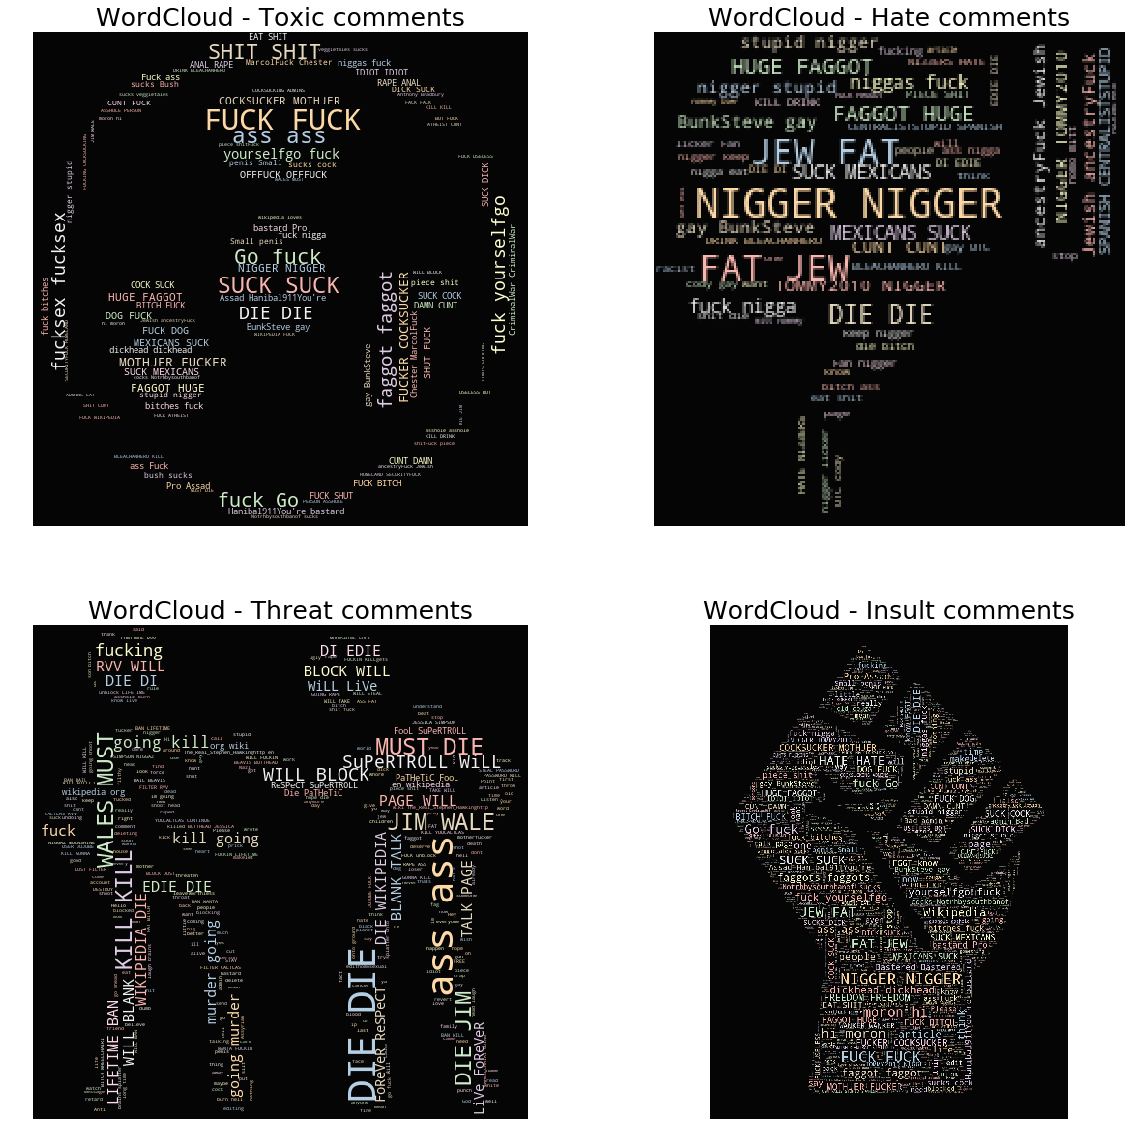

In [10]:
plot_all()

... доста забавен :D

В токсичните коментари преобладават обидните думи(можеше да се очаква), което е добре, защото би трябвало това да улесни модела.

Нека обаче сега се захванем с по-сериозен data exploration.

Първо ще си добавим една нова колона за нетоксичните коментари.

In [11]:
train_explore = train_data.copy()
train_explore['nontoxic'] = train_explore.toxic + \
                            train_explore.severe_toxic + \
                            train_explore.threat + \
                            train_explore.insult + \
                            train_explore.obscene + \
                            train_explore.identity_hate
                    
train_explore['nontoxic'] = train_explore['nontoxic'] == 0

Да видим как са разпределени данните.

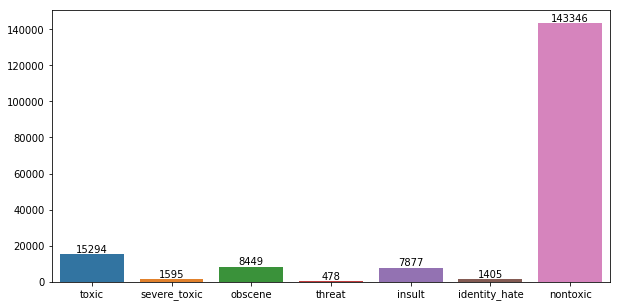

In [12]:
import seaborn as sns

columns = np.array(train_explore.columns)[1:]
values = [train_explore[column].sum() for column in columns]
plt.figure(figsize=(10,5))
ax = sns.barplot(x=columns, y=values)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, ha='center', va='bottom')

Данните без таг за токсичност са близо 90% от всички.

След като огледах какви коментари има, мисля, че ще е добре да направим сравнение между
токсичните и нетоксичните коментари в следните категории:

* Брой думи
* Дължина на коментара
* Брой главни букви
* Отношение главни букви към дължина на коментара
* Пунктуация
* Отношение пунктуация към дължина на коментара
* Брой уникални думи
* Отношение уникални думи към общ брой думи

Категориите от вида "Отношение .." ни трябват, защото забелязах, че коментарите варират много като дължина.

Това, което очаквам да видим като резултат, е:
- Токсичните коментари са по-кратки
- Токсичните коментари имат повече главни букви
- Токсичните коментари имат по-малко пунктуация
- Токсичните коментари имат по-малко уникални думи

In [13]:
import string

train_explore['words'] = train_explore.comment_text.apply(lambda s: len(s.split()))
train_explore['length'] = train_explore.comment_text.apply(lambda s: len(s))
train_explore['uppercase'] = train_explore.comment_text.apply(lambda s: sum(1 for c in s if c.isupper()))
train_explore['uppercase_ratio'] = train_explore.uppercase / train_explore.length
train_explore['punctuation'] = train_explore.comment_text.apply(lambda s: sum(1 for c in s if c in string.punctuation))
train_explore['punctuation_ratio'] = train_explore.punctuation / train_explore.length
train_explore['unique_words'] = train_explore.comment_text.apply(lambda s: len(set(s.split())))
train_explore['unique_words_ratio'] = train_explore.unique_words / train_explore.words

In [14]:
train_explore.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,words,length,uppercase,uppercase_ratio,punctuation,punctuation_ratio,unique_words,unique_words_ratio
id,,,,,,,,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,43,264,17,0.064394,10,0.037879,41,0.953488
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,17,112,8,0.071429,12,0.107143,17,1.000000
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,42,233,4,0.017167,6,0.025751,39,0.928571


In [15]:
train_explore.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,words,length,uppercase,uppercase_ratio,punctuation,punctuation_ratio,unique_words,unique_words_ratio
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,67.273527,394.073221,17.159628,0.051622,15.885418,0.047126,48.097323,0.855019
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,99.230702,590.720282,96.528103,0.092837,36.649770,0.037752,54.436443,0.128176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000800
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,96.000000,3.000000,0.020710,4.000000,0.026316,16.000000,0.779070
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,205.000000,7.000000,0.031746,8.000000,0.038123,31.000000,0.875000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,435.000000,15.000000,0.048830,17.000000,0.056318,59.000000,0.956522
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1411.000000,5000.000000,4960.000000,0.998189,4942.000000,0.994366,816.000000,1.000000


Има коментар с 4960 главни букви и такъв с 4942 символа за пунктуация. Нека първо да ги видим преди да продължим :D.

In [18]:
print("Коментарът с най-много главни букви(4960): \n")
print(train_explore.loc[train_explore.uppercase.idxmax()].comment_text,"\n")
print("Коментарът с най-много пунктуация(4942): \n")
print(train_explore.loc[train_explore.punctuation.idxmax()].comment_text)

Коментарът с най-много главни букви(4960): 

==U R GAY== 

FUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKF

Струваше си да се видят :D

Нека се върнем към по-сериозната част и да плотнем резултатите, за да видим дали ще успеем да стигнем до някакво заключение.

Text(0.5,1,'Unique Words Ratio - Toxic vs Nontoxic')

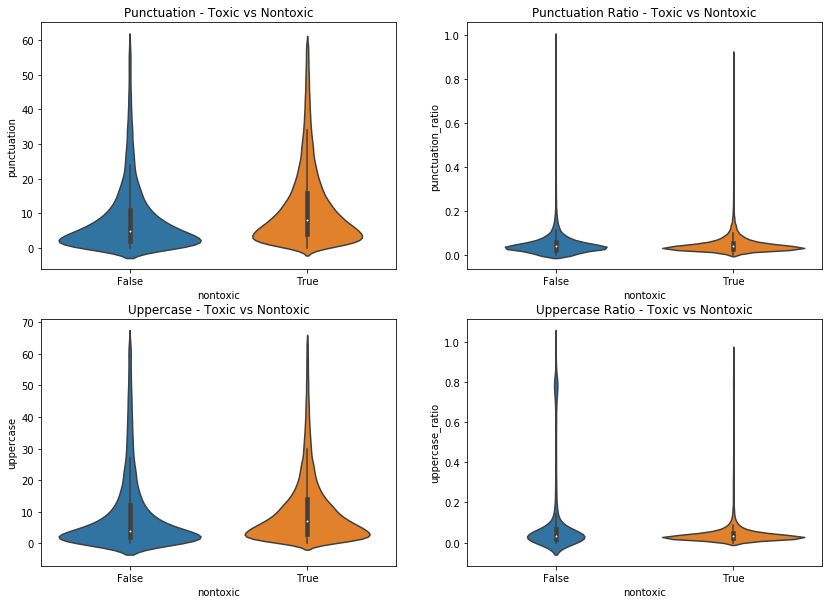

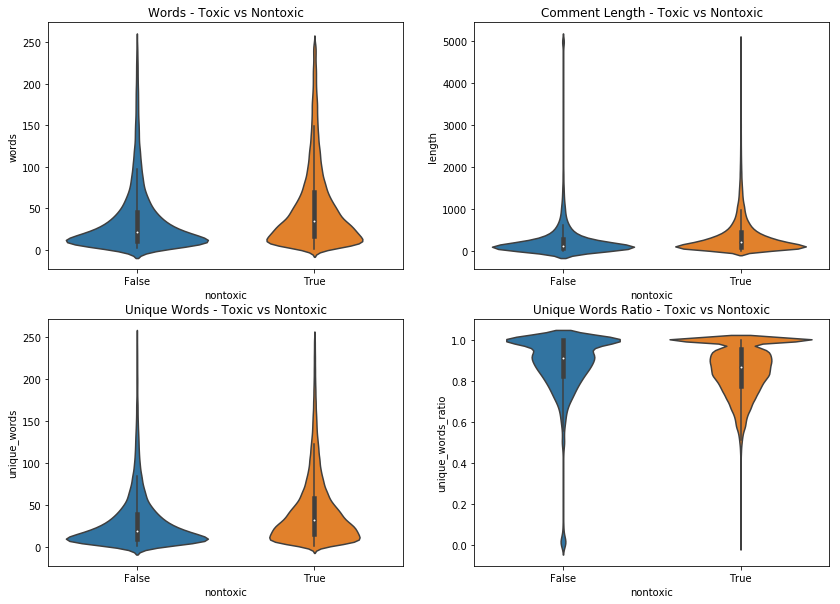

In [19]:
plt.figure(figsize=(14,10))
plt.subplot(221)
sns.violinplot(y='punctuation', x='nontoxic', data=train_explore[train_explore.punctuation < 60])
plt.title("Punctuation - Toxic vs Nontoxic")
plt.subplot(222)
sns.violinplot(y='punctuation_ratio', x='nontoxic', data=train_explore)
plt.title("Punctuation Ratio - Toxic vs Nontoxic")
plt.subplot(223)
sns.violinplot(y='uppercase', x='nontoxic', data=train_explore[train_explore.uppercase < 65])
plt.title("Uppercase - Toxic vs Nontoxic")
plt.subplot(224)
sns.violinplot(y='uppercase_ratio', x='nontoxic', data=train_explore)
plt.title("Uppercase Ratio - Toxic vs Nontoxic")

plt.figure(figsize=(14,10))
plt.subplot(221)
sns.violinplot(y='words', x='nontoxic', data=train_explore[train_explore.words < 250])
plt.title("Words - Toxic vs Nontoxic")
plt.subplot(222)
sns.violinplot(y='length', x='nontoxic', data=train_explore)
plt.title("Comment Length - Toxic vs Nontoxic")
plt.subplot(223)
sns.violinplot(y='unique_words', x='nontoxic', data=train_explore[train_explore.unique_words < 250])
plt.title("Unique Words - Toxic vs Nontoxic")
plt.subplot(224)
sns.violinplot(y='unique_words_ratio', x='nontoxic', data=train_explore)
plt.title("Unique Words Ratio - Toxic vs Nontoxic")



Като цяло не виждаме супер драстична разлика, но все пак можем забележим някои неща. Както предположихме, в токсичните коментари преобладават главните букви и там уникалните думи са по-малко. Откъм гледна точка на пунктуация сякаш можем да кажем, че в токсичните коментари Puctuation Ratio-то е по-голямо.

Някои от тези неща може евентуално да ползваме като feature-и по-късно.

Приключваме засега с data exploration-а. Започваме с правенето на модела.

Важно е да отбележим, че тук решаваме проблем от тип "Multi-Label Classification". Имаме 6 label-a('toxic', 'severe_toxic',
'obscene', 'threat', 'insult', 'identity_hate') и всеки коментар може да попада в нула или повече от тези категории.

Подходите към "Multi-Label Classification" са следните:

* **Binary Relevance** -  най-простичкият метод, при който третираме всеки label като независим и отделен класификационен проблем. Например, ако имаме dataset X|y1,y2,y3 ще разбием проблема на следните три: X|y1, X|y2, X|y3 


* **Classifier Chains** - в този случай първият класификатор се тренира само на входните данни, вторият се тренира на входните данни и резултатът от първия и т.н. Например ако имаме datatset X|y1,y2,y3, първо тренираме върху X и предсказваме y1, после тренираме върху X|y1 и предсказваме y2 и накрая тренираме върху X|y1,y2 и предсказваме y3.



* **Label Powerset** - при този подход map-ваме множеството от label-ите за всеки запис към някакво число. Например, ако имаме label-и y1,y2,y3,y4 и запис със стойности съответно [1,0,0,1], то той ще е от клас 1\*2^3 + 0\*2^2 + 0\*2^1 + 1\*2^1 = 9. Така задача с двукласови n label-а се свежда до задача с единствен 2^n класов label. 

Ще се придържам към подход 1 и 2. В sklearn има вградени класове за тях - MultiOutputClassifier и ClassifierChain.

Разбира се, първо атакуваме с baseline модел с MultiOutputClassifier.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier

X = train_data.comment_text
y = train_data[train_data.columns[1:]]

pipe = Pipeline([
    ('vecotrizer', CountVectorizer()),
    ('classifier', MultiOutputClassifier(LogisticRegression()))
])

cross_val_score(pipe, X, y, cv=3, n_jobs=3)

array([ 0.90831156,  0.90804663,  0.90904305])

Ехаaa.. 90% score. Много лесно беше. Да видим обаче дали confusion matrix-a няма да ни свали на земята. 

In [21]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(pipe, X, y, cv=3, n_jobs=3)

In [22]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    #plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

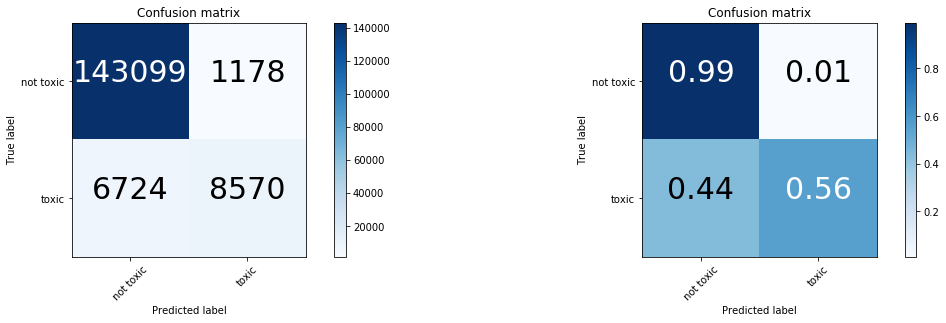

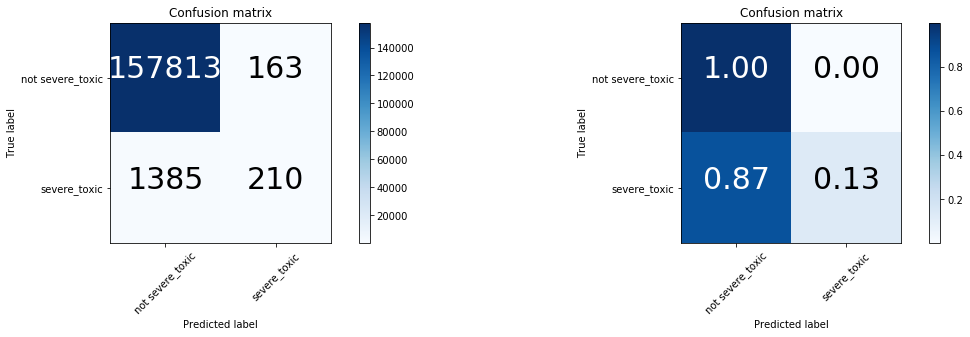

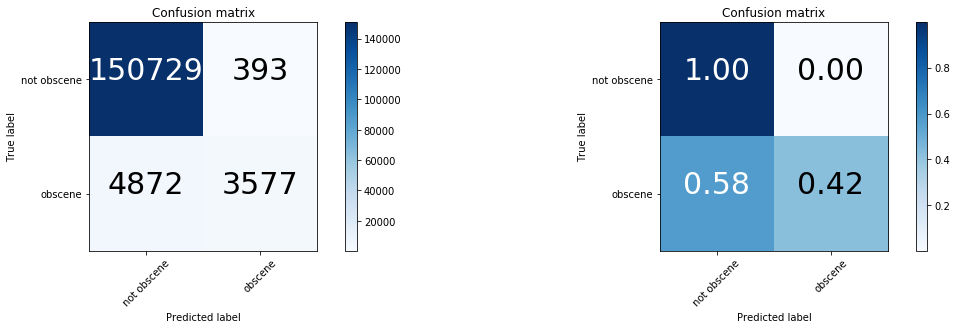

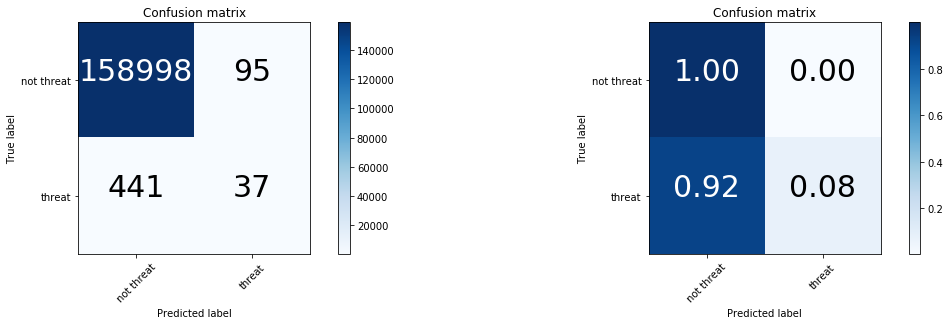

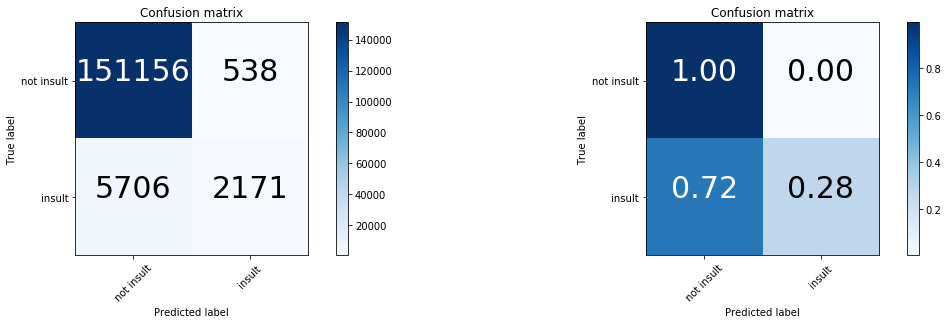

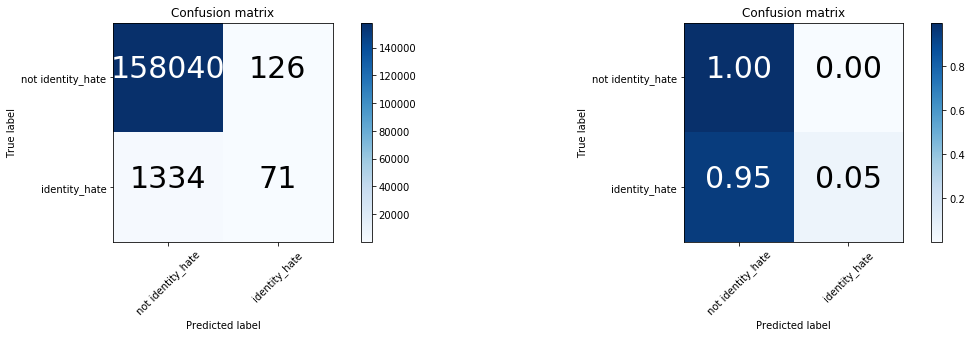

In [23]:
def plot_all_confusion_matrices(y, predictions):
    columns = train_data.columns[1:]
    for i in range(6):
        y_true = y[columns[i]]
        y_pred = predictions[:,i]
        plt.figure(figsize=(16,8))
        plt.subplot(221)
        plot_confusion_matrix(y_true, y_pred, classes=['not '+columns[i], columns[i]], figsize=(8,4))
        plt.subplot(222)
        plot_confusion_matrix(y_true, y_pred, normalize=True, classes=['not '+columns[i], columns[i]], figsize=(8,4))

plot_all_confusion_matrices(y, predictions)

За малко да паднем в капана. Тъй като коментарите, които са без label за токсичност, са 90% от целия дейтасет, дори и dummy classifier ще се да се справи с 90% точност.

In [24]:
from sklearn.dummy import DummyClassifier
pipe.set_params(classifier=MultiOutputClassifier(DummyClassifier(strategy='constant', constant=0)))
cross_val_score(pipe, X, y, cv=3, n_jobs=3)

array([ 0.89699385,  0.89919158,  0.89877797])

Нека пробваме и с baseline модел базиран само на feature-ите, които разгледахме по-горе.

In [25]:
X_features = train_explore[train_explore.columns[8:]]
cross_val_score(MultiOutputClassifier(LogisticRegression()), X_features, y, cv=3, n_jobs=3)

array([ 0.89658025,  0.89719872,  0.89727392])

Да проверим и confusion матриците все пак.

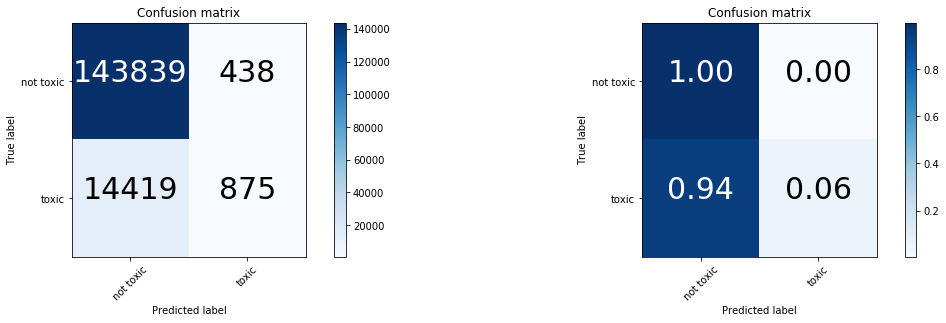

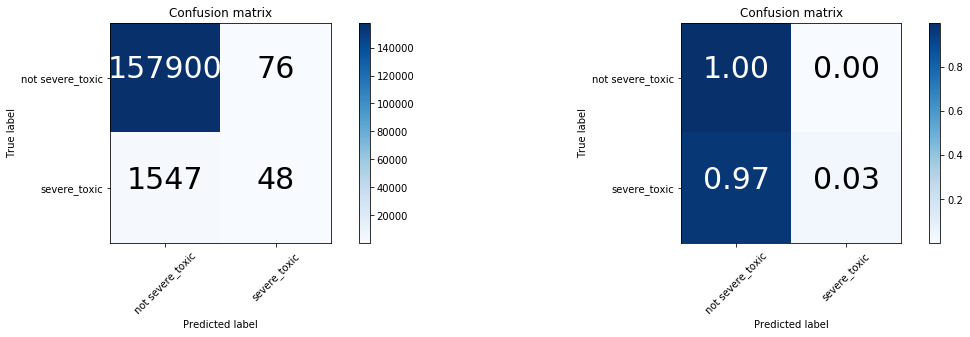

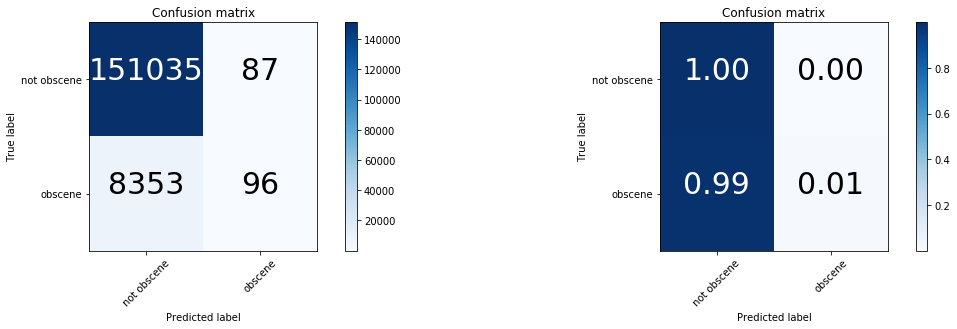

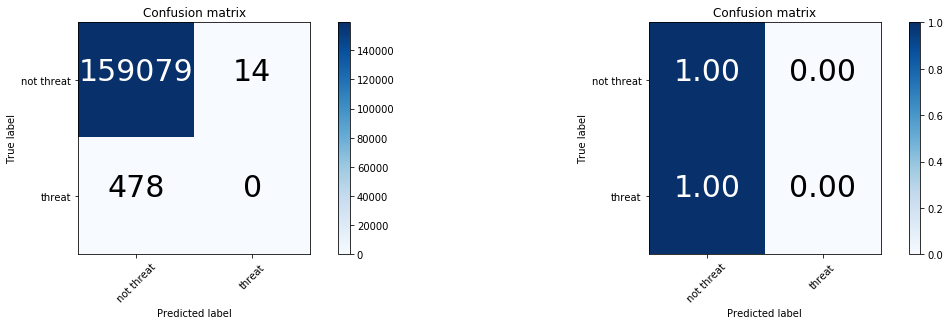

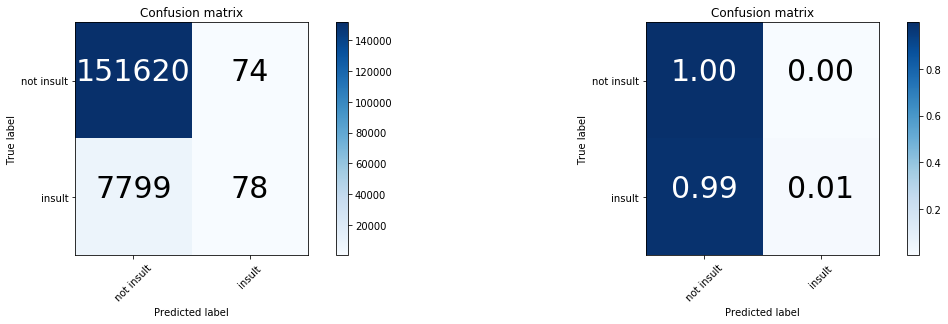

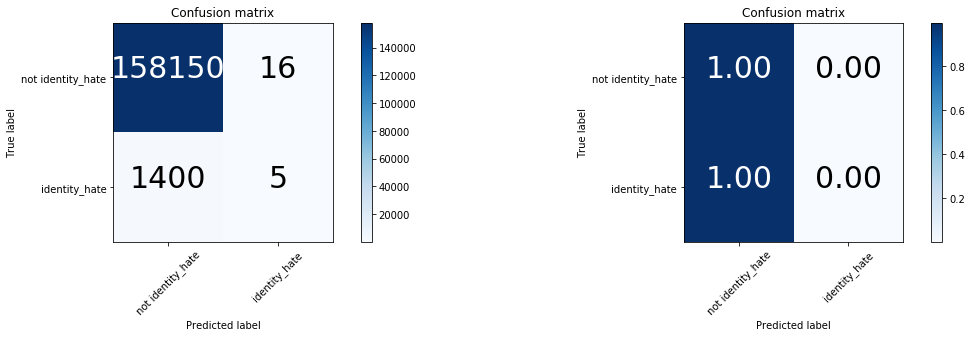

In [26]:
predictions = cross_val_predict(MultiOutputClassifier(LogisticRegression()), X_features, y, cv=3, n_jobs=3)
plot_all_confusion_matrices(y, predictions)

Трагично.

Крайно време е вече да атакуваме проблемът по-сериозно.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = Pipeline([
    ('vecotrizer',TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    
    ('classifier', MultiOutputClassifier(LogisticRegression()))
])

predictions = cross_val_predict(pipe, X, y, cv=3, n_jobs=3)

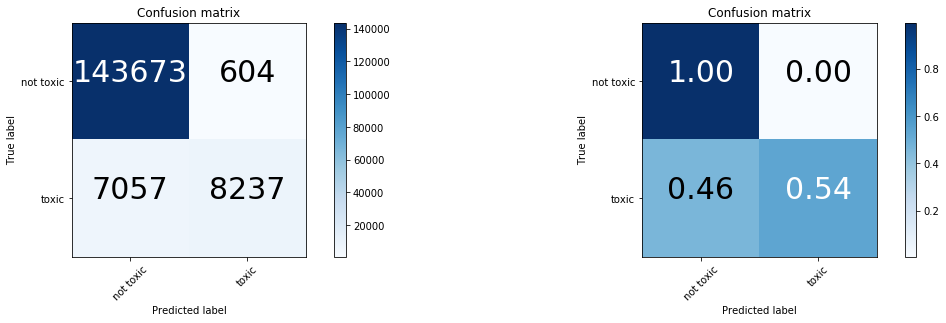

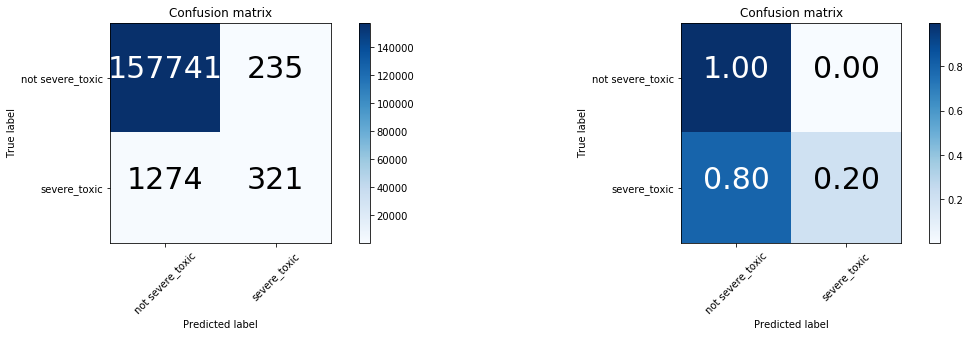

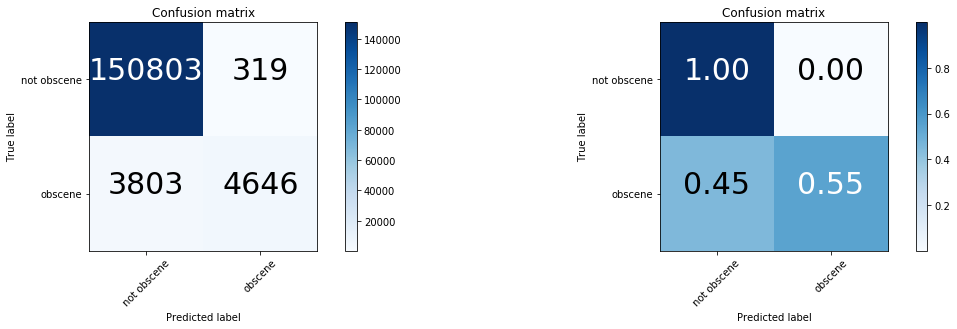

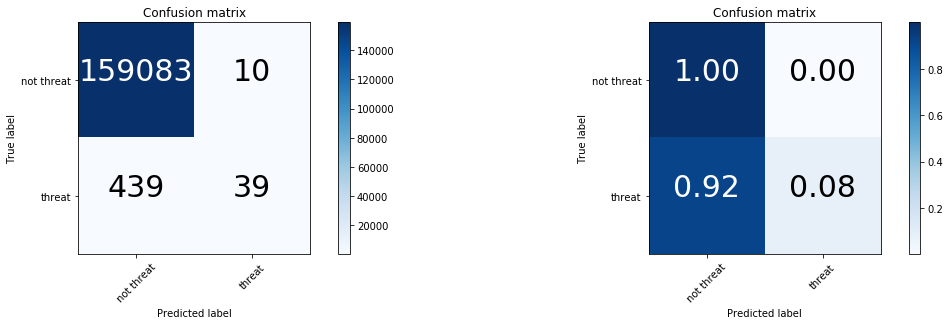

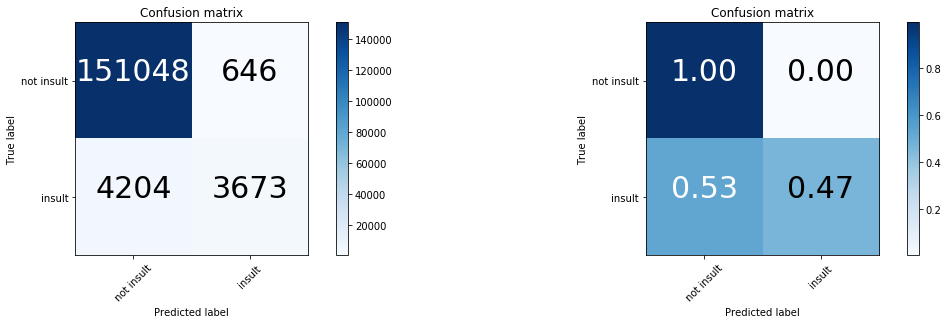

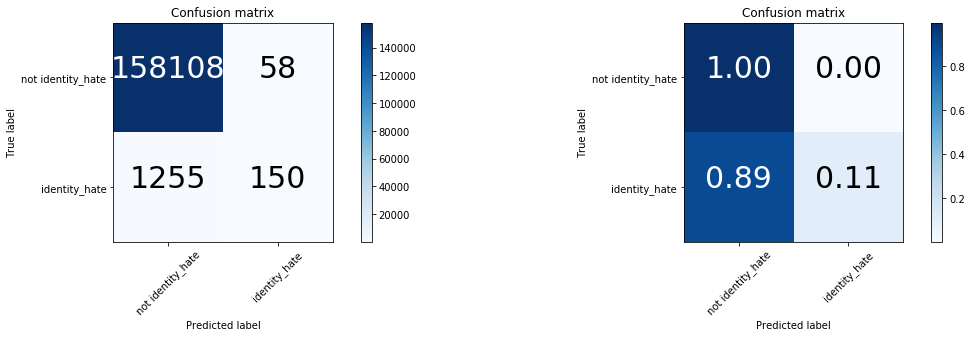

In [28]:
plot_all_confusion_matrices(y, predictions)

Малко по-добри резултати след използването на TfidfVectorizer. Все пак реших да направя един тестови събмишън с този модел и резултат беше 0.97. Важно е да се отбележи, че се submit-ват probability-та и резултата се мери с ROC AUC метрика(лицето под кривата в графиката за TPR и FPR). При нас TPR е доста нисък, но пък за сметка на това FPR е трепач и оттам идва високия резултат. 

Ще направя една бърза демонстрация на AUC кривата.

Фитваме върху целият дейтасет.

In [29]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('vecotrizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tr...None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1))])

In [30]:
pipe.score(X, y)

0.92670347368882822

Малко по-висок score. Очаквано, но не това е важното сега. Само демонстрирам AUC кривата.

Малко трансформации, за да вземем predict probability-тата.

In [31]:
predictions = pipe.predict_proba(X)
predictions = np.array(predictions)
predictions = predictions[:,:,1].T

И сега функция, която да ни начертае AUC кривата за всеки клас.

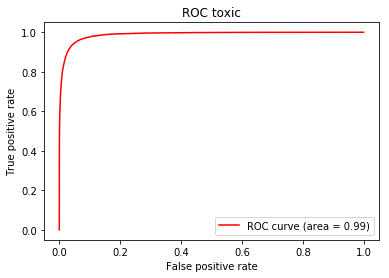

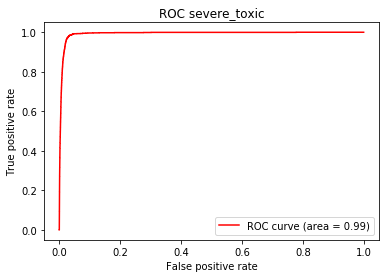

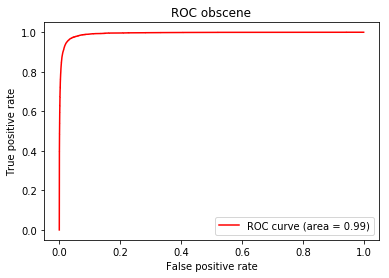

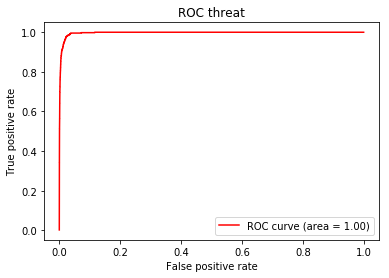

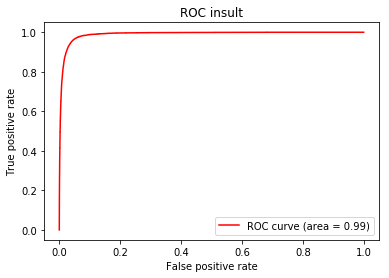

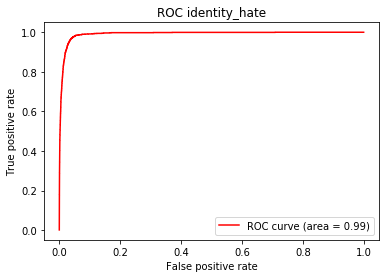

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def plot_all_roc_curves(y, predictions):
    columns = train_data.columns[1:]
    for i in range(6):
        y_true = y[columns[i]]
        y_pred = predictions[:,i]
        frp,trp,thres = roc_curve(y_true, y_pred)
        auc_val =auc(frp,trp)
        plt.figure(figsize=(6,4))
        plt.plot(frp,trp,color='r', label='ROC curve (area = %0.2f)' % auc_val)
        plt.legend(loc='lower right')
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.title('ROC ' + columns[i])
        

plot_all_roc_curves(y, predictions)

Въпреки, че резултатът е 0.92, ROC AUC метриката е много висока, защото тя не зависи от FN, а при нас те са много.

Целта ни оттук нататък ще е да подобрим този резултат, доколкото е възможно(т.е. да увеличим TPR, но не за сметка на FPR).<br/>  Вариантите за действие са следните:

1. Почистване на коментарите и намиране на оптимален модел съставен от някакъв Vectorizer и някакъв класификатор
2. Word Embeddings, NN, RNN

Започваме с подход №1.

Нека почистим данните.

In [33]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

# Премахваме символите различни от букви
tokenizer = RegexpTokenizer(r"\w+")
train_explore.comment_text = train_explore.comment_text.apply(lambda t:" ".join(tokenizer.tokenize(t.lower().strip())))

# Премахваме stopwords
stop_words = stopwords.words('english')
train_explore.comment_text = train_explore.comment_text.apply(lambda t:" ".join([w for w in t.split() if not w in stop_words]))

# Stemming
stem = SnowballStemmer('english')
train_explore.comment_text = train_explore.comment_text.apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

Ще ползвам функцията на Лъчо за report-ване на резултатите от RandomizedSearch.

In [34]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Нека видим какво ще се получи.

In [35]:
from sklearn.model_selection import RandomizedSearchCV

X = train_explore.comment_text
y = train_data[train_data.columns[1:]]

pipe = Pipeline([
    ('vecotrizer', TfidfVectorizer()),
    ('classifier', MultiOutputClassifier(LogisticRegression()))
])

params =  {
            'classifier__estimator__C':[0.1, 0.5, 1, 5],
            "vecotrizer__ngram_range": [(1,1), (1,2), (1,3)],
            "vecotrizer__analyzer": ['word'],
            "vecotrizer__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
            "vecotrizer__min_df":[2, 3, 5, 10]
          }




random_search = RandomizedSearchCV(pipe, param_distributions=params,
                                       scoring='roc_auc',
                                       n_iter=20, cv=3, n_jobs=4)

random_search.fit(X, y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer__ngram_range': (1, 3), 'vecotrizer__min_df': 2, 'vecotrizer__max_df': 0.9, 'vecotrizer__analyzer': 'word', 'classifier__estimator__C': 5}

Model with rank: 2
Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer__ngram_range': (1, 2), 'vecotrizer__min_df': 3, 'vecotrizer__max_df': 0.6, 'vecotrizer__analyzer': 'word', 'classifier__estimator__C': 5}

Model with rank: 3
Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer__ngram_range': (1, 3), 'vecotrizer__min_df': 3, 'vecotrizer__max_df': 1.0, 'vecotrizer__analyzer': 'word', 'classifier__estimator__C': 5}

Model with rank: 4
Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer__ngram_range': (1, 1), 'vecotrizer__min_df': 3, 'vecotrizer__max_df': 0.8, 'vecotrizer__analyzer': 'word', 'classifier__estimator__C': 1}

Model with rank: 4
Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer__ngram_range':

Ще пробваме и с HashingVectorizer.

In [36]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('vecotrizer', HashingVectorizer()),
    ('classifier', MultiOutputClassifier(LogisticRegression()))
])

params =  {
            "classifier__estimator__C": [0.1, 0.5, 1, 5],
            "vecotrizer__ngram_range": [(1,1), (1,2), (1,3)]
          }




random_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=4)

random_search.fit(X, y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.977 (std: 0.001)
Parameters: {'classifier__estimator__C': 5, 'vecotrizer__ngram_range': (1, 2)}

Model with rank: 2
Mean validation score: 0.977 (std: 0.002)
Parameters: {'classifier__estimator__C': 5, 'vecotrizer__ngram_range': (1, 3)}

Model with rank: 3
Mean validation score: 0.977 (std: 0.001)
Parameters: {'classifier__estimator__C': 5, 'vecotrizer__ngram_range': (1, 1)}

Model with rank: 4
Mean validation score: 0.976 (std: 0.002)
Parameters: {'classifier__estimator__C': 1, 'vecotrizer__ngram_range': (1, 1)}

Model with rank: 5
Mean validation score: 0.975 (std: 0.002)
Parameters: {'classifier__estimator__C': 1, 'vecotrizer__ngram_range': (1, 2)}



Ще направя един submission с този модел: 

Mean validation score: 0.979 (std: 0.002)
Parameters: {'vecotrizer\__ngram_range': (1, 1), 'vecotrizer\__min_df': 2, 'vecotrizer\__max_df': 0.7, 'vecotrizer\__analyzer': 'word', 'classifier\__estimator\__C': 0.5, 'classifier\__estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)}

In [37]:
pipe = Pipeline([
    ('vecotrizer', TfidfVectorizer(min_df=2, max_df=0.7)),
    ('classifier', MultiOutputClassifier(LogisticRegression(C=1.0)))
])

pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('vecotrizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1))])

Почистваме и test set-a.

In [38]:
test_data_copy = test_data.copy()

tokenizer = RegexpTokenizer(r"\w+")
test_data_copy.comment_text = test_data_copy.comment_text.apply(lambda t:" ".join(tokenizer.tokenize(t.lower().strip())))

stop_words = stopwords.words('english')
test_data_copy.comment_text = test_data_copy.comment_text.apply(lambda t:" ".join([w for w in t.split() if not w in stop_words]))

stem = SnowballStemmer('english')
test_data_copy.comment_text = test_data_copy.comment_text.apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

Малко обработки, за да е в подходящ вид.

In [39]:
proba = pipe.predict_proba(test_data_copy.comment_text)
proba = pd.DataFrame(np.array(proba)[:,:,1].T)
proba.columns, proba.index = train_data.columns[1:], test_data.index

In [53]:
proba.to_csv('data\\tfidf-lr-submissions.csv')

Резултатът е 0.973, а в класирането сме 700 от 1400.

Оттук нататък ще се опитаме да направим и някаква NN.

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D
from keras.models import Model

Using TensorFlow backend.


Отново ще позичистим леко данните.

_"There is no universal answer. It all depends on what you plan to use the vectors for. In my experience, it is usually good to disconnect (or remove) punctuation from words, and sometimes also convert all characters to lowercase. One can also replace all numbers (possibly greater than some constant) with some single token such as ."_ - __Tomas Mikolov__, оne of the developers of word2vec

Ще последваме съвета на Tomas.

In [42]:
import re

# махаме всички символи различни от буква или цифра
tokenizer = RegexpTokenizer(r"\w+")
X_train = train_data.comment_text.apply(lambda t:" ".join(tokenizer.tokenize(t.lower().strip())))
X_test = test_data.comment_text.apply(lambda t:" ".join(tokenizer.tokenize(t.lower().strip())))

# заменяме числата с .
X_train = np.array(X_train.apply(lambda t:" ".join([re.sub(r'\d+','.',w) for w in t.split()])))
X_test = np.array(X_test.apply(lambda t:" ".join([re.sub(r'\d+', '.', w) for w in t.split()])))

y = np.array(train_data[train_data.columns[1:]])

Ще използваме класът Tokenizer от Keras.

Class for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).

In [43]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Ще трябва и да pad-нем данните, защото коментарите варират като дължина.

In [44]:
maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

Ще пробваме с няколко архитектури. Повечето от тях са вдъхновени от примерните NN на Keras, а другите от различни kernel-и от състезанието в kaggle.

Реално изпробвах доста неща. Тук съм оставил най-добре представящите се.

За всички NN ще ползвам натренираните embedding-и от GloVe. И по-точно ето този: '42B tokens, 1.9M vocab, uncased, 300d vectors'.

За целта първо ще трябва да ги прочета от файла и ще ги запазя в едно дикшънъри, което на всяка дума съпоставя вектора ѝ.

In [45]:
import os

GLOVE_DIR = 'C:\\Users\\Mitko\\Documents\\python\\glove'
EMBEDDING_DIM =300
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Следващата стъпка е да създам embedding матрица, която ще се подаде на Embedding слоя. Embedding матрицата представлява следното нещо: матрица с размерност _брой думи в корпуса ни_ x _300(размерността на ембединг векторите)_, в която на ред i стои съответния вектор за думата на индекс i от корпуса ни.

In [46]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # думи, които не се срещат в речника на претренирания ембединг, ще имат нулеви вектори
        embedding_matrix[i] = embedding_vector

Първата невронна мрежа, която ще направим, най-основно се базира на слой ембединг, слой LSTM и слой Dense. Като използваме и междинни Dropout и GlobalMaxPool слоеве, за да не стават твърде много параметрите.

In [47]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False)(inp)
x = LSTM(60, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [48]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          51908100  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           86640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

Благодарение на претренираните ембединги имаме само 90 000 параметъра.

Тренираме само с 2 епохи, защото отнема доста време, а и по мои наблюдения невронната мрежа(в този си вид) спира да подобрява резултата си някъде в средата на втората епоха.

In [50]:
batch_size = 32
epochs = 2
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 874s 7ms/step - loss: 0.0556 - acc: 0.9800 - val_loss: 0.0481 - val_acc: 0.9821
Epoch 2/2
119678/119678 [==============================] - 874s 7ms/step - loss: 0.0443 - acc: 0.9830 - val_loss: 0.0436 - val_acc: 0.9832


Predict-ваме и submit-ваме.

In [51]:
predictions = model.predict(X_test, verbose=True)

153164/153164 [==============================] - 396s 3ms/step


In [52]:
submissions = pd.DataFrame(predictions)
submissions.index, submissions.columns = test_data.index, train_data.columns[1:]
submissions.to_csv('data\\rnn-submissions.csv')

Резултат 0.9807 и излизам на 581 място (от 1800).

Следващата невронна мрежа, която ще направим ще е рекурентна и конволюционна.

In [61]:
from keras.layers import Conv1D, MaxPooling1D

kernel_size = 5
filters = 64

inp = Input(shape=(maxlen, ))
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False)(inp)
x = Conv1D(filters,
           kernel_size,
           padding='valid',
           activation='relu',
           strides=1)(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(70, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(6, activation="sigmoid")(x)

In [62]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 300)          51908100  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 196, 64)           96064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 49, 70)            37800     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 426       
Total para

Този път имаме повече параметри. Да видим какво ще стане.

In [64]:
batch_size = 32
epochs = 2
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 618s 5ms/step - loss: 0.0584 - acc: 0.9795 - val_loss: 0.0498 - val_acc: 0.9821
Epoch 2/2
119678/119678 [==============================] - 615s 5ms/step - loss: 0.0460 - acc: 0.9827 - val_loss: 0.0474 - val_acc: 0.9824


Отново predict + submit.

In [65]:
predictions = model.predict(X_test, verbose=True)

153164/153164 [==============================] - 311s 2ms/step


In [66]:
submissions = pd.DataFrame(predictions)
submissions.index, submissions.columns = test_data.index, train_data.columns[1:]
submissions.to_csv('data\\crnn-submissions.csv')

Резултат: 0.9703

И за финал една изцяло CNN.

In [68]:
from keras.layers import GlobalMaxPooling1D

inp = Input(shape=(maxlen, ))
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False)(inp)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(6, activation="sigmoid")(x)

In [69]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 300)          51908100  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 196, 128)          192128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3, 128)            82048     
__________

Тук вече параметрите стават още повече.

In [70]:
batch_size = 32
epochs = 2
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 798s 7ms/step - loss: 0.0639 - acc: 0.9782 - val_loss: 0.0577 - val_acc: 0.9800
Epoch 2/2
119678/119678 [==============================] - 822s 7ms/step - loss: 0.0550 - acc: 0.9805 - val_loss: 0.0662 - val_acc: 0.9791


In [71]:
predictions = model.predict(X_test, verbose=True)
submissions = pd.DataFrame(predictions)
submissions.index, submissions.columns = test_data.index, train_data.columns[1:]
submissions.to_csv('data\\cnn-submissions.csv')

153164/153164 [==============================] - 437s 3ms/step


0.9486

За финал ще пусна най-добре представилата се невронна мрежа за повече епохи.

In [72]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False)(inp)
x = LSTM(60, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

batch_size = 32
epochs = 5
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.25)

Train on 119678 samples, validate on 39893 samples
Epoch 1/5
119678/119678 [==============================] - 976s 8ms/step - loss: 0.0541 - acc: 0.9804 - val_loss: 0.0460 - val_acc: 0.9825
Epoch 2/5
119678/119678 [==============================] - 892s 7ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0430 - val_acc: 0.9834
Epoch 3/5
119678/119678 [==============================] - 879s 7ms/step - loss: 0.0410 - acc: 0.9839 - val_loss: 0.0442 - val_acc: 0.9826
Epoch 4/5
119678/119678 [==============================] - 881s 7ms/step - loss: 0.0389 - acc: 0.9845 - val_loss: 0.0439 - val_acc: 0.9830
Epoch 5/5
119678/119678 [==============================] - 885s 7ms/step - loss: 0.0374 - acc: 0.9851 - val_loss: 0.0438 - val_acc: 0.9834


In [73]:
predictions = model.predict(X_test, verbose=True)
submissions = pd.DataFrame(predictions)
submissions.index, submissions.columns = test_data.index, train_data.columns[1:]
submissions.to_csv('data\\rnn2-submissions.csv')

153164/153164 [==============================] - 399s 3ms/step


Финален резултат : 0.9808 и 576 от 1818.

# Заключение

Tози kaggle competition беше една наистина интересна задача. Успях да направя добър data exploration, който ми помогна да опозная по-добре данните. Направих лек масаж и почистване на коментарите, което спомогна за по-високите резултати. Небалансираното разпределение на данните за малко да ме подведе, но благодарение на confusion matrix-ите имах реална представа за това как се справят моделите. Сблъсках се с нови неща като Multi-Label Classification и ROC AUC метриката. Един простичък модел базиран на Tfidf + LR се справи доста прилично, но отстъпи на невронните мрежи. Изпробвах няколко архитектури вдъхновени основно от примерите в Keras и в крайна сметка постигнах един добър резултат(едва с 0.0068 по-слаб от този на първенеца).